In [1]:
# imports
import json
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import sklearn
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor 
from statistics import mean
import pickle
import statistics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from numpy import absolute
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from collections import Counter
from matplotlib import pyplot

In [2]:
city = 'Delhi'
month = 'Dec'
PATH = f'./../../Item_wise_data/{city}/'
# PATH = './../'


In [3]:
# exclude non baking items
df = pd.read_csv(PATH+f'{month}.csv')
df = df[pd.notna(df['Oven_Time'])]
df = df.sort_values(by =['Kitchen_Display_Time', 'Location_Code', 'Order_Number'])
# df

In [4]:
print(df.shape)
df = df.drop(['storedesc', 'city', 'Customer_Code', 'Customer_Name', 'Actual_Order_Date', 'Order_Status_Code', 'Order_Type_Code', 'Order_Saved', 'Order_Time', 'Driver_ID', 'Route_Time', 'Return_Time', 'Delayed_Order', 'Order_Taker_ID','Order_Taker_Shift', 'Closed_Order_Time', 'Customer_Address_Id', 'Original_Location_Code', 'Order_Id',], axis=1)
print(df.shape)


(1266282, 29)
(1266282, 10)


In [5]:
df['Kitchen_Display_Time'] = pd.to_datetime(df['Kitchen_Display_Time'])
df['Oven_Time'] = pd.to_datetime(df['Oven_Time'])
df['prep_time'] = df['Oven_Time'] - df['Kitchen_Display_Time']
df['prep_time'] = (df['prep_time']/np.timedelta64(1, 's')).astype(float)
print(df.shape)
df.head()

(1266282, 11)


Location_Code  Order_Date  Order_Number  Driver_Shift  \
5295      DPI63889  2021-12-17             1             0   
5297      DPI63889  2021-12-17             1             0   
5298      DPI63889  2021-12-17             2             0   
5302      DPI63889  2021-12-17             2             0   
5303      DPI63889  2021-12-17             3             0   

        Kitchen_Display_Time               Oven_Time Menu_Code  \
5295 2021-12-17 07:28:22.537 2021-12-17 07:28:50.773   PIZ0132   
5297 2021-12-17 07:28:22.537 2021-12-17 07:28:50.837  NVPARCEL   
5298 2021-12-17 07:33:46.873 2021-12-17 07:33:52.233   PIZ0134   
5302 2021-12-17 07:33:46.873 2021-12-17 07:33:52.563   PIZ0117   
5303 2021-12-17 09:24:05.420 2021-12-17 09:24:14.843   PIZ5109   

                   Item Description  Quantity            Delivery_Time  \
5295  _PIZ55-Pizza Mania Paneer _On         1  2021-12-17 07:37:29.117   
5297                 Chicken Parcel         1  2021-12-17 07:37:29.117   
5298             Pizza Mania Tomato         1  2021-12-17 07:42:34.047   
5302                 _SV-Margherita         1  2021-12-17 07:42:34.047   
5303             PM Chicken Sausage         1  2021-12-17 09:39:10.430   

      prep_time  
5295     28.236  
5297     28.300  
5298      5.360  
5302      5.690  
5303      9.423

In [6]:
isThresholdForPreparationTime = True
thresholdForPreparationTimeUpper = 15 # minutes for preparation time (threshold)
thresholdForPreparationTimeLower = 0 # minutes for lowest preparation time (threshold)
df2 = pd.DataFrame()
if (isThresholdForPreparationTime):
    df = df.loc[(df['prep_time'] <= thresholdForPreparationTimeUpper*60) & \
        (df['prep_time'] >= thresholdForPreparationTimeLower*60) ]
print(df.shape)
df.head()

(1181482, 11)


Location_Code  Order_Date  Order_Number  Driver_Shift  \
5295      DPI63889  2021-12-17             1             0   
5297      DPI63889  2021-12-17             1             0   
5298      DPI63889  2021-12-17             2             0   
5302      DPI63889  2021-12-17             2             0   
5303      DPI63889  2021-12-17             3             0   

        Kitchen_Display_Time               Oven_Time Menu_Code  \
5295 2021-12-17 07:28:22.537 2021-12-17 07:28:50.773   PIZ0132   
5297 2021-12-17 07:28:22.537 2021-12-17 07:28:50.837  NVPARCEL   
5298 2021-12-17 07:33:46.873 2021-12-17 07:33:52.233   PIZ0134   
5302 2021-12-17 07:33:46.873 2021-12-17 07:33:52.563   PIZ0117   
5303 2021-12-17 09:24:05.420 2021-12-17 09:24:14.843   PIZ5109   

                   Item Description  Quantity            Delivery_Time  \
5295  _PIZ55-Pizza Mania Paneer _On         1  2021-12-17 07:37:29.117   
5297                 Chicken Parcel         1  2021-12-17 07:37:29.117   
5298             Pizza Mania Tomato         1  2021-12-17 07:42:34.047   
5302                 _SV-Margherita         1  2021-12-17 07:42:34.047   
5303             PM Chicken Sausage         1  2021-12-17 09:39:10.430   

      prep_time  
5295     28.236  
5297     28.300  
5298      5.360  
5302      5.690  
5303      9.423

In [7]:
df.isnull().sum().sort_values(ascending=False)/df.shape[0]

Delivery_Time           0.005287
Location_Code           0.000000
Order_Date              0.000000
Order_Number            0.000000
Driver_Shift            0.000000
Kitchen_Display_Time    0.000000
Oven_Time               0.000000
Menu_Code               0.000000
Item Description        0.000000
Quantity                0.000000
prep_time               0.000000
dtype: float64

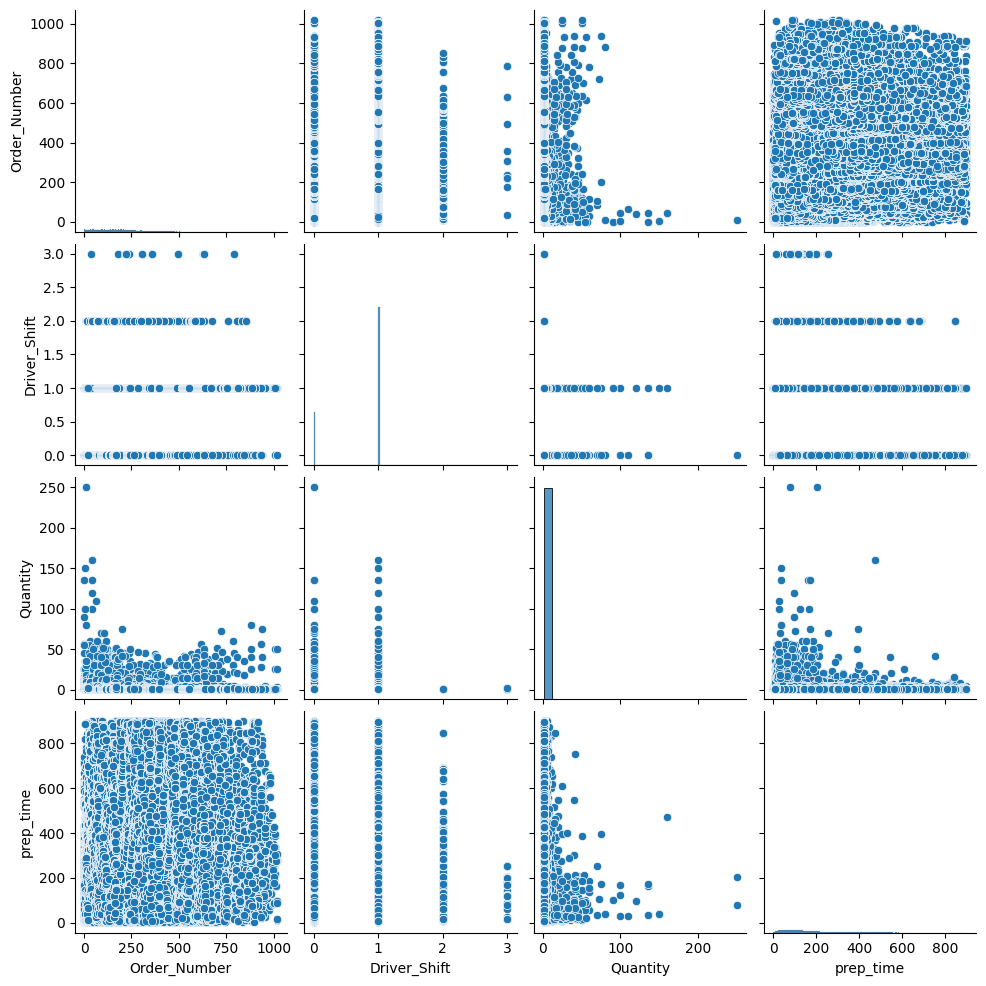

In [8]:
sns.pairplot(data=df)

<Axes: >

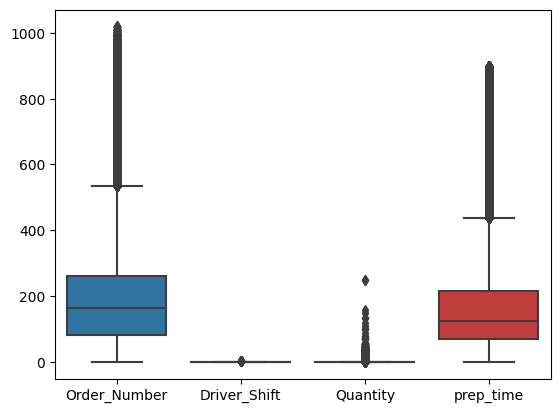

In [9]:
sns.boxplot(df)

In [10]:
allMenuCodes = df['Menu_Code'].unique()
allStoreIds = sorted(Counter(df['Location_Code'].values.tolist()), reverse=True)
# allMenuCodes,
# allStoreIds
print(len(allMenuCodes))
print(len(allStoreIds))

94
107


In [11]:
restWiseDFs = {}
for storeId in allStoreIds:
    restWiseDFs[storeId] = df.loc[df['Location_Code'] == storeId]

In [12]:
def get_preparation_time(item):
    return item['prep_time']

In [13]:
sampleItem=None
for index, item in df.iterrows():
    sampleItem = item
    break

In [14]:
# Feature 1: store id
def getOneHotEncodingStore(storeId, stores=allStoreIds):
    oneHotEncodingList = []
    for i in range(0, len(stores)):
        if stores[i] == storeId:
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

# returns the feature store id for an order
def getStoreId(item, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodingStore(item['Location_Code'], allStoreIds)
    else:
        for i in range(0, len(allStoreIds)):
            if item['Location_Code'] == allStoreIds[i]:
                return [i+1]
        return [-1]

In [15]:
# Feature 2 : Day of the week
def dayOfTheWeek(dt, isOneHotEncodingRequired=False):
    day = dt.weekday()
    if isOneHotEncodingRequired:
        days = [0, 0, 0, 0, 0, 0, 0]
        days[day] = 1
        return days
    else:
        return [day+1]

In [16]:
print(getStoreId(sampleItem))
print(getStoreId(sampleItem, True))

[100]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [17]:
# Feature 3: TimeSlot of kitchen display time
total_slots = 24
def getTimeslot(dt, slots=total_slots):
	current = datetime(2011, 1, 1)
	t1 = current.time()
	t2 = dt.time()
	for i in range(0, slots):
		current = current + timedelta(minutes = 60*24/slots)
		if(current.time() > t2):
			return i
	return slots-1

def getOneHotEncodingTimeSlot(timeslot):
    oneHotEncodingList = []
    for i in range(0, 24):
        oneHotEncodingList.append(0)
    oneHotEncodingList[timeslot] = 1
    return oneHotEncodingList

def getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=False):
    timeslot = getTimeslot(item['Kitchen_Display_Time'], 24)
    if (isOneHotEncodingRequired):
        return getOneHotEncodingTimeSlot(timeslot)
    else:
        return [1+timeslot]

In [18]:
# Feature 4: Item Type
def getOneHotEncodedItemList(item, items=allMenuCodes, clubCategoryWise=False):
    if clubCategoryWise:
        newItemsList = []
        newItemsList = [i[0:3] for i in items]
        unique_items = list(dict.fromkeys(newItemsList))
        return getOneHotEncodedItemList(item[0:3], unique_items, False)
    
    oneHotEncodingList=[]
    for i in range(0, len(items)):
        if items[i] == item:
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

def getItemType(item, clubCategoryWise=False, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodedItemList(item['Menu_Code'], allMenuCodes, clubCategoryWise)
    else:
        for i in range(0, len(allMenuCodes)):
            if allMenuCodes[i] == item['Menu_Code']:
                return [i+1]
        print("DANGER DANGER DANGER \n\n\n")
        return [-1]

In [19]:
print(getItemType(sampleItem, False, True))
print(getItemType(sampleItem, True, False))
print(getItemType(sampleItem, clubCategoryWise=True))
print(getItemType(sampleItem, True))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1]
[1]
[1]


In [20]:
# Feature 5 : Count of all baking items of all orders received by the store in the last 30 minutes.

def countPastOrders(item, slotTime=30):
    storeId = item['Location_Code']
    df = restWiseDFs[storeId]
    dtKitchenDisplay = item['Kitchen_Display_Time']
    lastTime = dtKitchenDisplay - timedelta(minutes=slotTime)
    return len(df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
          (df['Kitchen_Display_Time'] <= dtKitchenDisplay)].index)

In [21]:
# Feature 6: ratio of items in last 30 minutes with items in the window of last 60 to 30 minutes (increment in orders)
def getLiftInOrders(item, slotTime = 30):
    a = countPastOrders(item, slotTime)
    item2 = item
    item2['Kitchen_Display_Time'] = item2['Kitchen_Display_Time'] - timedelta(minutes=slotTime)
    b = countPastOrders(item2, slotTime)
    if b != 0:
        return a/b
    else:
        return 1


In [22]:
# TIME CONSUMING (4 m 14 seconds for Bhopal)
# Feature 7 : Avg prep time of the same item in the same store in last 60 minutes.
# Feature 8 : Avg prep time of the same item in the same store in last 7 days.
for storeId in restWiseDFs:
    avgPrepTime = restWiseDFs[storeId]['prep_time'].mean()    
    restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
    restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
    restWiseDFs[storeId]['hourswise_avg_kpt'] = 0
    for index, item in restWiseDFs[storeId].iterrows():
        itemCode = item['Menu_Code']
        dtKitchenDisplay = item['Kitchen_Display_Time']
        lastTimeMinutes = dtKitchenDisplay - timedelta(minutes=60)
        lastTime = dtKitchenDisplay - timedelta(days=7)
        df3 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= lastTime) & \
                     (restWiseDFs[storeId]['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (restWiseDFs[storeId]['Menu_Code'] == itemCode)]
        df2 = df3.loc[df3['Kitchen_Display_Time'] >= lastTimeMinutes]
        if len(df2.index) != 0:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] = df2['prep_time'].mean()
        else:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] =  avgPrepTime
        if len(df3.index) != 0:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_7_days'] = df3['prep_time'].mean()
        else:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_7_days'] =  avgPrepTime


/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [23]:
def getPreviousPrepTime(item, timeslot = 60):
    if timeslot == 60:
        return item['avg_kpt_in_last_one_hour']
    elif timeslot == 7*24*60:
        return item['avg_kpt_in_last_7_days']
    else:
        itemCode = item['Menu_Code']
        df = restWiseDFs[item['Location_Code']]

        dtKitchenDisplay = item['Kitchen_Display_Time']

        lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)

        df2 = df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
                     (df['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (df['Menu_Code'] == itemCode)]
        if len(df2.index) != 0:
            return df2['prep_time'].mean()
        else:
            return restWiseDFs[storeId]['prep_time'].mean()

In [24]:
# Hourwise avg
# Feature 9 : Avg prep time of the same item in same store : hour wise + according to the day of the week
hourWiseAvg = {}
for store in allStoreIds:
    hourWiseAvg[store] = {}
    for i in range(1, 8):
        hourWiseAvg[store][i] = {}

for storeId in allStoreIds:
    hwa = []
    for index, item in restWiseDFs[storeId].iterrows():
        ts = getTimeslot(item['Kitchen_Display_Time'])
        d = dayOfTheWeek(item['Kitchen_Display_Time'])[0]
        if ts not in hourWiseAvg[storeId][d]:
            hourWiseAvg[storeId][d][ts] = {'val': 0, 'cnt': 0}
        if hourWiseAvg[storeId][d][ts]['cnt'] == 0:
            hwa.append(item['avg_kpt_in_last_one_hour'])
        else:
            hwa.append(hourWiseAvg[storeId][d][ts]['val']/hourWiseAvg[storeId][d][ts]['cnt'])
        hourWiseAvg[storeId][d][ts]['val'] += item['prep_time']
        hourWiseAvg[storeId][d][ts]['cnt'] += 1

    restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa

/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [25]:
def getHourWiseAverage(item):
    return item["hour_wise_avg_kpt_of_the_day"]

In [26]:
# Feature 10 : Item quantity
def getQuantity(item):
    return item['Quantity']

In [27]:
# Feature 11 : Length of the queue in the store at that time
def lengthQueue(item):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    d = restWiseDFs[item['Location_Code']]
    return len(d[(d['Oven_Time'] >= dtKitchenDisplay) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)].index)

In [28]:
sampleItem=None
for index, item in restWiseDFs[storeId].iterrows():
    sampleItem = item
    break

In [29]:
lengthQueue(sampleItem)

1

In [30]:
# global variables

clubItemsCategoryWise = False

splitMethod = 'initial 21 days'
slotTimeForPastOrders = 30 # minutes

model = 'xgboost'
isOneHotEncodingRequired = False
isNormalizationRequired = False

isCentralModel = True

In [31]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [32]:
save_object(restWiseDFs, f'restWiseDFsBeforeFeatureCreation{city}.pkl')

In [33]:
totalFeatures = (0 + # store ID (categorical)
                1 + # day of the week (categorical)
                1 +  #timeslot of the day (categorical)
                0 +  # Item type (categorical)
                1 +  #count past orders in last 30 minutes
                1 +  #ratio lift in last 30 minutes
                1 + # average previous preparation time in last 1 hour
                1 + # average previous preparation time in last 7 days
                1 + # average kpt time, hour wise according to the day of the week
                0 + # Item quantity
                1) # length of the current queue

if isCentralModel:
    totalFeatures += 1
if isOneHotEncodingRequired:
    ##### DEPRECATED
    totalFeatures = (7 + # one hot encoded day of the week
                 len(allMenuCodes) +  # Item type
                24 +  #timeslot of the day
                1 +  #count past orders
                1 +  #lift in last 30 minutes
                1 + # average previous preparation time in last 1 hour
                1 + # average previous preparation time in last 7 days
                1) # length of the current queue
    if isCentralModel:
        totalFeatures += len(allStoreIds)

feature_cols = []
for i in range(0, totalFeatures):
    feature_cols.append('feature_'+str(i+1))

In [34]:
def updateFeatures(storeId, Xnp, fc=feature_cols):
    restWiseDFs[storeId][fc] = Xnp

In [35]:
# TIME CONSUMING (3m 21s for Bhopal) 46 minutes for Delhi december
for storeId in restWiseDFs:
    X = []
    df = restWiseDFs[storeId]
    for index, item in df.iterrows():
        features = getStoreId(item, False)
        features += dayOfTheWeek(item['Kitchen_Display_Time'], isOneHotEncodingRequired)
        features += getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired)
#         features += getItemType(item, clubItemsCategoryWise, isOneHotEncodingRequired)
        features += [countPastOrders(item, slotTimeForPastOrders)]
        features += [getLiftInOrders(item, slotTimeForPastOrders)]
        features += [getPreviousPrepTime(item, timeslot = 60)]
        features += [getPreviousPrepTime(item, timeslot = 7*24*60)]
        features += [getHourWiseAverage(item)]
#         features += [getQuantity(item)]
        features += [lengthQueue(item)]
        X.append(features)
    Xnp = np.array(X)
    updateFeatures(storeId, Xnp)
    print(Xnp.shape)

/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(6092, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12406, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8465, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9418, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8791, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(5897, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12079, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9223, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(3558, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12496, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10427, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10093, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(4192, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9594, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12679, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10928, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9321, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(14375, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7543, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11908, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13444, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12948, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10155, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(14077, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8876, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11454, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10091, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13881, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8979, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12769, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16371, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13707, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12664, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8052, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(15354, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11744, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9462, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10887, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13190, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11117, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(19359, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10766, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7742, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(15375, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13897, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(15247, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13439, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(19601, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11374, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11006, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11100, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11617, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12324, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(19400, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16162, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8343, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16176, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9053, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16316, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10412, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10252, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(5340, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(15003, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(15524, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(14652, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12247, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13259, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11460, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8208, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8980, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(14266, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9329, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12254, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9855, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12608, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16079, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(15195, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10564, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13259, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11110, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11218, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7492, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12545, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(21716, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11725, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8705, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16149, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(14252, 9)
(36, 9)
(204, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7036, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(6994, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8016, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(5825, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7027, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8524, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7711, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12316, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11035, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(4487, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10864, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8490, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11217, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(3078, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7562, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11297, 9)
(9101, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [36]:
# categorical data
if not isOneHotEncodingRequired:
    for i in range(0, 3):
        for storeId in allStoreIds:
            restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")

/tmp/ipykernel_229445/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
/tmp/ipykernel_229445/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
/tmp/ipykernel_229445/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

/tmp/ipykernel_229445/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
/tmp/ipykernel_229445/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
/tmp/ipykernel_229445/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [37]:
save_object(restWiseDFs, 'WithoutNormalization.pkl')

In [38]:
restWiseScalers = {}

# normalize feature values
if isNormalizationRequired:
    for storeId in allStoreIds:
        firstTime = datetime(2022, 7, 1)
        lastTime = datetime(2022, 7, 21)
        trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
              (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)].loc[:, feature_cols[4:]]
        scaler = StandardScaler()
        scaler.fit(trainingData)
        if isNormalizationRequired:
            X = restWiseDFs[storeId].loc[:, feature_cols[3:]]
            X_scaled = scaler.transform(X)
            X_scalednp = np.array(X_scaled)
            restWiseDFs[storeId][feature_cols[3:]] = X_scalednp
    save_object(restWiseDFs, f'restWiseDFsWithNormalizedFeatures{city}.pkl')

In [39]:
def getRMSE(actual, predictions):
    mse = sklearn.metrics.mean_squared_error(actual, predictions)
    return math.sqrt(mse)

In [40]:
if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
        
    firstTimeTrain = datetime(2021, 12, 1)
    lastTimeTrain = datetime(2021, 12, 23) + timedelta(days=1)
    
    firstTimeVal = datetime(2021, 12, 24)
    lastTimeVal = datetime(2021, 12, 31) + timedelta(days=1)
    
    firstTimeTest = datetime(2021, 12, 24)
    lastTimeTest = datetime(2021, 12, 31) + timedelta(days=1)

    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTrain) & \
          (overallDF['Kitchen_Display_Time'] < lastTimeTrain)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeVal) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeVal)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTest) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeTest)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()
    print("TRAIN TEST SPLITED")


    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['hist'],
        'n_estimators': [100, 150],
        'learning_rate': [0.08],
        'subsample': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'max_depth': [5, 6, 7],
    }
    
    {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9, 'tree_method': 'hist'}

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)
    
    print("FITTING TO GRID SEARCH START")
    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)
    

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train, y_train)
    
    print("MODEL PREPARED")
    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_train_val, y_train_val)
    print("Test score:", test_score)

    overallPredictions = best_regressor.predict(overallDF.loc[:, feature_cols])
    overallDF['predicted_prep_time_central'] = overallPredictions
    
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTrain) & \
          (overallDF['Kitchen_Display_Time'] < lastTimeTrain)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeVal) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeVal)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTest) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeTest)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    print("ACCURACY ON Train DATA : ")
    print("RMSE score: ", getRMSE(trainingData.prep_time.values.tolist(), best_regressor.predict(trainingData.loc[:, feature_cols])))
        
#     print("ACCURACY ON Validation DATA : ")
#     print("RMSE score: ", getRMSE(validationData.prep_time.values.tolist(), best_regressor.predict(validationData.loc[:, feature_cols])))

    print("ACCURACY ON Test DATA : ")
    print("RMSE score: ", getRMSE(testData.prep_time.values.tolist(), best_regressor.predict(testData.loc[:, feature_cols])))
    

    

TRAIN TEST SPLITED
FITTING TO GRID SEARCH START
Best hyperparameters: {'colsample_bytree': 0.6, 'enable_categorical': True, 'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8, 'tree_method': 'hist'}
Best mean cross-validated score: 0.38796176418770517
MODEL PREPARED
Test score: 0.36442920755968455
ACCURACY ON Train DATA : 
RMSE score:  78.61397887487927
ACCURACY ON Test DATA : 
RMSE score:  124.97446638125162


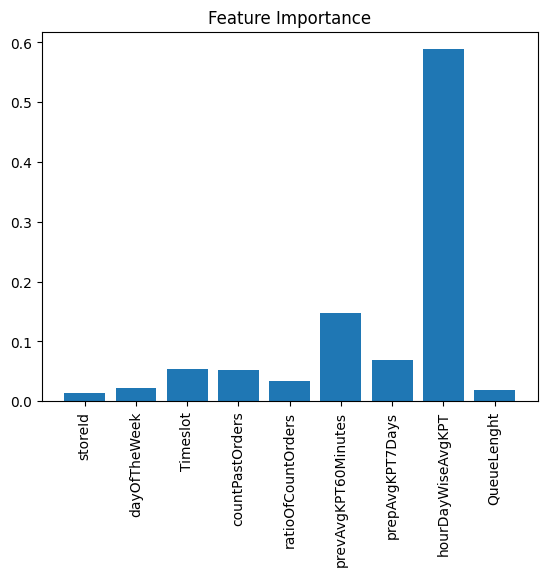

1.0000000325962901


In [41]:
f = ['storeId', 'dayOfTheWeek', 'Timeslot', 'countPastOrders', 'ratioOfCountOrders', 'prevAvgKPT60Minutes', 'prepAvgKPT7Days', 'hourDayWiseAvgKPT', 'QueueLenght']
pyplot.bar(f, best_regressor.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.title("Feature Importance")
pyplot.show()
print(sum(best_regressor.feature_importances_))

In [42]:
allDays = overallDF.Order_Date.unique()
for storeId in allStoreIds:
    df = overallDF.loc[overallDF['Location_Code'] == storeId]
    diffs = []
    for day in allDays:
        df2 = df.loc[df['Order_Date'] == day]
        timeslots = df2.feature_3.unique()
        for ts in sorted(timeslots):
            df3 = df2.loc[df2['feature_3'] == ts]
            l1 = df3.prep_time.values.tolist()
            l2 = df3.predicted_prep_time_central.values.tolist()
            l3 = df3.hour_wise_avg_kpt_of_the_day.values.tolist()
            rmseModel = getRMSE(l1, l2)
            rmseBaseline = getRMSE(l1, l3)
#             print(f"{day} \t {ts} \t {rmseModel} \t {rmseBaseline}")
            diffs.append(rmseModel-rmseBaseline)
# print(sorted(diffs))
diffs = sorted(diffs)
print(f"lowest: {diffs[0]}, highest: {diffs[len(diffs)-1]}, median: {diffs[len(diffs)//2]}")


lowest: -95.21894354620252, highest: 94.85554589471542, median: -3.4842716214818807


In [45]:
def getMAE(actual, predictions):
    mse = sklearn.metrics.mean_absolute_error(actual, predictions)
    return mse

def getSTD(actual, predictions):
    a = []
    for i in range(0, len(actual)):
        a.append(abs(actual[i]-predictions[i]))
    return np.std(a)

def getDayOfTheWeek(a):
    if a==1:
        return "Monday"
    if a==2:
        return "Tuesday"
    if a==3:
        return "Wednesday"
    if a==4:
        return "Thursday"
    if a==5:
        return "Friday"
    if a==6:
        return "Saturday"
    if a==7:
        return "Sunday"

In [84]:
allDays[7:]

array(['2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27',
       '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31'],
      dtype=object)

In [85]:
dfError = pd.DataFrame()
allDays = overallDF.Order_Date.unique()
diffs = []
diffsRMSE = []
diffsFestival = []
dayWiseDiffs = []
for storeId in allStoreIds:
# for i in range(0, 1):
    df = overallDF.loc[overallDF['Location_Code'] == storeId]
    for day in allDays[7:]: # test data only
        df2 = df.loc[df['Order_Date'] == day]
        for ts in sorted(timeslots):
            df3 = df2.loc[df['feature_3'] == ts]
            if(df3.size == 0):
                continue
            rmseModel = getRMSE(df3.prep_time.values.tolist(), df3.predicted_prep_time_central.values.tolist())
            rmseBaseline = getRMSE(df3.prep_time.values.tolist(), df3.hour_wise_avg_kpt_of_the_day.values.tolist())

            maeModel = getMAE(df3.prep_time.values.tolist(), df3.predicted_prep_time_central.values.tolist())
            maeBaseline = getMAE(df3.prep_time.values.tolist(), df3.hour_wise_avg_kpt_of_the_day.values.tolist())
            
            stdModel = getSTD(df3.prep_time.values.tolist(), df3.predicted_prep_time_central.values.tolist())
            stdBaseline = getSTD(df3.prep_time.values.tolist(), df3.hour_wise_avg_kpt_of_the_day.values.tolist())

            weekday = datetime.strptime(day, "%Y-%m-%d").weekday()+1
            a = {"storeId":[storeId], \
                 "date":[day], \
                 "timeslot":ts, \
                 "weekday": [getDayOfTheWeek(weekday)], \
                 "total_orders":[df3.size], \
                 "mean_kpt":[np.mean(df3.prep_time.values.tolist())], \
                 "std_kpt":[np.std(df3.prep_time.values.tolist())], \
                 "model rmse": [rmseModel], \
                 "baseline rmse": [rmseBaseline], \
                 "model mae": [maeModel], \
                 "baseline mae": [maeBaseline], \
                 "model std AE": [stdModel], \
                 "baseline std AE": [stdBaseline]
                }
            diffs.append(maeModel-maeBaseline)
            diffsRMSE.append(rmseModel-rmseBaseline)
            if (a["std_kpt"][0] > 100):
                diffsFestival.append(maeModel-maeBaseline)
            print(a)
            b = pd.DataFrame(a)
            dfError = pd.concat([dfError, b], ignore_index= True)
        
        

{'storeId': ['DPI67255'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [200], 'mean_kpt': [53.999249999999996], 'std_kpt': [17.272136128386087], 'model rmse': [42.203323602502834], 'baseline rmse': [40.15277004871982], 'model mae': [36.52315371704101], 'baseline mae': [33.12857712599901], 'model std AE': [21.146625396477937], 'baseline std AE': [22.687933360976437]}
{'storeId': ['DPI67255'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [75], 'mean_kpt': [34.727666666666664], 'std_kpt': [2.0441111080912933], 'model rmse': [42.48044983135032], 'baseline rmse': [37.625757370636244], 'model mae': [42.47271683756511], 'baseline mae': [37.60954186507936], 'model std AE': [0.8105197776027883], 'baseline std AE': [1.1045263296231365]}
{'storeId': ['DPI67255'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [950], 'mean_kpt': [136.24805263157896], 'std_kpt': [78.24721729403792], 'model rmse

{'storeId': ['DPI67255'], 'date': ['2021-12-30'], 'timeslot': 15.0, 'weekday': ['Thursday'], 'total_orders': [825], 'mean_kpt': [69.16266666666668], 'std_kpt': [44.22101724065131], 'model rmse': [64.7272921701297], 'baseline rmse': [64.33938605122977], 'model mae': [59.012857971191416], 'baseline mae': [59.38046637358192], 'model std AE': [26.59144497294807], 'baseline std AE': [24.76927150129948]}
{'storeId': ['DPI67255'], 'date': ['2021-12-30'], 'timeslot': 16.0, 'weekday': ['Thursday'], 'total_orders': [525], 'mean_kpt': [68.19757142857142], 'std_kpt': [64.8728121433606], 'model rmse': [64.75601779213447], 'baseline rmse': [65.64026744140261], 'model mae': [60.64925121779669], 'baseline mae': [57.37155795076507], 'model std AE': [22.69383544083773], 'baseline std AE': [31.892774229923397]}
{'storeId': ['DPI67255'], 'date': ['2021-12-30'], 'timeslot': 17.0, 'weekday': ['Thursday'], 'total_orders': [100], 'mean_kpt': [159.445], 'std_kpt': [82.80731778955287], 'model rmse': [125.020375

{'storeId': ['DPI67233'], 'date': ['2021-12-26'], 'timeslot': 21.0, 'weekday': ['Sunday'], 'total_orders': [3125], 'mean_kpt': [243.254368], 'std_kpt': [161.06017249957412], 'model rmse': [174.96334841262527], 'baseline rmse': [167.4336092468674], 'model mae': [152.54482373925785], 'baseline mae': [148.22518501046287], 'model std AE': [85.68693038098907], 'baseline std AE': [77.86724622103151]}
{'storeId': ['DPI67233'], 'date': ['2021-12-27'], 'timeslot': 12.0, 'weekday': ['Monday'], 'total_orders': [325], 'mean_kpt': [19.846846153846155], 'std_kpt': [8.289340605177173], 'model rmse': [30.611669797193617], 'baseline rmse': [23.15392002807486], 'model mae': [29.47070362501878], 'baseline mae': [21.91107523860463], 'model std AE': [8.279610837395722], 'baseline std AE': [7.483902361381605]}
{'storeId': ['DPI67233'], 'date': ['2021-12-27'], 'timeslot': 13.0, 'weekday': ['Monday'], 'total_orders': [775], 'mean_kpt': [56.661903225806455], 'std_kpt': [34.64926481494869], 'model rmse': [35.22

{'storeId': ['DPI67227'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [275], 'mean_kpt': [68.21718181818181], 'std_kpt': [48.721966865467046], 'model rmse': [51.49280400599257], 'baseline rmse': [50.140584804821664], 'model mae': [46.84707937344638], 'baseline mae': [44.99371561337238], 'model std AE': [21.374284048303917], 'baseline std AE': [22.127896417700526]}
{'storeId': ['DPI67227'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [150], 'mean_kpt': [64.905], 'std_kpt': [39.03025525153532], 'model rmse': [56.13312214819004], 'baseline rmse': [65.90249869174265], 'model mae': [49.43087585449219], 'baseline mae': [57.2464298167805], 'model std AE': [26.59917130967437], 'baseline std AE': [32.649435018811104]}
{'storeId': ['DPI67227'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [625], 'mean_kpt': [55.623360000000005], 'std_kpt': [26.978669614167412], 'model rmse': [31.35187324

{'storeId': ['DPI67227'], 'date': ['2021-12-30'], 'timeslot': 15.0, 'weekday': ['Thursday'], 'total_orders': [925], 'mean_kpt': [98.0278918918919], 'std_kpt': [42.091895337100155], 'model rmse': [53.990423104896315], 'baseline rmse': [49.54353558974541], 'model mae': [43.03418043311866], 'baseline mae': [39.79398892962159], 'model std AE': [32.60406572032863], 'baseline std AE': [29.51271529021898]}
{'storeId': ['DPI67227'], 'date': ['2021-12-30'], 'timeslot': 16.0, 'weekday': ['Thursday'], 'total_orders': [725], 'mean_kpt': [47.26627586206897], 'std_kpt': [33.174341718798644], 'model rmse': [78.85162753442509], 'baseline rmse': [73.39475502500143], 'model mae': [72.46879630674164], 'baseline mae': [67.1397845193027], 'model std AE': [31.078171224827468], 'baseline std AE': [29.648598615812766]}
{'storeId': ['DPI67227'], 'date': ['2021-12-30'], 'timeslot': 17.0, 'weekday': ['Thursday'], 'total_orders': [400], 'mean_kpt': [106.7504375], 'std_kpt': [40.37047438563354], 'model rmse': [42.

{'storeId': ['DPI67177'], 'date': ['2021-12-27'], 'timeslot': 13.0, 'weekday': ['Monday'], 'total_orders': [100], 'mean_kpt': [134.20025], 'std_kpt': [53.100427650702585], 'model rmse': [73.20375093872737], 'baseline rmse': [70.76731289655785], 'model mae': [57.69327885437012], 'baseline mae': [55.395173863636366], 'model std AE': [45.058569956570054], 'baseline std AE': [44.038475078240644]}
{'storeId': ['DPI67177'], 'date': ['2021-12-27'], 'timeslot': 14.0, 'weekday': ['Monday'], 'total_orders': [550], 'mean_kpt': [121.35431818181816], 'std_kpt': [33.63309105815332], 'model rmse': [36.914381748183985], 'baseline rmse': [34.678761550649575], 'model mae': [30.020863763982607], 'baseline mae': [29.861164203750413], 'model std AE': [21.480673143899747], 'baseline std AE': [17.63313287772386]}
{'storeId': ['DPI67177'], 'date': ['2021-12-27'], 'timeslot': 15.0, 'weekday': ['Monday'], 'total_orders': [750], 'mean_kpt': [119.83306666666665], 'std_kpt': [34.78774852438075], 'model rmse': [34.

{'storeId': ['DPI67151'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [200], 'mean_kpt': [53.7475], 'std_kpt': [6.799767091599535], 'model rmse': [24.157343653464014], 'baseline rmse': [18.000029156893], 'model mae': [23.318038406372068], 'baseline mae': [17.70506392496393], 'model std AE': [6.312395525512886], 'baseline std AE': [3.245267486962984]}
{'storeId': ['DPI67151'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [700], 'mean_kpt': [163.38550000000004], 'std_kpt': [78.83319096742908], 'model rmse': [83.3281846224399], 'baseline rmse': [82.74057162471821], 'model mae': [61.81151227242606], 'baseline mae': [63.346594733818385], 'model std AE': [55.88312180853135], 'baseline std AE': [53.22791681452973]}
{'storeId': ['DPI67151'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1275], 'mean_kpt': [190.36821568627445], 'std_kpt': [106.8889757805924], 'model rmse': [117.117736154

{'storeId': ['DPI67151'], 'date': ['2021-12-30'], 'timeslot': 14.0, 'weekday': ['Thursday'], 'total_orders': [675], 'mean_kpt': [136.53359259259258], 'std_kpt': [89.61564678578189], 'model rmse': [89.73081040731334], 'baseline rmse': [90.43241510789557], 'model mae': [74.92530926513672], 'baseline mae': [76.31877260708924], 'model std AE': [49.37424802340619], 'baseline std AE': [48.5125411619938]}
{'storeId': ['DPI67151'], 'date': ['2021-12-30'], 'timeslot': 15.0, 'weekday': ['Thursday'], 'total_orders': [925], 'mean_kpt': [118.07472972972971], 'std_kpt': [55.357945456548485], 'model rmse': [63.00118556674232], 'baseline rmse': [65.39075264072589], 'model mae': [55.58505350638724], 'baseline mae': [58.731110386521166], 'model std AE': [29.655542643950525], 'baseline std AE': [28.75077744491212]}
{'storeId': ['DPI67151'], 'date': ['2021-12-30'], 'timeslot': 16.0, 'weekday': ['Thursday'], 'total_orders': [600], 'mean_kpt': [92.76404166666667], 'std_kpt': [63.38799155694447], 'model rmse

{'storeId': ['DPI67150'], 'date': ['2021-12-26'], 'timeslot': 21.0, 'weekday': ['Sunday'], 'total_orders': [600], 'mean_kpt': [32.179916666666664], 'std_kpt': [26.922176329680127], 'model rmse': [60.710400952117574], 'baseline rmse': [66.46668313021716], 'model mae': [57.22881090037027], 'baseline mae': [63.65628335038417], 'model std AE': [20.26366172972047], 'baseline std AE': [19.123220344604572]}
{'storeId': ['DPI67150'], 'date': ['2021-12-27'], 'timeslot': 13.0, 'weekday': ['Monday'], 'total_orders': [200], 'mean_kpt': [34.922875000000005], 'std_kpt': [26.164642886142648], 'model rmse': [28.172063114174225], 'baseline rmse': [27.90780589494194], 'model mae': [19.943318431854248], 'baseline mae': [19.855932882395383], 'model std AE': [19.897969495269574], 'baseline std AE': [19.610904090315827]}
{'storeId': ['DPI67150'], 'date': ['2021-12-27'], 'timeslot': 14.0, 'weekday': ['Monday'], 'total_orders': [1075], 'mean_kpt': [36.01720930232558], 'std_kpt': [26.85645677036564], 'model rm

{'storeId': ['DPI67132'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [225], 'mean_kpt': [65.55355555555555], 'std_kpt': [18.600694002053384], 'model rmse': [19.403827247871096], 'baseline rmse': [25.913759759124858], 'model mae': [15.366417188856335], 'baseline mae': [22.384104497354496], 'model std AE': [11.84827981789953], 'baseline std AE': [13.056600273622264]}
{'storeId': ['DPI67132'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [875], 'mean_kpt': [136.1579142857143], 'std_kpt': [69.46796065252833], 'model rmse': [81.37003639854119], 'baseline rmse': [81.36228526026164], 'model mae': [63.94882677873883], 'baseline mae': [64.31965859261385], 'model std AE': [50.31530956997851], 'baseline std AE': [49.82773305401101]}
{'storeId': ['DPI67132'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1950], 'mean_kpt': [140.38423076923075], 'std_kpt': [68.44276298089935], 'model rmse':

{'storeId': ['DPI67132'], 'date': ['2021-12-30'], 'timeslot': 13.0, 'weekday': ['Thursday'], 'total_orders': [925], 'mean_kpt': [91.44021621621621], 'std_kpt': [25.41542507169361], 'model rmse': [30.110033146722415], 'baseline rmse': [32.25046185456599], 'model mae': [19.423005918760552], 'baseline mae': [21.25854596901145], 'model std AE': [23.007845122403683], 'baseline std AE': [24.252144505512145]}
{'storeId': ['DPI67132'], 'date': ['2021-12-30'], 'timeslot': 14.0, 'weekday': ['Thursday'], 'total_orders': [525], 'mean_kpt': [67.79828571428571], 'std_kpt': [27.574914644158977], 'model rmse': [29.813696927099976], 'baseline rmse': [32.1241274950552], 'model mae': [26.346690185546873], 'baseline mae': [27.58223504882515], 'model std AE': [13.953796642053318], 'baseline std AE': [16.467540102575203]}
{'storeId': ['DPI67132'], 'date': ['2021-12-30'], 'timeslot': 15.0, 'weekday': ['Thursday'], 'total_orders': [1350], 'mean_kpt': [67.25892592592592], 'std_kpt': [25.647352517944192], 'mode

{'storeId': ['DPI67089'], 'date': ['2021-12-26'], 'timeslot': 18.0, 'weekday': ['Sunday'], 'total_orders': [1200], 'mean_kpt': [91.35577083333334], 'std_kpt': [39.61381228931793], 'model rmse': [39.039582448746685], 'baseline rmse': [41.50816062942403], 'model mae': [34.01724335098267], 'baseline mae': [36.69248892033293], 'model std AE': [19.155055535615542], 'baseline std AE': [19.405892292530964]}
{'storeId': ['DPI67089'], 'date': ['2021-12-26'], 'timeslot': 19.0, 'weekday': ['Sunday'], 'total_orders': [1925], 'mean_kpt': [82.74183116883117], 'std_kpt': [40.316748356116925], 'model rmse': [100.8052485406544], 'baseline rmse': [92.54821750786958], 'model mae': [94.57536001705813], 'baseline mae': [84.80910075081673], 'model std AE': [34.888385044122465], 'baseline std AE': [37.04846816970649]}
{'storeId': ['DPI67089'], 'date': ['2021-12-26'], 'timeslot': 20.0, 'weekday': ['Sunday'], 'total_orders': [2600], 'mean_kpt': [151.89578846153847], 'std_kpt': [76.75080379467259], 'model rmse'

{'storeId': ['DPI67077'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [150], 'mean_kpt': [68.58916666666667], 'std_kpt': [28.120264866087037], 'model rmse': [29.680595312431304], 'baseline rmse': [33.44876263499281], 'model mae': [29.015098093668616], 'baseline mae': [32.23997478956229], 'model std AE': [6.249945656972277], 'baseline std AE': [8.910878036449537]}
{'storeId': ['DPI67077'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [275], 'mean_kpt': [132.4487272727273], 'std_kpt': [34.8758996263007], 'model rmse': [60.827519088471625], 'baseline rmse': [53.270017538549425], 'model mae': [54.70826157171076], 'baseline mae': [48.1355532331305], 'model std AE': [26.58934362220429], 'baseline std AE': [22.818047320001387]}
{'storeId': ['DPI67077'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [225], 'mean_kpt': [80.45644444444444], 'std_kpt': [28.069450681839978], 'model rmse': [2

{'storeId': ['DPI67077'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [550], 'mean_kpt': [137.72713636363633], 'std_kpt': [57.907621940070484], 'model rmse': [66.12822686577589], 'baseline rmse': [61.38765403458029], 'model mae': [50.4858654202548], 'baseline mae': [44.36961305994397], 'model std AE': [42.709715302018154], 'baseline std AE': [42.42383180218604]}
{'storeId': ['DPI67077'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [725], 'mean_kpt': [76.2431724137931], 'std_kpt': [39.27042232333429], 'model rmse': [37.6332455516775], 'baseline rmse': [39.889413416844924], 'model mae': [29.0812715327822], 'baseline mae': [30.274524316153027], 'model std AE': [23.885996248627492], 'baseline std AE': [25.97341872319905]}
{'storeId': ['DPI67077'], 'date': ['2021-12-31'], 'timeslot': 15.0, 'weekday': ['Friday'], 'total_orders': [675], 'mean_kpt': [104.42074074074073], 'std_kpt': [42.69726474246729], 'model rmse': [55.

{'storeId': ['DPI67065'], 'date': ['2021-12-27'], 'timeslot': 15.0, 'weekday': ['Monday'], 'total_orders': [1050], 'mean_kpt': [29.460166666666666], 'std_kpt': [18.702133074059798], 'model rmse': [29.408236091933173], 'baseline rmse': [19.019119971348108], 'model mae': [25.76516718328567], 'baseline mae': [14.704311119313687], 'model std AE': [14.177464867042355], 'baseline std AE': [12.062759178188065]}
{'storeId': ['DPI67065'], 'date': ['2021-12-27'], 'timeslot': 16.0, 'weekday': ['Monday'], 'total_orders': [1425], 'mean_kpt': [58.79501754385964], 'std_kpt': [44.68164153854063], 'model rmse': [44.06846587045124], 'baseline rmse': [47.297250417977494], 'model mae': [33.92199136673777], 'baseline mae': [31.80156491397586], 'model std AE': [28.130556089243854], 'baseline std AE': [35.00986098405779]}
{'storeId': ['DPI67065'], 'date': ['2021-12-27'], 'timeslot': 17.0, 'weekday': ['Monday'], 'total_orders': [1325], 'mean_kpt': [88.35950943396226], 'std_kpt': [57.577532098482635], 'model r

{'storeId': ['DPI67061'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [275], 'mean_kpt': [58.60218181818181], 'std_kpt': [40.4774871004481], 'model rmse': [43.66050806597747], 'baseline rmse': [42.63243760500831], 'model mae': [38.76471096524325], 'baseline mae': [37.55235068398625], 'model std AE': [20.08823407769914], 'baseline std AE': [20.18280689725404]}
{'storeId': ['DPI67061'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [550], 'mean_kpt': [159.90695454545454], 'std_kpt': [187.7727610363793], 'model rmse': [201.62851958003398], 'baseline rmse': [202.21378716795476], 'model mae': [136.24624688165838], 'baseline mae': [143.169426037369], 'model std AE': [148.63048179528428], 'baseline std AE': [142.80382056841907]}
{'storeId': ['DPI67061'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [775], 'mean_kpt': [53.512903225806454], 'std_kpt': [21.221829262547075], 'model rmse': [

{'storeId': ['DPI67061'], 'date': ['2021-12-30'], 'timeslot': 17.0, 'weekday': ['Thursday'], 'total_orders': [700], 'mean_kpt': [75.02671428571428], 'std_kpt': [41.79419669887294], 'model rmse': [43.9400251948999], 'baseline rmse': [42.796272308199775], 'model mae': [34.491183033534455], 'baseline mae': [34.72002866313549], 'model std AE': [27.222860009111148], 'baseline std AE': [25.020802007702258]}
{'storeId': ['DPI67061'], 'date': ['2021-12-30'], 'timeslot': 18.0, 'weekday': ['Thursday'], 'total_orders': [1200], 'mean_kpt': [100.49904166666668], 'std_kpt': [42.9578264405715], 'model rmse': [46.57637797776833], 'baseline rmse': [46.803607681646675], 'model mae': [39.70305064646403], 'baseline mae': [40.18461631228788], 'model std AE': [24.35214066344589], 'baseline std AE': [23.99529753621952]}
{'storeId': ['DPI67061'], 'date': ['2021-12-30'], 'timeslot': 19.0, 'weekday': ['Thursday'], 'total_orders': [2250], 'mean_kpt': [113.12016666666668], 'std_kpt': [57.76964523350958], 'model r

{'storeId': ['DPI67060'], 'date': ['2021-12-27'], 'timeslot': 18.0, 'weekday': ['Monday'], 'total_orders': [825], 'mean_kpt': [72.06733333333334], 'std_kpt': [46.66088422746497], 'model rmse': [46.91757478934875], 'baseline rmse': [47.67009542374352], 'model mae': [39.858454898718634], 'baseline mae': [35.35762626889036], 'model std AE': [24.749997923251335], 'baseline std AE': [31.973055254984423]}
{'storeId': ['DPI67060'], 'date': ['2021-12-27'], 'timeslot': 19.0, 'weekday': ['Monday'], 'total_orders': [1575], 'mean_kpt': [151.1041746031746], 'std_kpt': [69.7244675788922], 'model rmse': [69.95853311120091], 'baseline rmse': [82.38575421413387], 'model mae': [59.745732192266544], 'baseline mae': [72.6532288633569], 'model std AE': [36.39565688211928], 'baseline std AE': [38.84483019862949]}
{'storeId': ['DPI67060'], 'date': ['2021-12-27'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [1675], 'mean_kpt': [113.13720895522388], 'std_kpt': [49.451493965793134], 'model rmse': [

{'storeId': ['DPI67055'], 'date': ['2021-12-24'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [775], 'mean_kpt': [161.51735483870968], 'std_kpt': [120.03408871503245], 'model rmse': [124.359037639252], 'baseline rmse': [123.37379723287155], 'model mae': [112.58271814752395], 'baseline mae': [111.17975061548863], 'model std AE': [52.82330751738361], 'baseline std AE': [53.48043470967173]}
{'storeId': ['DPI67055'], 'date': ['2021-12-25'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [150], 'mean_kpt': [48.020999999999994], 'std_kpt': [19.71078955800604], 'model rmse': [36.700046871971786], 'baseline rmse': [51.84613621216033], 'model mae': [28.122798487345378], 'baseline mae': [39.78188025074215], 'model std AE': [23.579687140526072], 'baseline std AE': [33.24791487966568]}
{'storeId': ['DPI67055'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [500], 'mean_kpt': [156.62245], 'std_kpt': [83.13827650034308], 'model rmse': [10

{'storeId': ['DPI67018'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [175], 'mean_kpt': [41.96185714285714], 'std_kpt': [15.181716921806885], 'model rmse': [14.890327873439677], 'baseline rmse': [17.174291750640695], 'model mae': [14.164062290736606], 'baseline mae': [12.414864909297048], 'model std AE': [4.593604641528028], 'baseline std AE': [11.867073203618062]}
{'storeId': ['DPI67018'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [350], 'mean_kpt': [60.427214285714285], 'std_kpt': [29.297234930910097], 'model rmse': [28.613558737564322], 'baseline rmse': [31.177315309343932], 'model mae': [22.682696908133376], 'baseline mae': [25.360765651656013], 'model std AE': [17.442219027457494], 'baseline std AE': [18.1344025393735]}
{'storeId': ['DPI67018'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [950], 'mean_kpt': [39.27565789473684], 'std_kpt': [34.85280504476256], 'model rm

{'storeId': ['DPI67018'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1075], 'mean_kpt': [185.77034883720927], 'std_kpt': [112.9153969608742], 'model rmse': [144.17510158251085], 'baseline rmse': [150.54836583061774], 'model mae': [118.33803032879497], 'baseline mae': [125.00102246015093], 'model std AE': [82.35636280354132], 'baseline std AE': [83.9020550295781]}
{'storeId': ['DPI67018'], 'date': ['2021-12-31'], 'timeslot': 15.0, 'weekday': ['Friday'], 'total_orders': [1900], 'mean_kpt': [128.47398684210526], 'std_kpt': [59.8074959297027], 'model rmse': [63.36175294577872], 'baseline rmse': [68.6715840139865], 'model mae': [52.404311957108355], 'baseline mae': [56.34975189940446], 'model std AE': [35.61600517553828], 'baseline std AE': [39.24910077779578]}
{'storeId': ['DPI67018'], 'date': ['2021-12-31'], 'timeslot': 16.0, 'weekday': ['Friday'], 'total_orders': [1500], 'mean_kpt': [63.306066666666666], 'std_kpt': [37.46859150224655], 'model rmse':

{'storeId': ['DPI66955'], 'date': ['2021-12-28'], 'timeslot': 15.0, 'weekday': ['Tuesday'], 'total_orders': [900], 'mean_kpt': [29.204694444444442], 'std_kpt': [16.661434793524176], 'model rmse': [36.352204796272076], 'baseline rmse': [30.96868924195695], 'model mae': [32.8037489988539], 'baseline mae': [27.364958332397745], 'model std AE': [15.665147467237542], 'baseline std AE': [14.498923023143321]}
{'storeId': ['DPI66955'], 'date': ['2021-12-28'], 'timeslot': 16.0, 'weekday': ['Tuesday'], 'total_orders': [1325], 'mean_kpt': [37.59518867924528], 'std_kpt': [16.217908852540326], 'model rmse': [19.148102919311373], 'baseline rmse': [16.36173480211433], 'model mae': [15.881299463811912], 'baseline mae': [11.411470701275126], 'model std AE': [10.697390931870641], 'baseline std AE': [11.725387079694158]}
{'storeId': ['DPI66955'], 'date': ['2021-12-28'], 'timeslot': 17.0, 'weekday': ['Tuesday'], 'total_orders': [1650], 'mean_kpt': [57.704439393939396], 'std_kpt': [48.02958286752181], 'mod

{'storeId': ['DPI66954'], 'date': ['2021-12-25'], 'timeslot': 17.0, 'weekday': ['Saturday'], 'total_orders': [2800], 'mean_kpt': [91.15942857142856], 'std_kpt': [63.041142234472886], 'model rmse': [61.70108600619721], 'baseline rmse': [63.285382622480306], 'model mae': [50.26431664875575], 'baseline mae': [49.06420729510192], 'model std AE': [35.78438886131437], 'baseline std AE': [39.97178024778231]}
{'storeId': ['DPI66954'], 'date': ['2021-12-25'], 'timeslot': 18.0, 'weekday': ['Saturday'], 'total_orders': [3300], 'mean_kpt': [164.83989393939396], 'std_kpt': [76.01804597058333], 'model rmse': [82.31855954816943], 'baseline rmse': [85.04034660695554], 'model mae': [55.8879963388154], 'baseline mae': [60.444583833687], 'model std AE': [60.439036320229924], 'baseline std AE': [59.819000628592256]}
{'storeId': ['DPI66954'], 'date': ['2021-12-25'], 'timeslot': 19.0, 'weekday': ['Saturday'], 'total_orders': [2950], 'mean_kpt': [169.21474576271189], 'std_kpt': [59.71473128106047], 'model rm

{'storeId': ['DPI66942'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [300], 'mean_kpt': [84.65533333333333], 'std_kpt': [27.017122577892874], 'model rmse': [27.197506106541297], 'baseline rmse': [29.073539233608212], 'model mae': [18.933186813354492], 'baseline mae': [18.927941606657235], 'model std AE': [19.525336757812163], 'baseline std AE': [22.068160550964144]}
{'storeId': ['DPI66942'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [325], 'mean_kpt': [75.52684615384615], 'std_kpt': [16.65923947772921], 'model rmse': [18.601520569967533], 'baseline rmse': [17.05810964906664], 'model mae': [12.905010944073016], 'baseline mae': [12.776613759182558], 'model std AE': [13.396912332633997], 'baseline std AE': [11.302090322070837]}
{'storeId': ['DPI66942'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [575], 'mean_kpt': [81.152], 'std_kpt': [41.393337768923324], 'model rmse': [41.2

{'storeId': ['DPI66942'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [350], 'mean_kpt': [61.713071428571425], 'std_kpt': [25.743503786570773], 'model rmse': [30.104470024653036], 'baseline rmse': [30.197959146025713], 'model mae': [26.717271052769256], 'baseline mae': [26.97679975826006], 'model std AE': [13.873231165020332], 'baseline std AE': [13.570888378723708]}
{'storeId': ['DPI66942'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [800], 'mean_kpt': [69.59065625], 'std_kpt': [22.937421826310075], 'model rmse': [24.445829814743387], 'baseline rmse': [23.8894167904562], 'model mae': [19.26099835205078], 'baseline mae': [18.95517247492626], 'model std AE': [15.05365529742507], 'baseline std AE': [14.539796113905043]}
{'storeId': ['DPI66942'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [575], 'mean_kpt': [72.4166956521739], 'std_kpt': [37.56557928700477], 'model rmse': [37.8

{'storeId': ['DPI66936'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [400], 'mean_kpt': [25.9455], 'std_kpt': [15.85546816953066], 'model rmse': [38.71428159434575], 'baseline rmse': [32.97156667201193], 'model mae': [35.83647489356995], 'baseline mae': [30.82848172734933], 'model std AE': [14.64727505609248], 'baseline std AE': [11.693114349625446]}
{'storeId': ['DPI66936'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [450], 'mean_kpt': [37.10616666666667], 'std_kpt': [10.47122126619219], 'model rmse': [22.728815077272937], 'baseline rmse': [15.834929006279374], 'model mae': [20.042870164659288], 'baseline mae': [12.664382198550861], 'model std AE': [10.71832031521172], 'baseline std AE': [9.505703559597048]}
{'storeId': ['DPI66936'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [1125], 'mean_kpt': [57.07395555555554], 'std_kpt': [38.45975240860708], 'model rmse': [38.0718

{'storeId': ['DPI66919'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [1500], 'mean_kpt': [290.47175000000004], 'std_kpt': [164.60471195489566], 'model rmse': [194.41661875051736], 'baseline rmse': [200.17798844320524], 'model mae': [157.75086186828614], 'baseline mae': [161.71316682677133], 'model std AE': [113.63312556731388], 'baseline std AE': [117.98338328775299]}
{'storeId': ['DPI66919'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [1575], 'mean_kpt': [208.0845714285714], 'std_kpt': [102.71846819104506], 'model rmse': [120.77493559797328], 'baseline rmse': [128.83080772124944], 'model mae': [93.48206123860676], 'baseline mae': [97.18737393104291], 'model std AE': [76.47018566262257], 'baseline std AE': [84.56944700361463]}
{'storeId': ['DPI66919'], 'date': ['2021-12-25'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [1825], 'mean_kpt': [159.88835616438357], 'std_kpt': [96.77732377471716], 

{'storeId': ['DPI66756'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [125], 'mean_kpt': [57.084199999999996], 'std_kpt': [20.227197427226542], 'model rmse': [24.19915819890677], 'baseline rmse': [26.33963776109023], 'model mae': [12.794985485839844], 'baseline mae': [12.638144841269842], 'model std AE': [20.539902725009785], 'baseline std AE': [23.10960433145784]}
{'storeId': ['DPI66756'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [300], 'mean_kpt': [47.918], 'std_kpt': [27.188655504946666], 'model rmse': [37.055754937659806], 'baseline rmse': [34.50672472957883], 'model mae': [33.79609934743245], 'baseline mae': [32.56214627945919], 'model std AE': [15.197126139450672], 'baseline std AE': [11.420187443209043]}
{'storeId': ['DPI66756'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [975], 'mean_kpt': [85.75387179487178], 'std_kpt': [36.84947258167566], 'model rmse': [37.24884

{'storeId': ['DPI66756'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [100], 'mean_kpt': [116.65325], 'std_kpt': [32.66128100193714], 'model rmse': [56.72836081961947], 'baseline rmse': [55.79476295908534], 'model mae': [46.24292742919921], 'baseline mae': [46.650393772893764], 'model std AE': [32.8587672327912], 'baseline std AE': [30.607128818209578]}
{'storeId': ['DPI66756'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [500], 'mean_kpt': [121.69185], 'std_kpt': [49.94790340171947], 'model rmse': [66.57107562596812], 'baseline rmse': [68.35689841037123], 'model mae': [53.43180917968751], 'baseline mae': [55.418244696180274], 'model std AE': [39.70830993361251], 'baseline std AE': [40.018542140863914]}
{'storeId': ['DPI66756'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1725], 'mean_kpt': [134.63459420289854], 'std_kpt': [82.06079527042763], 'model rmse': [90.61020271381247

{'storeId': ['DPI66718'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [375], 'mean_kpt': [117.84726666666668], 'std_kpt': [32.52874933443064], 'model rmse': [44.15927748909449], 'baseline rmse': [42.775192664392534], 'model mae': [34.25762443440755], 'baseline mae': [38.37465233118735], 'model std AE': [27.864977237922346], 'baseline std AE': [18.897173490667818]}
{'storeId': ['DPI66718'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [300], 'mean_kpt': [51.139083333333325], 'std_kpt': [38.371823079047495], 'model rmse': [73.61441245793445], 'baseline rmse': [86.3506422837361], 'model mae': [65.38467269388836], 'baseline mae': [77.9811137614689], 'model std AE': [33.82197951391946], 'baseline std AE': [37.086106823642126]}
{'storeId': ['DPI66718'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [950], 'mean_kpt': [119.82650000000001], 'std_kpt': [66.84946438857587], 'model rmse'

{'storeId': ['DPI66700'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [925], 'mean_kpt': [98.52664864864866], 'std_kpt': [60.369592668699205], 'model rmse': [66.84517600840614], 'baseline rmse': [74.30087057716416], 'model mae': [53.970763667751], 'baseline mae': [60.36156506120297], 'model std AE': [39.43899370818892], 'baseline std AE': [43.32552171511221]}
{'storeId': ['DPI66700'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [1825], 'mean_kpt': [91.84453424657535], 'std_kpt': [56.3968690720109], 'model rmse': [60.18886530660089], 'baseline rmse': [66.39509972568038], 'model mae': [47.28846771491064], 'baseline mae': [50.57107841506622], 'model std AE': [37.235739929159436], 'baseline std AE': [43.02180023569756]}
{'storeId': ['DPI66700'], 'date': ['2021-12-25'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [3075], 'mean_kpt': [97.40235772357725], 'std_kpt': [51.26811912298538], 'model rmse': 

{'storeId': ['DPI66642'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [200], 'mean_kpt': [77.648625], 'std_kpt': [45.76508817848355], 'model rmse': [49.82560220279215], 'baseline rmse': [51.35689862822991], 'model mae': [40.67442413330079], 'baseline mae': [42.91601031746032], 'model std AE': [28.77814893795716], 'baseline std AE': [28.20898961575764]}
{'storeId': ['DPI66642'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [300], 'mean_kpt': [56.14099999999999], 'std_kpt': [27.700437953818227], 'model rmse': [69.05506336035849], 'baseline rmse': [107.36347789562849], 'model mae': [64.4678809967041], 'baseline mae': [103.7808540043968], 'model std AE': [24.748618052285753], 'baseline std AE': [27.503649357188756]}
{'storeId': ['DPI66642'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [350], 'mean_kpt': [63.876285714285714], 'std_kpt': [51.82149762602468], 'model rmse': [60.8913284

{'storeId': ['DPI66642'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [300], 'mean_kpt': [105.95325000000001], 'std_kpt': [45.05688437247039], 'model rmse': [50.69738990814058], 'baseline rmse': [52.70198234337508], 'model mae': [44.17283957417806], 'baseline mae': [51.09645561457507], 'model std AE': [24.87942096295577], 'baseline std AE': [12.909344156430949]}
{'storeId': ['DPI66642'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [2500], 'mean_kpt': [191.92273999999998], 'std_kpt': [100.20985966426856], 'model rmse': [108.37940960410022], 'baseline rmse': [113.09611539708614], 'model mae': [66.58215614807129], 'baseline mae': [73.82694130375306], 'model std AE': [85.51557114822528], 'baseline std AE': [85.67563279978286]}
{'storeId': ['DPI66642'], 'date': ['2021-12-31'], 'timeslot': 15.0, 'weekday': ['Friday'], 'total_orders': [1425], 'mean_kpt': [158.113], 'std_kpt': [68.97102488726698], 'model rmse': [88.54955

{'storeId': ['DPI66633'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [475], 'mean_kpt': [65.05115789473685], 'std_kpt': [31.322594577721883], 'model rmse': [34.04155890521855], 'baseline rmse': [36.840826643581806], 'model mae': [28.328763448614826], 'baseline mae': [28.80650353067053], 'model std AE': [18.87614616837583], 'baseline std AE': [22.965884744984546]}
{'storeId': ['DPI66633'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [675], 'mean_kpt': [74.22759259259259], 'std_kpt': [31.953950307300452], 'model rmse': [33.13614174321302], 'baseline rmse': [35.85411454616947], 'model mae': [31.30073209974501], 'baseline mae': [33.012854626663135], 'model std AE': [10.875111937184673], 'baseline std AE': [13.988172121068859]}
{'storeId': ['DPI66633'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [900], 'mean_kpt': [89.43358333333333], 'std_kpt': [51.25207171442763], 'model rms

{'storeId': ['DPI66632'], 'date': ['2021-12-25'], 'timeslot': 21.0, 'weekday': ['Saturday'], 'total_orders': [5525], 'mean_kpt': [190.68704977375566], 'std_kpt': [102.23822083724778], 'model rmse': [114.32845559983345], 'baseline rmse': [112.1796180286871], 'model mae': [98.30415559711714], 'baseline mae': [92.83924613727265], 'model std AE': [58.37198602224242], 'baseline std AE': [62.96936618487633]}
{'storeId': ['DPI66632'], 'date': ['2021-12-26'], 'timeslot': 12.0, 'weekday': ['Sunday'], 'total_orders': [200], 'mean_kpt': [105.7585], 'std_kpt': [40.650692011329895], 'model rmse': [42.527364941567825], 'baseline rmse': [54.71814585016765], 'model mae': [37.83829499053955], 'baseline mae': [49.24189746601323], 'model std AE': [19.412372371304897], 'baseline std AE': [23.860239295255607]}
{'storeId': ['DPI66632'], 'date': ['2021-12-26'], 'timeslot': 13.0, 'weekday': ['Sunday'], 'total_orders': [350], 'mean_kpt': [50.031642857142856], 'std_kpt': [25.70877505724218], 'model rmse': [46.9

{'storeId': ['DPI66611'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [75], 'mean_kpt': [28.644666666666666], 'std_kpt': [5.844032017556219], 'model rmse': [11.380919408828621], 'baseline rmse': [9.745774952083934], 'model mae': [9.900005981445315], 'baseline mae': [9.316166666666666], 'model std AE': [5.613840767032762], 'baseline std AE': [2.8616722481017196]}
{'storeId': ['DPI66611'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [350], 'mean_kpt': [69.69685714285716], 'std_kpt': [44.553290091525135], 'model rmse': [45.83613235357233], 'baseline rmse': [49.9578375035442], 'model mae': [38.35083488246373], 'baseline mae': [36.29847462670814], 'model std AE': [25.103077360200356], 'baseline std AE': [34.32500936350567]}
{'storeId': ['DPI66611'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [3775], 'mean_kpt': [41.16635761589404], 'std_kpt': [48.113002559350676], 'model rmse': [5

{'storeId': ['DPI66611'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [100], 'mean_kpt': [203.0935], 'std_kpt': [113.59352156813347], 'model rmse': [179.39643684501098], 'baseline rmse': [181.8891647756794], 'model mae': [149.5087240753174], 'baseline mae': [153.44631607142858], 'model std AE': [99.14748094660106], 'baseline std AE': [97.66215411765957]}
{'storeId': ['DPI66611'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [850], 'mean_kpt': [123.61826470588234], 'std_kpt': [67.45304800609297], 'model rmse': [81.12698746715371], 'baseline rmse': [82.88983329109185], 'model mae': [62.640285115859086], 'baseline mae': [65.05191411264038], 'model std AE': [51.55368828803228], 'baseline std AE': [51.370934713188326]}
{'storeId': ['DPI66611'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1050], 'mean_kpt': [204.5207857142857], 'std_kpt': [115.67473202589927], 'model rmse': [174.318

{'storeId': ['DPI66602'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [125], 'mean_kpt': [31.1132], 'std_kpt': [3.6809477801240265], 'model rmse': [28.739928954590717], 'baseline rmse': [22.148446702261637], 'model mae': [28.289816662597655], 'baseline mae': [21.545536580086583], 'model std AE': [5.066536243977139], 'baseline std AE': [5.132596301977719]}
{'storeId': ['DPI66602'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [325], 'mean_kpt': [26.545923076923074], 'std_kpt': [15.133914819481232], 'model rmse': [21.32515444777029], 'baseline rmse': [16.543584043485648], 'model mae': [20.37029251568134], 'baseline mae': [11.80507877745055], 'model std AE': [6.30978565775684], 'baseline std AE': [11.59009439400989]}
{'storeId': ['DPI66602'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [475], 'mean_kpt': [52.15210526315789], 'std_kpt': [17.685320430395425], 'model rmse': [31.65

{'storeId': ['DPI66557'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [1950], 'mean_kpt': [188.4985], 'std_kpt': [172.58396667254314], 'model rmse': [179.0854622135649], 'baseline rmse': [176.8680488749963], 'model mae': [79.42919537666516], 'baseline mae': [74.08346769502457], 'model std AE': [160.50733845547919], 'baseline std AE': [160.60493929866644]}
{'storeId': ['DPI66557'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [3075], 'mean_kpt': [251.14290243902434], 'std_kpt': [138.54348276717593], 'model rmse': [145.06138124387041], 'baseline rmse': [165.25478925184365], 'model mae': [106.82630622131845], 'baseline mae': [132.00464090554314], 'model std AE': [98.13737630224593], 'baseline std AE': [99.41790658663993]}
{'storeId': ['DPI66557'], 'date': ['2021-12-25'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [2600], 'mean_kpt': [363.40729807692304], 'std_kpt': [160.19367321247546], 'model rms

{'storeId': ['DPI66535'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [175], 'mean_kpt': [99.43185714285713], 'std_kpt': [34.985986624968135], 'model rmse': [43.60151063288712], 'baseline rmse': [44.24094370631574], 'model mae': [36.24567851911272], 'baseline mae': [37.18069575702076], 'model std AE': [24.235150467015863], 'baseline std AE': [23.976174904459995]}
{'storeId': ['DPI66535'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [300], 'mean_kpt': [31.236583333333332], 'std_kpt': [37.1498539172954], 'model rmse': [56.93658779515954], 'baseline rmse': [55.41963915931366], 'model mae': [55.62017076365152], 'baseline mae': [54.17045096922737], 'model std AE': [12.172577129685985], 'baseline std AE': [11.700369495834941]}
{'storeId': ['DPI66535'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1025], 'mean_kpt': [59.76348780487803], 'std_kpt': [26.247153271073362], 'model rmse': 

{'storeId': ['DPI66535'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [975], 'mean_kpt': [97.88199999999998], 'std_kpt': [43.586111297651705], 'model rmse': [46.19975625112348], 'baseline rmse': [52.88411556227337], 'model mae': [34.88765890268179], 'baseline mae': [40.71297838979029], 'model std AE': [30.286444722901216], 'baseline std AE': [33.75178616660685]}
{'storeId': ['DPI66535'], 'date': ['2021-12-31'], 'timeslot': 15.0, 'weekday': ['Friday'], 'total_orders': [1075], 'mean_kpt': [108.68255813953489], 'std_kpt': [74.33602560726413], 'model rmse': [78.47820197830173], 'baseline rmse': [82.72741792691812], 'model mae': [60.083117526741916], 'baseline mae': [58.72749178163956], 'model std AE': [50.486108723240285], 'baseline std AE': [58.26583377840254]}
{'storeId': ['DPI66535'], 'date': ['2021-12-31'], 'timeslot': 16.0, 'weekday': ['Friday'], 'total_orders': [1725], 'mean_kpt': [145.75055072463766], 'std_kpt': [63.56765614990343], 'model rmse':

{'storeId': ['DPI66505'], 'date': ['2021-12-28'], 'timeslot': 17.0, 'weekday': ['Tuesday'], 'total_orders': [1575], 'mean_kpt': [66.60120634920636], 'std_kpt': [40.16493246647858], 'model rmse': [55.37361780238657], 'baseline rmse': [48.274688535792684], 'model mae': [45.470707547626795], 'baseline mae': [40.51270234556972], 'model std AE': [31.601460466930604], 'baseline std AE': [26.251980913581818]}
{'storeId': ['DPI66505'], 'date': ['2021-12-28'], 'timeslot': 18.0, 'weekday': ['Tuesday'], 'total_orders': [2250], 'mean_kpt': [133.50972222222222], 'std_kpt': [87.93682266049211], 'model rmse': [85.50447577639774], 'baseline rmse': [88.98620795790389], 'model mae': [72.26846486680773], 'baseline mae': [77.3670647947281], 'model std AE': [45.697750093320415], 'baseline std AE': [43.96455949711835]}
{'storeId': ['DPI66505'], 'date': ['2021-12-28'], 'timeslot': 19.0, 'weekday': ['Tuesday'], 'total_orders': [2600], 'mean_kpt': [185.75062499999999], 'std_kpt': [102.75734114633924], 'model r

{'storeId': ['DPI66473'], 'date': ['2021-12-25'], 'timeslot': 19.0, 'weekday': ['Saturday'], 'total_orders': [7400], 'mean_kpt': [600.0698581081082], 'std_kpt': [144.16005643981228], 'model rmse': [298.7109780403584], 'baseline rmse': [306.2162562369191], 'model mae': [275.69464677903466], 'baseline mae': [300.96703017930264], 'model std AE': [114.98134691857985], 'baseline std AE': [56.455666932605226]}
{'storeId': ['DPI66473'], 'date': ['2021-12-25'], 'timeslot': 20.0, 'weekday': ['Saturday'], 'total_orders': [2450], 'mean_kpt': [746.7315816326532], 'std_kpt': [89.42433206735355], 'model rmse': [513.9233673826919], 'baseline rmse': [467.66032463998823], 'model mae': [510.0985903868384], 'baseline mae': [463.4327187619752], 'model std AE': [62.583189654457904], 'baseline std AE': [62.739894989259106]}
{'storeId': ['DPI66473'], 'date': ['2021-12-26'], 'timeslot': 12.0, 'weekday': ['Sunday'], 'total_orders': [400], 'mean_kpt': [49.34375], 'std_kpt': [26.85664816321091], 'model rmse': [3

{'storeId': ['DPI66466'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [75], 'mean_kpt': [94.09533333333333], 'std_kpt': [29.46896623380075], 'model rmse': [43.65305533628246], 'baseline rmse': [46.38845275789228], 'model mae': [37.026820098876954], 'baseline mae': [38.05223888888889], 'model std AE': [23.121501542026643], 'baseline std AE': [26.53140902428923]}
{'storeId': ['DPI66466'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [2550], 'mean_kpt': [78.63978431372549], 'std_kpt': [27.659152774949373], 'model rmse': [39.76515975453445], 'baseline rmse': [33.07715818598962], 'model mae': [35.981888185388904], 'baseline mae': [26.76224367118689], 'model std AE': [16.928427361034373], 'baseline std AE': [19.439153977089553]}
{'storeId': ['DPI66466'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [3150], 'mean_kpt': [183.825253968254], 'std_kpt': [101.6106081636943], 'model rmse': [

{'storeId': ['DPI66466'], 'date': ['2021-12-30'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [1775], 'mean_kpt': [166.83236619718312], 'std_kpt': [92.32459585999264], 'model rmse': [165.63107619525658], 'baseline rmse': [188.3181478611295], 'model mae': [143.82677496767715], 'baseline mae': [166.5044993887255], 'model std AE': [82.14324198615523], 'baseline std AE': [87.97713621820226]}
{'storeId': ['DPI66466'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [4050], 'mean_kpt': [303.90078395061727], 'std_kpt': [116.47174986091349], 'model rmse': [124.91558555339233], 'baseline rmse': [129.03775215388646], 'model mae': [105.53582434684847], 'baseline mae': [105.99466935966856], 'model std AE': [66.82883579397462], 'baseline std AE': [73.59260525529969]}
{'storeId': ['DPI66466'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [1450], 'mean_kpt': [111.89962068965517], 'std_kpt': [57.75608267349127], 'mod

{'storeId': ['DPI66456'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [525], 'mean_kpt': [44.32766666666666], 'std_kpt': [28.616899494851168], 'model rmse': [31.657879364673274], 'baseline rmse': [30.338039296208567], 'model mae': [26.67178081839425], 'baseline mae': [18.93557680562107], 'model std AE': [17.053956545146416], 'baseline std AE': [23.703176145333785]}
{'storeId': ['DPI66456'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [750], 'mean_kpt': [58.92979999999999], 'std_kpt': [26.397226554318163], 'model rmse': [25.571392174009045], 'baseline rmse': [28.64614064496484], 'model mae': [22.605796203613277], 'baseline mae': [23.719195621334634], 'model std AE': [11.952994424732005], 'baseline std AE': [16.062413670677472]}
{'storeId': ['DPI66456'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [1250], 'mean_kpt': [67.41748000000001], 'std_kpt': [42.23543876331345], 'model

{'storeId': ['DPI66430'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [1050], 'mean_kpt': [128.22595238095238], 'std_kpt': [85.56499472301809], 'model rmse': [95.73027380030908], 'baseline rmse': [91.18229654863717], 'model mae': [81.40698128691173], 'baseline mae': [78.19434486292124], 'model std AE': [50.370514387233975], 'baseline std AE': [46.90261864056368]}
{'storeId': ['DPI66430'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [950], 'mean_kpt': [76.71805263157894], 'std_kpt': [40.3599625032084], 'model rmse': [41.28213415788636], 'baseline rmse': [40.99053922865949], 'model mae': [35.852473094739416], 'baseline mae': [35.31053941348742], 'model std AE': [20.46496453993298], 'baseline std AE': [20.818023743497463]}
{'storeId': ['DPI66430'], 'date': ['2021-12-25'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [2300], 'mean_kpt': [194.80327173913042], 'std_kpt': [135.19806553865166], 'model r

{'storeId': ['DPI66426'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [175], 'mean_kpt': [64.683], 'std_kpt': [21.22166427430772], 'model rmse': [40.40217334156683], 'baseline rmse': [58.154118418863206], 'model mae': [33.61828370012556], 'baseline mae': [55.08817600055472], 'model std AE': [22.40862806554398], 'baseline std AE': [18.63315201481145]}
{'storeId': ['DPI66426'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [725], 'mean_kpt': [71.84368965517241], 'std_kpt': [37.874633115877266], 'model rmse': [43.37529723996055], 'baseline rmse': [45.78301963783584], 'model mae': [34.955204878182236], 'baseline mae': [38.512738206819684], 'model std AE': [25.681706769201178], 'baseline std AE': [24.755885824818183]}
{'storeId': ['DPI66426'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1400], 'mean_kpt': [110.02058928571428], 'std_kpt': [60.58093693351093], 'model rmse': [63.335782

{'storeId': ['DPI66426'], 'date': ['2021-12-30'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [2725], 'mean_kpt': [255.07878899082573], 'std_kpt': [143.57916567429314], 'model rmse': [169.5039497532989], 'baseline rmse': [183.7870754845323], 'model mae': [125.26906634129516], 'baseline mae': [135.32553245430427], 'model std AE': [114.18953542224905], 'baseline std AE': [124.35710426475929]}
{'storeId': ['DPI66426'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [3000], 'mean_kpt': [154.95103333333333], 'std_kpt': [64.89497903650859], 'model rmse': [64.58159772198043], 'baseline rmse': [76.74050864584184], 'model mae': [51.55514443054199], 'baseline mae': [62.385780099364275], 'model std AE': [38.895370509479164], 'baseline std AE': [44.68914978623213]}
{'storeId': ['DPI66426'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [975], 'mean_kpt': [87.05620512820514], 'std_kpt': [43.746067898421536], 'mode

{'storeId': ['DPI66425'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [275], 'mean_kpt': [68.85954545454545], 'std_kpt': [35.90720248935539], 'model rmse': [39.23042067553021], 'baseline rmse': [37.88322774741279], 'model mae': [35.11742542058771], 'baseline mae': [33.85478540600813], 'model std AE': [17.486919059929573], 'baseline std AE': [16.999777930181477]}
{'storeId': ['DPI66425'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [525], 'mean_kpt': [60.820142857142855], 'std_kpt': [24.490574519862232], 'model rmse': [42.48604022012672], 'baseline rmse': [40.78590246019959], 'model mae': [36.34437086704799], 'baseline mae': [34.76681465181728], 'model std AE': [22.003416095340697], 'baseline std AE': [21.32506596611363]}
{'storeId': ['DPI66425'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [2000], 'mean_kpt': [119.59124999999999], 'std_kpt': [82.80198192170583], 'model rmse

{'storeId': ['DPI66423'], 'date': ['2021-12-25'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [3100], 'mean_kpt': [138.75742741935483], 'std_kpt': [83.38722735142136], 'model rmse': [93.97913971963862], 'baseline rmse': [99.80765122436702], 'model mae': [72.12323522850775], 'baseline mae': [75.52832618944471], 'model std AE': [60.25211732890967], 'baseline std AE': [65.24598980738766]}
{'storeId': ['DPI66423'], 'date': ['2021-12-25'], 'timeslot': 16.0, 'weekday': ['Saturday'], 'total_orders': [3400], 'mean_kpt': [143.76278676470588], 'std_kpt': [80.07720822627887], 'model rmse': [88.09410766411001], 'baseline rmse': [93.6488525623575], 'model mae': [68.27819048040053], 'baseline mae': [72.63748221176779], 'model std AE': [55.66561335203222], 'baseline std AE': [59.10925277975767]}
{'storeId': ['DPI66423'], 'date': ['2021-12-25'], 'timeslot': 17.0, 'weekday': ['Saturday'], 'total_orders': [2950], 'mean_kpt': [197.76535593220345], 'std_kpt': [121.05613415240121], 'model rm

{'storeId': ['DPI66369'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [650], 'mean_kpt': [194.3517692307693], 'std_kpt': [126.66432627810093], 'model rmse': [143.88141906760572], 'baseline rmse': [136.52310249915828], 'model mae': [96.01447172663762], 'baseline mae': [99.2355056336012], 'model std AE': [107.15915253473536], 'baseline std AE': [93.75964983743901]}
{'storeId': ['DPI66369'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [1975], 'mean_kpt': [256.61049367088606], 'std_kpt': [124.14192553725779], 'model rmse': [162.84013028666791], 'baseline rmse': [161.51764316109757], 'model mae': [138.61632025764564], 'baseline mae': [134.61622762751085], 'model std AE': [85.45422043415299], 'baseline std AE': [89.25480553815487]}
{'storeId': ['DPI66369'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1700], 'mean_kpt': [178.41961764705883], 'std_kpt': [118.09644992560223], 'model r

{'storeId': ['DPI66369'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [800], 'mean_kpt': [163.81681250000003], 'std_kpt': [117.30569391642865], 'model rmse': [124.7794306731992], 'baseline rmse': [118.5801260580975], 'model mae': [119.0063864440918], 'baseline mae': [110.78922081915027], 'model std AE': [37.51514766927103], 'baseline std AE': [42.27286181748108]}
{'storeId': ['DPI66369'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [2125], 'mean_kpt': [225.91351764705888], 'std_kpt': [167.2812088742723], 'model rmse': [160.81312922374292], 'baseline rmse': [169.39809912736106], 'model mae': [116.83760174345132], 'baseline mae': [126.62718186021407], 'model std AE': [110.49813278771232], 'baseline std AE': [112.52232135049256]}
{'storeId': ['DPI66369'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [2175], 'mean_kpt': [236.2846091954023], 'std_kpt': [135.81592804287033], 'model r

{'storeId': ['DPI66364'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [600], 'mean_kpt': [109.87908333333333], 'std_kpt': [22.286620406865687], 'model rmse': [22.552197904332225], 'baseline rmse': [34.16428185723843], 'model mae': [13.544134602864581], 'baseline mae': [24.73472136407733], 'model std AE': [18.032139312229514], 'baseline std AE': [23.566750176091038]}
{'storeId': ['DPI66364'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [1125], 'mean_kpt': [106.34726666666666], 'std_kpt': [28.864345678362433], 'model rmse': [29.098753730694106], 'baseline rmse': [33.22468913340335], 'model mae': [23.57481027153863], 'baseline mae': [26.95258829419354], 'model std AE': [17.05771934757226], 'baseline std AE': [19.427762409886338]}
{'storeId': ['DPI66364'], 'date': ['2021-12-28'], 'timeslot': 15.0, 'weekday': ['Tuesday'], 'total_orders': [825], 'mean_kpt': [89.79703030303031], 'std_kpt': [31.752814828681508], 'model

{'storeId': ['DPI66346'], 'date': ['2021-12-25'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [1400], 'mean_kpt': [149.09885714285716], 'std_kpt': [100.3172786871428], 'model rmse': [101.0765092438134], 'baseline rmse': [102.13066659443008], 'model mae': [86.01534493146626], 'baseline mae': [87.59086506964525], 'model std AE': [53.083153233729284], 'baseline std AE': [52.521551913227334]}
{'storeId': ['DPI66346'], 'date': ['2021-12-25'], 'timeslot': 16.0, 'weekday': ['Saturday'], 'total_orders': [2100], 'mean_kpt': [168.72889285714285], 'std_kpt': [94.67732426058143], 'model rmse': [95.08201306129955], 'baseline rmse': [97.31223984303217], 'model mae': [73.51110930451894], 'baseline mae': [73.18327549141989], 'model std AE': [60.30510771575], 'baseline std AE': [64.13953703929239]}
{'storeId': ['DPI66346'], 'date': ['2021-12-25'], 'timeslot': 17.0, 'weekday': ['Saturday'], 'total_orders': [2550], 'mean_kpt': [261.80705882352936], 'std_kpt': [113.83930208608766], 'model r

{'storeId': ['DPI66306'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [775], 'mean_kpt': [101.35187096774195], 'std_kpt': [29.868566075436327], 'model rmse': [46.64231176175144], 'baseline rmse': [69.89232546257895], 'model mae': [37.878663001275825], 'baseline mae': [60.735825764220515], 'model std AE': [27.21602718466077], 'baseline std AE': [34.58462992870254]}
{'storeId': ['DPI66306'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [1475], 'mean_kpt': [123.09630508474577], 'std_kpt': [38.93916257456775], 'model rmse': [36.35343184254769], 'baseline rmse': [39.34677879320943], 'model mae': [29.567589480642546], 'baseline mae': [31.084683885771923], 'model std AE': [21.150169243648072], 'baseline std AE': [24.122840403306302]}
{'storeId': ['DPI66306'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1550], 'mean_kpt': [127.75193548387098], 'std_kpt': [58.03983799800399], 'model rm

{'storeId': ['DPI66306'], 'date': ['2021-12-30'], 'timeslot': 18.0, 'weekday': ['Thursday'], 'total_orders': [1950], 'mean_kpt': [124.99530769230769], 'std_kpt': [85.61884022826712], 'model rmse': [83.79227325195941], 'baseline rmse': [89.72933665201991], 'model mae': [64.26380381188025], 'baseline mae': [65.30100535617271], 'model std AE': [53.77088967423912], 'baseline std AE': [61.53968277042567]}
{'storeId': ['DPI66306'], 'date': ['2021-12-30'], 'timeslot': 19.0, 'weekday': ['Thursday'], 'total_orders': [2625], 'mean_kpt': [167.10669523809526], 'std_kpt': [77.03545964123076], 'model rmse': [78.282402520874], 'baseline rmse': [88.11495919354542], 'model mae': [59.36158757847378], 'baseline mae': [68.6373581539264], 'model std AE': [51.0326999540817], 'baseline std AE': [55.25539882518095]}
{'storeId': ['DPI66306'], 'date': ['2021-12-30'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [2525], 'mean_kpt': [171.9813564356436], 'std_kpt': [95.02898690801688], 'model rmse': 

{'storeId': ['DPI66286'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [25], 'mean_kpt': [26.863], 'std_kpt': [0.0], 'model rmse': [72.13007250976563], 'baseline rmse': [133.9931201932008], 'model mae': [72.13007250976563], 'baseline mae': [133.9931201932008], 'model std AE': [0.0], 'baseline std AE': [0.0]}
{'storeId': ['DPI66286'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [625], 'mean_kpt': [56.39243999999999], 'std_kpt': [44.736444024155524], 'model rmse': [48.27882845279567], 'baseline rmse': [50.951289378223635], 'model mae': [35.952918089599606], 'baseline mae': [35.88395203721058], 'model std AE': [32.22162251682887], 'baseline std AE': [36.17147875736704]}
{'storeId': ['DPI66286'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [1375], 'mean_kpt': [139.34545454545452], 'std_kpt': [150.06392540233318], 'model rmse': [151.67409088853964], 'baseline rmse': [157.20157926

{'storeId': ['DPI66282'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [2050], 'mean_kpt': [362.27129268292686], 'std_kpt': [228.16471627492447], 'model rmse': [248.49125882230734], 'baseline rmse': [281.60703534122655], 'model mae': [185.97160918147392], 'baseline mae': [221.33149873013684], 'model std AE': [164.81039496812105], 'baseline std AE': [174.11171707712919]}
{'storeId': ['DPI66282'], 'date': ['2021-12-25'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [2775], 'mean_kpt': [276.84842342342347], 'std_kpt': [105.42066055463546], 'model rmse': [123.41848648151968], 'baseline rmse': [126.86208505967723], 'model mae': [99.91431897082632], 'baseline mae': [104.4553002358368], 'model std AE': [72.45171957921383], 'baseline std AE': [71.99360303756143]}
{'storeId': ['DPI66282'], 'date': ['2021-12-25'], 'timeslot': 16.0, 'weekday': ['Saturday'], 'total_orders': [2100], 'mean_kpt': [226.7915357142857], 'std_kpt': [152.3805941628244], 

{'storeId': ['DPI66278'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [150], 'mean_kpt': [72.5095], 'std_kpt': [50.94380735264428], 'model rmse': [55.65316165728673], 'baseline rmse': [60.763729014861354], 'model mae': [53.78989407348632], 'baseline mae': [57.36411022727274], 'model std AE': [14.280115476256166], 'baseline std AE': [20.03970113611497]}
{'storeId': ['DPI66278'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [450], 'mean_kpt': [68.10549999999999], 'std_kpt': [36.07548982380943], 'model rmse': [37.79051157388218], 'baseline rmse': [37.15107560576321], 'model mae': [34.317576436360675], 'baseline mae': [34.93805643249287], 'model std AE': [15.824876383411825], 'baseline std AE': [12.630701935564687]}
{'storeId': ['DPI66278'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1075], 'mean_kpt': [103.1882093023256], 'std_kpt': [41.70534961533817], 'model rmse': [40.9964881

{'storeId': ['DPI66278'], 'date': ['2021-12-30'], 'timeslot': 16.0, 'weekday': ['Thursday'], 'total_orders': [1050], 'mean_kpt': [84.81911904761904], 'std_kpt': [58.660483475108244], 'model rmse': [58.205032186425356], 'baseline rmse': [59.32705210778515], 'model mae': [51.204337425595234], 'baseline mae': [51.022171332495525], 'model std AE': [27.675649958557393], 'baseline std AE': [30.272712866826552]}
{'storeId': ['DPI66278'], 'date': ['2021-12-30'], 'timeslot': 17.0, 'weekday': ['Thursday'], 'total_orders': [1225], 'mean_kpt': [81.45534693877552], 'std_kpt': [39.394701248663765], 'model rmse': [44.82751834106254], 'baseline rmse': [40.00087934994952], 'model mae': [35.87797980234574], 'baseline mae': [32.9321056967989], 'model std AE': [26.87521099304654], 'baseline std AE': [22.705654871509065]}
{'storeId': ['DPI66278'], 'date': ['2021-12-30'], 'timeslot': 18.0, 'weekday': ['Thursday'], 'total_orders': [1725], 'mean_kpt': [138.50594202898552], 'std_kpt': [79.00984655383408], 'mod

{'storeId': ['DPI66271'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [175], 'mean_kpt': [127.11985714285716], 'std_kpt': [21.430208401283664], 'model rmse': [53.99427826437626], 'baseline rmse': [48.931499589113365], 'model mae': [51.07500502232142], 'baseline mae': [46.01604388429031], 'model std AE': [17.51359321386494], 'baseline std AE': [16.63776899943225]}
{'storeId': ['DPI66271'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [300], 'mean_kpt': [93.28250000000001], 'std_kpt': [39.09695363345675], 'model rmse': [39.89115560544886], 'baseline rmse': [41.21174611985669], 'model mae': [33.8919303894043], 'baseline mae': [36.24718406454327], 'model std AE': [21.039043467275487], 'baseline std AE': [19.609937930514818]}
{'storeId': ['DPI66271'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [1125], 'mean_kpt': [78.1069777777778], 'std_kpt': [44.66422812323023], 'model rmse': 

{'storeId': ['DPI66251'], 'date': ['2021-12-25'], 'timeslot': 18.0, 'weekday': ['Saturday'], 'total_orders': [4050], 'mean_kpt': [198.23574074074074], 'std_kpt': [122.55378829437772], 'model rmse': [128.58862517866535], 'baseline rmse': [132.7368013181585], 'model mae': [101.32318535359701], 'baseline mae': [105.60093633964236], 'model std AE': [79.17478534950325], 'baseline std AE': [80.42077261732246]}
{'storeId': ['DPI66251'], 'date': ['2021-12-25'], 'timeslot': 19.0, 'weekday': ['Saturday'], 'total_orders': [5800], 'mean_kpt': [204.4665818965517], 'std_kpt': [106.27772111208338], 'model rmse': [125.03516684099368], 'baseline rmse': [124.26508856680044], 'model mae': [105.35304520626724], 'baseline mae': [99.95191530169801], 'model std AE': [67.33891009454591], 'baseline std AE': [73.83377861139812]}
{'storeId': ['DPI66251'], 'date': ['2021-12-25'], 'timeslot': 20.0, 'weekday': ['Saturday'], 'total_orders': [6775], 'mean_kpt': [115.2101623616236], 'std_kpt': [56.568294234369354], 'm

{'storeId': ['DPI66249'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [425], 'mean_kpt': [9.473529411764707], 'std_kpt': [2.6411952088946187], 'model rmse': [24.152604859757968], 'baseline rmse': [3.08481623760216], 'model mae': [23.81249782337862], 'baseline mae': [2.4073085066676376], 'model std AE': [4.038968794530696], 'baseline std AE': [1.9289782200687422]}
{'storeId': ['DPI66249'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [2200], 'mean_kpt': [32.95204545454545], 'std_kpt': [46.643736045862745], 'model rmse': [72.19203946437214], 'baseline rmse': [73.20411056795554], 'model mae': [66.98984736217152], 'baseline mae': [65.85966555193399], 'model std AE': [26.90819415008052], 'baseline std AE': [31.958508373089952]}
{'storeId': ['DPI66249'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [2000], 'mean_kpt': [85.1606875], 'std_kpt': [78.12743426313092], 'model rmse': [76.360

{'storeId': ['DPI66249'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [1650], 'mean_kpt': [57.72357575757576], 'std_kpt': [37.48679631350646], 'model rmse': [41.95193963441652], 'baseline rmse': [46.37235607951913], 'model mae': [38.77116183749113], 'baseline mae': [38.78153950960927], 'model std AE': [16.0238025718242], 'baseline std AE': [25.424153901955723]}
{'storeId': ['DPI66249'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [2500], 'mean_kpt': [109.15771], 'std_kpt': [73.3773485509384], 'model rmse': [75.40629553156515], 'baseline rmse': [80.3732031831382], 'model mae': [57.20995014465332], 'baseline mae': [58.66194763500369], 'model std AE': [49.12362985610922], 'baseline std AE': [54.94203936500813]}
{'storeId': ['DPI66249'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [3550], 'mean_kpt': [246.4625985915493], 'std_kpt': [120.7197755453478], 'model rmse': [154.933755636

{'storeId': ['DPI66238'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [250], 'mean_kpt': [107.35740000000001], 'std_kpt': [35.841070743492025], 'model rmse': [36.234474767252685], 'baseline rmse': [37.726934898830535], 'model mae': [25.635067547607424], 'baseline mae': [24.25961750310778], 'model std AE': [25.608211055992882], 'baseline std AE': [28.89277721963578]}
{'storeId': ['DPI66238'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [1025], 'mean_kpt': [136.60570731707315], 'std_kpt': [42.22765738536534], 'model rmse': [44.34842006516435], 'baseline rmse': [44.86999020978136], 'model mae': [38.71051036704459], 'baseline mae': [38.75674962596954], 'model std AE': [21.63974929150532], 'baseline std AE': [22.610404239106057]}
{'storeId': ['DPI66238'], 'date': ['2021-12-28'], 'timeslot': 15.0, 'weekday': ['Tuesday'], 'total_orders': [400], 'mean_kpt': [53.2], 'std_kpt': [34.819764486208115], 'model rmse': [51.098

{'storeId': ['DPI66237'], 'date': ['2021-12-24'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [2650], 'mean_kpt': [211.80709433962264], 'std_kpt': [112.44577481651073], 'model rmse': [121.06930170253361], 'baseline rmse': [124.69509916765111], 'model mae': [98.43521603854198], 'baseline mae': [100.67819918207654], 'model std AE': [70.48605577122811], 'baseline std AE': [73.5715159955568]}
{'storeId': ['DPI66237'], 'date': ['2021-12-25'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [325], 'mean_kpt': [70.8276923076923], 'std_kpt': [16.633789329067113], 'model rmse': [19.097316598480102], 'baseline rmse': [28.079351785517588], 'model mae': [16.76469909667969], 'baseline mae': [25.38216004663608], 'model std AE': [9.146166708538109], 'baseline std AE': [12.008161727000562]}
{'storeId': ['DPI66237'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [600], 'mean_kpt': [63.85095833333333], 'std_kpt': [40.35759085711052], 'model rm

{'storeId': ['DPI66237'], 'date': ['2021-12-31'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [7075], 'mean_kpt': [180.36559717314486], 'std_kpt': [91.9145453304352], 'model rmse': [99.1496403543879], 'baseline rmse': [92.08260879115987], 'model mae': [81.81593026248136], 'baseline mae': [75.55948909194605], 'model std AE': [56.007184697048025], 'baseline std AE': [52.630508737327254]}
{'storeId': ['DPI66212'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [150], 'mean_kpt': [75.40383333333334], 'std_kpt': [16.63714408000631], 'model rmse': [19.935290884930758], 'baseline rmse': [20.294276408039092], 'model mae': [16.93138673909505], 'baseline mae': [18.41719289044289], 'model std AE': [10.5234958905299], 'baseline std AE': [8.52435692366948]}
{'storeId': ['DPI66212'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [100], 'mean_kpt': [77.65350000000001], 'std_kpt': [22.00893856481952], 'model rmse': [22.3

{'storeId': ['DPI66212'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [2100], 'mean_kpt': [151.50328571428574], 'std_kpt': [79.59915126575089], 'model rmse': [83.54689774050783], 'baseline rmse': [81.29713625343254], 'model mae': [68.76881021844774], 'baseline mae': [66.77686171779399], 'model std AE': [47.444018202529925], 'baseline std AE': [46.368902317520934]}
{'storeId': ['DPI66212'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [175], 'mean_kpt': [58.40242857142857], 'std_kpt': [26.98738524282962], 'model rmse': [29.43701183707329], 'baseline rmse': [28.856014609899727], 'model mae': [24.02746095493862], 'baseline mae': [23.72808545918367], 'model std AE': [17.006433663613695], 'baseline std AE': [16.420948194559987]}
{'storeId': ['DPI66212'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [500], 'mean_kpt': [125.31760000000001], 'std_kpt': [50.49084115401525], 'model rmse

{'storeId': ['DPI66174'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [150], 'mean_kpt': [35.5365], 'std_kpt': [9.459939160304714], 'model rmse': [11.404398133514226], 'baseline rmse': [11.486932286064443], 'model mae': [10.609980346679686], 'baseline mae': [6.884772222222222], 'model std AE': [4.1819390037126976], 'baseline std AE': [9.195081554436968]}
{'storeId': ['DPI66174'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [250], 'mean_kpt': [47.86599999999999], 'std_kpt': [29.010074822378517], 'model rmse': [37.31418827370705], 'baseline rmse': [35.21227188391376], 'model mae': [32.45287200012207], 'baseline mae': [31.357019573371154], 'model std AE': [18.41629022005652], 'baseline std AE': [16.02003166981519]}
{'storeId': ['DPI66174'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [250], 'mean_kpt': [59.55350000000001], 'std_kpt': [37.22895552993664], 'model rmse': [40.4661

{'storeId': ['DPI66168'], 'date': ['2021-12-25'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [325], 'mean_kpt': [24.534538461538464], 'std_kpt': [10.195411747941286], 'model rmse': [20.099213364281777], 'baseline rmse': [11.270688026479942], 'model mae': [18.424327087402343], 'baseline mae': [9.759458003200857], 'model std AE': [8.032592933750312], 'baseline std AE': [5.637498387937427]}
{'storeId': ['DPI66168'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [850], 'mean_kpt': [43.262441176470595], 'std_kpt': [31.011187879814084], 'model rmse': [31.45393370816121], 'baseline rmse': [32.06511900534532], 'model mae': [20.329912733190202], 'baseline mae': [19.2838691491821], 'model std AE': [24.00092902323306], 'baseline std AE': [25.61843569510404]}
{'storeId': ['DPI66168'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [1625], 'mean_kpt': [60.23001538461539], 'std_kpt': [49.296497349278845], 'model

{'storeId': ['DPI66158'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [275], 'mean_kpt': [142.2741818181818], 'std_kpt': [45.86592605690908], 'model rmse': [67.30463993127731], 'baseline rmse': [67.01619382426826], 'model mae': [46.663843247847126], 'baseline mae': [47.12112947191699], 'model std AE': [48.50154935277058], 'baseline std AE': [47.65259061145287]}
{'storeId': ['DPI66158'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [175], 'mean_kpt': [89.13557142857142], 'std_kpt': [54.9935109259191], 'model rmse': [56.17141918592467], 'baseline rmse': [57.12983606589334], 'model mae': [52.56517012241908], 'baseline mae': [53.99885317381031], 'model std AE': [19.80230348626156], 'baseline std AE': [18.65320414376907]}
{'storeId': ['DPI66158'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1150], 'mean_kpt': [167.15602173913044], 'std_kpt': [89.49774783721828], 'model rmse': [98.2

{'storeId': ['DPI66158'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [425], 'mean_kpt': [128.32470588235293], 'std_kpt': [79.96596762282485], 'model rmse': [82.83187604589904], 'baseline rmse': [82.15262354597151], 'model mae': [76.16984381821578], 'baseline mae': [77.68954158986877], 'model std AE': [32.54649876702255], 'baseline std AE': [26.709337001171765]}
{'storeId': ['DPI66158'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [475], 'mean_kpt': [84.06773684210526], 'std_kpt': [41.978946701815964], 'model rmse': [43.09153548496736], 'baseline rmse': [43.08649723689052], 'model mae': [38.29270938270971], 'baseline mae': [37.96534789683545], 'model std AE': [19.762308533760347], 'baseline std AE': [20.37347793619997]}
{'storeId': ['DPI66158'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1300], 'mean_kpt': [163.9560769230769], 'std_kpt': [64.09045483168725], 'model rmse': [5

{'storeId': ['DPI66120'], 'date': ['2021-12-27'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [2625], 'mean_kpt': [217.8616380952381], 'std_kpt': [122.59232017724624], 'model rmse': [125.98056887814637], 'baseline rmse': [137.2732204757393], 'model mae': [103.82279901762462], 'baseline mae': [105.69073503684069], 'model std AE': [71.35776158910326], 'baseline std AE': [87.59797707226612]}
{'storeId': ['DPI66120'], 'date': ['2021-12-27'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [2450], 'mean_kpt': [148.92802040816326], 'std_kpt': [89.98167178863223], 'model rmse': [87.54225100610039], 'baseline rmse': [94.64576152618814], 'model mae': [70.86832173499283], 'baseline mae': [74.51204284434806], 'model std AE': [51.39383898562773], 'baseline std AE': [58.359023689864024]}
{'storeId': ['DPI66120'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [175], 'mean_kpt': [14.338571428571429], 'std_kpt': [6.279607309313511], 'model rmse

{'storeId': ['DPI66116'], 'date': ['2021-12-24'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [3350], 'mean_kpt': [126.56066417910448], 'std_kpt': [58.052349646476635], 'model rmse': [68.41036403697606], 'baseline rmse': [64.3574993487032], 'model mae': [58.09269611324481], 'baseline mae': [51.406882646630116], 'model std AE': [36.12778108278697], 'baseline std AE': [38.71976419057757]}
{'storeId': ['DPI66116'], 'date': ['2021-12-24'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [4400], 'mean_kpt': [149.61714772727274], 'std_kpt': [68.81569979292182], 'model rmse': [67.28789797272009], 'baseline rmse': [72.09715232367138], 'model mae': [57.11573651816628], 'baseline mae': [58.87006489681533], 'model std AE': [35.57321823471408], 'baseline std AE': [41.621086389322215]}
{'storeId': ['DPI66116'], 'date': ['2021-12-25'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [450], 'mean_kpt': [167.21327777777776], 'std_kpt': [73.91846665888448], 'model rmse'

{'storeId': ['DPI66116'], 'date': ['2021-12-31'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [4075], 'mean_kpt': [156.5282147239264], 'std_kpt': [87.26158760086024], 'model rmse': [88.09214302520802], 'baseline rmse': [88.9258431604623], 'model mae': [74.34701920098615], 'baseline mae': [73.74162958549145], 'model std AE': [47.251945977937275], 'baseline std AE': [49.698869684081465]}
{'storeId': ['DPI66116'], 'date': ['2021-12-31'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [6275], 'mean_kpt': [129.4269561752988], 'std_kpt': [77.38227933359563], 'model rmse': [88.95965976426774], 'baseline rmse': [78.58334990259256], 'model mae': [75.39297440268224], 'baseline mae': [64.71652695275485], 'model std AE': [47.219916095761725], 'baseline std AE': [44.57705711559084]}
{'storeId': ['DPI66116'], 'date': ['2021-12-31'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [11400], 'mean_kpt': [350.77489473684216], 'std_kpt': [238.62000636474482], 'model rmse':

{'storeId': ['DPI66114'], 'date': ['2021-12-29'], 'timeslot': 12.0, 'weekday': ['Wednesday'], 'total_orders': [250], 'mean_kpt': [55.9822], 'std_kpt': [17.874121857031188], 'model rmse': [36.48808680601276], 'baseline rmse': [46.28824891201093], 'model mae': [31.084114697265626], 'baseline mae': [38.486901486569], 'model std AE': [19.109115423021482], 'baseline std AE': [25.716928302256743]}
{'storeId': ['DPI66114'], 'date': ['2021-12-29'], 'timeslot': 13.0, 'weekday': ['Wednesday'], 'total_orders': [250], 'mean_kpt': [89.526], 'std_kpt': [62.24537791193817], 'model rmse': [63.40935447850297], 'baseline rmse': [65.17597764019054], 'model mae': [50.03631987304688], 'baseline mae': [49.07478600863834], 'model std AE': [38.950133875797896], 'baseline std AE': [42.89024877009893]}
{'storeId': ['DPI66114'], 'date': ['2021-12-29'], 'timeslot': 14.0, 'weekday': ['Wednesday'], 'total_orders': [700], 'mean_kpt': [115.5391785714286], 'std_kpt': [74.82971083879792], 'model rmse': [74.221771506797

{'storeId': ['DPI66106'], 'date': ['2021-12-26'], 'timeslot': 12.0, 'weekday': ['Sunday'], 'total_orders': [250], 'mean_kpt': [73.96060000000001], 'std_kpt': [35.04700870316895], 'model rmse': [37.653092279498765], 'baseline rmse': [36.4706934652966], 'model mae': [35.64000270996094], 'baseline mae': [35.93782730961849], 'model std AE': [12.146833539751283], 'baseline std AE': [6.211606080851195]}
{'storeId': ['DPI66106'], 'date': ['2021-12-26'], 'timeslot': 13.0, 'weekday': ['Sunday'], 'total_orders': [1600], 'mean_kpt': [113.463265625], 'std_kpt': [64.14433652933685], 'model rmse': [61.77497695474911], 'baseline rmse': [65.58681684001219], 'model mae': [50.1313249759674], 'baseline mae': [51.70849744263501], 'model std AE': [36.097064062243746], 'baseline std AE': [40.346769826472055]}
{'storeId': ['DPI66106'], 'date': ['2021-12-26'], 'timeslot': 14.0, 'weekday': ['Sunday'], 'total_orders': [1125], 'mean_kpt': [86.55760000000001], 'std_kpt': [38.9746435954911], 'model rmse': [65.6769

{'storeId': ['DPI66105'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [200], 'mean_kpt': [61.773624999999996], 'std_kpt': [19.69878958805274], 'model rmse': [19.30730681538027], 'baseline rmse': [23.713243591602826], 'model mae': [14.734801029205322], 'baseline mae': [21.67160903402153], 'model std AE': [12.476286911295327], 'baseline std AE': [9.625969224509754]}
{'storeId': ['DPI66105'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [400], 'mean_kpt': [56.424875], 'std_kpt': [40.87245247852611], 'model rmse': [42.45446701144576], 'baseline rmse': [42.54548482288589], 'model mae': [37.10195313453674], 'baseline mae': [36.77492644709763], 'model std AE': [20.635572268017544], 'baseline std AE': [21.39446338717036]}
{'storeId': ['DPI66105'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1475], 'mean_kpt': [139.37052542372876], 'std_kpt': [122.0913224440937], 'model rmse': [122.425

{'storeId': ['DPI66105'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [300], 'mean_kpt': [102.56941666666665], 'std_kpt': [31.14168149618325], 'model rmse': [43.22208053385927], 'baseline rmse': [48.86957307268428], 'model mae': [30.65485409037271], 'baseline mae': [38.29391437232107], 'model std AE': [30.470119237925136], 'baseline std AE': [30.361345397590178]}
{'storeId': ['DPI66105'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [1475], 'mean_kpt': [88.01493220338982], 'std_kpt': [79.19426307523356], 'model rmse': [80.80139709362032], 'baseline rmse': [81.83316992698614], 'model mae': [58.1502064105535], 'baseline mae': [48.942688924949906], 'model std AE': [56.10186509101939], 'baseline std AE': [65.58415129506957]}
{'storeId': ['DPI66105'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [2050], 'mean_kpt': [207.03309756097556], 'std_kpt': [115.38512524453833], 'model rmse': 

{'storeId': ['DPI66083'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [225], 'mean_kpt': [26.10011111111111], 'std_kpt': [7.183830894514963], 'model rmse': [14.545111973569744], 'baseline rmse': [9.45799207917616], 'model mae': [13.429982755872937], 'baseline mae': [6.788232138848806], 'model std AE': [5.5853241177784305], 'baseline std AE': [6.58585746876283]}
{'storeId': ['DPI66083'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [600], 'mean_kpt': [85.84750000000001], 'std_kpt': [55.319428934748295], 'model rmse': [56.19971170380477], 'baseline rmse': [61.908546919539255], 'model mae': [39.16814571634928], 'baseline mae': [43.03305164741243], 'model std AE': [40.30215821433885], 'baseline std AE': [44.50645624625632]}
{'storeId': ['DPI66083'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [1175], 'mean_kpt': [57.229], 'std_kpt': [44.919945787277115], 'model rmse': [45.050956

{'storeId': ['DPI66071'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [1425], 'mean_kpt': [165.78492982456143], 'std_kpt': [97.73772983730214], 'model rmse': [117.58321423506379], 'baseline rmse': [116.9369712189934], 'model mae': [90.31805494449013], 'baseline mae': [89.94516742186558], 'model std AE': [75.28918395688034], 'baseline std AE': [74.72698371622037]}
{'storeId': ['DPI66071'], 'date': ['2021-12-25'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [2800], 'mean_kpt': [238.22117857142857], 'std_kpt': [173.33601723655818], 'model rmse': [191.50024419602977], 'baseline rmse': [202.99226780810002], 'model mae': [135.02189206586564], 'baseline mae': [142.3544856255866], 'model std AE': [135.79923486563814], 'baseline std AE': [144.71026643659414]}
{'storeId': ['DPI66071'], 'date': ['2021-12-25'], 'timeslot': 16.0, 'weekday': ['Saturday'], 'total_orders': [2875], 'mean_kpt': [204.30569565217394], 'std_kpt': [113.76617311800581], '

{'storeId': ['DPI66019'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [825], 'mean_kpt': [142.5140606060606], 'std_kpt': [53.38045964352408], 'model rmse': [57.2168445634848], 'baseline rmse': [57.288065324566546], 'model mae': [46.85341032455906], 'baseline mae': [47.276119846220766], 'model std AE': [32.84090806845148], 'baseline std AE': [32.35569379440926]}
{'storeId': ['DPI66019'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [1500], 'mean_kpt': [159.98849999999996], 'std_kpt': [79.96312279680345], 'model rmse': [91.527331808415], 'baseline rmse': [88.99984555197491], 'model mae': [86.9571120320638], 'baseline mae': [83.52593046852174], 'model std AE': [28.56069213115819], 'baseline std AE': [30.73095259901753]}
{'storeId': ['DPI66019'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [900], 'mean_kpt': [92.77430555555556], 'std_kpt': [53.178168506038595], 'model rmse': [57.05

{'storeId': ['DPI66019'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [2275], 'mean_kpt': [159.1862087912088], 'std_kpt': [87.6252081977764], 'model rmse': [81.88385671857384], 'baseline rmse': [89.9156102525126], 'model mae': [66.59829564021183], 'baseline mae': [74.71877068188347], 'model std AE': [47.64066549626348], 'baseline std AE': [50.01921905497786]}
{'storeId': ['DPI66019'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [425], 'mean_kpt': [118.47094117647059], 'std_kpt': [28.477839546423354], 'model rmse': [32.49734687247631], 'baseline rmse': [31.762238709106402], 'model mae': [28.997678061092603], 'baseline mae': [19.443586507522763], 'model std AE': [14.670113183451393], 'baseline std AE': [25.115468371876638]}
{'storeId': ['DPI66019'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [950], 'mean_kpt': [61.13005263157896], 'std_kpt': [45.50638345501788], 'model rmse':

{'storeId': ['DPI66015'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [125], 'mean_kpt': [25.3524], 'std_kpt': [3.561554750386409], 'model rmse': [22.065714378130092], 'baseline rmse': [14.662849451351514], 'model mae': [21.193958489990234], 'baseline mae': [14.5538026984127], 'model std AE': [6.140999474172583], 'baseline std AE': [1.7849316649873816]}
{'storeId': ['DPI66015'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [300], 'mean_kpt': [70.35208333333333], 'std_kpt': [42.34029261719529], 'model rmse': [44.22287593802563], 'baseline rmse': [46.4702434806139], 'model mae': [39.478347625732425], 'baseline mae': [39.579897271335604], 'model std AE': [19.927940811128316], 'baseline std AE': [24.349851357617336]}
{'storeId': ['DPI66015'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [475], 'mean_kpt': [71.96205263157896], 'std_kpt': [44.73456648590037], 'model rmse': [46.3163

{'storeId': ['DPI65983'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [2700], 'mean_kpt': [254.36896296296297], 'std_kpt': [87.09551750424336], 'model rmse': [95.36128627050248], 'baseline rmse': [89.50820420268478], 'model mae': [79.34058304059064], 'baseline mae': [74.95000367710398], 'model std AE': [52.90412840170288], 'baseline std AE': [48.93072213233334]}
{'storeId': ['DPI65983'], 'date': ['2021-12-25'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [3900], 'mean_kpt': [470.27710256410256], 'std_kpt': [193.60310106779386], 'model rmse': [235.69421577281122], 'baseline rmse': [242.44333560227682], 'model mae': [166.27916734900842], 'baseline mae': [179.74318080172725], 'model std AE': [167.04191645955504], 'baseline std AE': [162.69960028603572]}
{'storeId': ['DPI65983'], 'date': ['2021-12-25'], 'timeslot': 16.0, 'weekday': ['Saturday'], 'total_orders': [2550], 'mean_kpt': [198.34211764705884], 'std_kpt': [102.9341719828264], 'm

{'storeId': ['DPI65974'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [325], 'mean_kpt': [80.87107692307693], 'std_kpt': [53.29225314240413], 'model rmse': [57.62672665767576], 'baseline rmse': [60.40519154209202], 'model mae': [51.14630256065955], 'baseline mae': [53.85233762359973], 'model std AE': [26.549865529827972], 'baseline std AE': [27.362618619398475]}
{'storeId': ['DPI65974'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [1400], 'mean_kpt': [138.43548214285715], 'std_kpt': [112.95993584500137], 'model rmse': [110.72207821320781], 'baseline rmse': [119.12969295693124], 'model mae': [81.60647463117327], 'baseline mae': [87.25533268066046], 'model std AE': [74.8315568602136], 'baseline std AE': [81.10727872885381]}
{'storeId': ['DPI65974'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [2050], 'mean_kpt': [163.44881707317074], 'std_kpt': [85.40212556304468], 'model rmse':

{'storeId': ['DPI65974'], 'date': ['2021-12-30'], 'timeslot': 19.0, 'weekday': ['Thursday'], 'total_orders': [2950], 'mean_kpt': [255.8176525423729], 'std_kpt': [150.68953985007298], 'model rmse': [160.01872912885594], 'baseline rmse': [160.2876538937276], 'model mae': [127.98142368950279], 'baseline mae': [121.67572250834769], 'model std AE': [96.05596734415904], 'baseline std AE': [104.34150920332227]}
{'storeId': ['DPI65974'], 'date': ['2021-12-30'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [2600], 'mean_kpt': [250.5751826923077], 'std_kpt': [127.97661991850191], 'model rmse': [128.97614285268315], 'baseline rmse': [129.88716088928058], 'model mae': [106.00768451397236], 'baseline mae': [106.81342727937931], 'model std AE': [73.46574881631464], 'baseline std AE': [73.90241076386216]}
{'storeId': ['DPI65974'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [3950], 'mean_kpt': [262.9268987341772], 'std_kpt': [92.15473642402841], 'm

{'storeId': ['DPI65955'], 'date': ['2021-12-27'], 'timeslot': 19.0, 'weekday': ['Monday'], 'total_orders': [1925], 'mean_kpt': [256.7678051948053], 'std_kpt': [166.7721875474195], 'model rmse': [160.02739665258025], 'baseline rmse': [176.56447975949862], 'model mae': [134.41630517419588], 'baseline mae': [149.7108153658135], 'model std AE': [86.83907290338658], 'baseline std AE': [93.60388493671465]}
{'storeId': ['DPI65955'], 'date': ['2021-12-27'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [1625], 'mean_kpt': [170.7546769230769], 'std_kpt': [86.80445201558726], 'model rmse': [99.73277885949875], 'baseline rmse': [102.99899706348451], 'model mae': [88.76421131122297], 'baseline mae': [93.33819627424575], 'model std AE': [45.470231683313855], 'baseline std AE': [43.551974838738]}
{'storeId': ['DPI65955'], 'date': ['2021-12-27'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [1725], 'mean_kpt': [147.08121739130434], 'std_kpt': [58.92338658760833], 'model rmse': 

{'storeId': ['DPI65941'], 'date': ['2021-12-24'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [2850], 'mean_kpt': [219.35345614035086], 'std_kpt': [127.74240507915125], 'model rmse': [132.11620199925895], 'baseline rmse': [135.7174067839459], 'model mae': [103.91281417578983], 'baseline mae': [106.34208738022137], 'model std AE': [81.58932455154147], 'baseline std AE': [84.3242252011627]}
{'storeId': ['DPI65941'], 'date': ['2021-12-25'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [600], 'mean_kpt': [237.087], 'std_kpt': [163.24620444873034], 'model rmse': [182.29027995636073], 'baseline rmse': [177.95221558560092], 'model mae': [131.11430761973062], 'baseline mae': [127.6914757326846], 'model std AE': [126.64432282564829], 'baseline std AE': [123.9430436008145]}
{'storeId': ['DPI65941'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [1450], 'mean_kpt': [211.29308620689656], 'std_kpt': [68.33664342676919], 'model rmse': [

{'storeId': ['DPI65937'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [1575], 'mean_kpt': [97.44742857142855], 'std_kpt': [44.05963371070042], 'model rmse': [44.9163145830185], 'baseline rmse': [49.14509331670799], 'model mae': [26.630865793379524], 'baseline mae': [35.53828333819114], 'model std AE': [36.170047039168864], 'baseline std AE': [33.94511179068912]}
{'storeId': ['DPI65937'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [450], 'mean_kpt': [131.5991111111111], 'std_kpt': [65.5753139568787], 'model rmse': [75.47485647658186], 'baseline rmse': [73.44018207136821], 'model mae': [61.849741790771496], 'baseline mae': [59.71280317529295], 'model std AE': [43.25579037048711], 'baseline std AE': [42.75326279507141]}
{'storeId': ['DPI65937'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1000], 'mean_kpt': [86.246425], 'std_kpt': [42.039394757112944], 'model rmse': [43.0596629

{'storeId': ['DPI65937'], 'date': ['2021-12-30'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [2550], 'mean_kpt': [182.1164803921569], 'std_kpt': [83.44666546137218], 'model rmse': [93.25333591931691], 'baseline rmse': [96.78553465636439], 'model mae': [71.68445067162607], 'baseline mae': [76.6916692908249], 'model std AE': [59.644984633983846], 'baseline std AE': [59.040897521167985]}
{'storeId': ['DPI65937'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [4125], 'mean_kpt': [205.52145454545456], 'std_kpt': [100.95043041914963], 'model rmse': [110.20260606122865], 'baseline rmse': [106.27832285950042], 'model mae': [93.80828983117306], 'baseline mae': [87.73966814263925], 'model std AE': [57.83268229675138], 'baseline std AE': [59.97359872517027]}
{'storeId': ['DPI65937'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [425], 'mean_kpt': [68.31658823529412], 'std_kpt': [26.67688867355108], 'model rms

{'storeId': ['DPI65934'], 'date': ['2021-12-27'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [3175], 'mean_kpt': [193.71722047244089], 'std_kpt': [79.21525317834232], 'model rmse': [83.79873338157743], 'baseline rmse': [79.58068022960278], 'model mae': [70.98752912866786], 'baseline mae': [67.33731893463263], 'model std AE': [44.53087046716277], 'baseline std AE': [42.41191040853803]}
{'storeId': ['DPI65934'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [175], 'mean_kpt': [88.03200000000001], 'std_kpt': [20.28977918629406], 'model rmse': [22.822105958420657], 'baseline rmse': [35.25744318187875], 'model mae': [19.13672776576451], 'baseline mae': [26.974628683578697], 'model std AE': [12.43519886436873], 'baseline std AE': [22.70367166575622]}
{'storeId': ['DPI65934'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [450], 'mean_kpt': [34.005], 'std_kpt': [25.808990530863895], 'model rmse': [72.7650520

{'storeId': ['DPI65924'], 'date': ['2021-12-25'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [275], 'mean_kpt': [100.41218181818182], 'std_kpt': [53.548204356309874], 'model rmse': [56.292878016258946], 'baseline rmse': [55.7071295935418], 'model mae': [44.170006525213076], 'baseline mae': [46.40252279878235], 'model std AE': [34.89840453252906], 'baseline std AE': [30.823532657048656]}
{'storeId': ['DPI65924'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [925], 'mean_kpt': [84.87383783783784], 'std_kpt': [49.45767758315841], 'model rmse': [48.64751561502389], 'baseline rmse': [53.483886288960754], 'model mae': [41.63601902977196], 'baseline mae': [42.52430171074243], 'model std AE': [25.15994226675532], 'baseline std AE': [32.43778439696881]}
{'storeId': ['DPI65924'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [1525], 'mean_kpt': [90.74309836065575], 'std_kpt': [48.04118289302228], 'model rm

{'storeId': ['DPI65908'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [275], 'mean_kpt': [37.900363636363636], 'std_kpt': [14.273097907173781], 'model rmse': [14.06457107105616], 'baseline rmse': [16.722978588300865], 'model mae': [10.711763050426136], 'baseline mae': [10.540166986801076], 'model std AE': [9.114290524462952], 'baseline std AE': [12.983177298146934]}
{'storeId': ['DPI65908'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [775], 'mean_kpt': [57.830580645161284], 'std_kpt': [46.682623843231625], 'model rmse': [50.509937016669454], 'baseline rmse': [50.12260962766374], 'model mae': [41.79831684137159], 'baseline mae': [41.88666302933294], 'model std AE': [28.35761708353202], 'baseline std AE': [27.527866901637736]}
{'storeId': ['DPI65908'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [100], 'mean_kpt': [88.89025000000001], 'std_kpt': [41.13436466857729], 'model rmse

{'storeId': ['DPI65908'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [600], 'mean_kpt': [53.08712499999999], 'std_kpt': [41.37086485309086], 'model rmse': [43.83173028081808], 'baseline rmse': [43.889158649445406], 'model mae': [35.175385470072435], 'baseline mae': [32.30880692023242], 'model std AE': [26.151727217187812], 'baseline std AE': [29.705205643915836]}
{'storeId': ['DPI65908'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [825], 'mean_kpt': [36.57515151515152], 'std_kpt': [26.39764309281855], 'model rmse': [35.09738455270166], 'baseline rmse': [30.41514819893457], 'model mae': [31.739336152972598], 'baseline mae': [27.73252698452421], 'model std AE': [14.981353176827115], 'baseline std AE': [12.489523090005866]}
{'storeId': ['DPI65908'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1350], 'mean_kpt': [113.2875925925926], 'std_kpt': [101.82752428176057], 'model rmse'

{'storeId': ['DPI65905'], 'date': ['2021-12-27'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [2575], 'mean_kpt': [134.65593203883498], 'std_kpt': [89.40605179536874], 'model rmse': [85.56232075422797], 'baseline rmse': [93.50350053810025], 'model mae': [71.48088096366808], 'baseline mae': [76.62907399254908], 'model std AE': [47.025465330045414], 'baseline std AE': [53.58068338424729]}
{'storeId': ['DPI65905'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [100], 'mean_kpt': [41.46825], 'std_kpt': [15.646634100901704], 'model rmse': [34.09429692550864], 'baseline rmse': [33.854627382955584], 'model mae': [31.149786270141604], 'baseline mae': [30.825505681818193], 'model std AE': [13.860443649798707], 'baseline std AE': [13.997285261755602]}
{'storeId': ['DPI65905'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [975], 'mean_kpt': [89.98605128205128], 'std_kpt': [28.112099110660992], 'model rmse': [27.

{'storeId': ['DPI65899'], 'date': ['2021-12-25'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [275], 'mean_kpt': [95.22536363636362], 'std_kpt': [40.709850914786365], 'model rmse': [38.06342143067265], 'baseline rmse': [43.49951683486488], 'model mae': [33.54130414373224], 'baseline mae': [39.38856410243227], 'model std AE': [17.9945816107694], 'baseline std AE': [18.459387390032123]}
{'storeId': ['DPI65899'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [525], 'mean_kpt': [108.43095238095239], 'std_kpt': [43.02556789971482], 'model rmse': [44.51176894518191], 'baseline rmse': [44.396151166616576], 'model mae': [34.84566374569848], 'baseline mae': [35.88830273033706], 'model std AE': [27.696160252839675], 'baseline std AE': [26.135186349914395]}
{'storeId': ['DPI65899'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [3800], 'mean_kpt': [237.9861644736842], 'std_kpt': [87.21670949199532], 'model rm

{'storeId': ['DPI65899'], 'date': ['2021-12-31'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [7500], 'mean_kpt': [237.69348], 'std_kpt': [139.38880906984463], 'model rmse': [124.08827807245343], 'baseline rmse': [155.98236383268213], 'model mae': [91.20207134887696], 'baseline mae': [110.77597769559381], 'model std AE': [84.14322870356759], 'baseline std AE': [109.81430049140474]}
{'storeId': ['DPI65899'], 'date': ['2021-12-31'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [3300], 'mean_kpt': [618.3192651515152], 'std_kpt': [73.18368189676967], 'model rmse': [294.50113501980775], 'baseline rmse': [394.0565804000713], 'model mae': [285.2016004675663], 'baseline mae': [388.2148360034982], 'model std AE': [73.42319537240067], 'baseline std AE': [67.60051525968473]}
{'storeId': ['DPI65882'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [450], 'mean_kpt': [54.156888888888886], 'std_kpt': [41.34681097052225], 'model rmse': [47.25

{'storeId': ['DPI65882'], 'date': ['2021-12-28'], 'timeslot': 19.0, 'weekday': ['Tuesday'], 'total_orders': [1775], 'mean_kpt': [335.0301126760564], 'std_kpt': [185.83244011444478], 'model rmse': [229.38101149937214], 'baseline rmse': [225.64039083532944], 'model mae': [181.7076574208434], 'baseline mae': [183.99791087497147], 'model std AE': [139.9927700672592], 'baseline std AE': [130.6076367214654]}
{'storeId': ['DPI65882'], 'date': ['2021-12-28'], 'timeslot': 20.0, 'weekday': ['Tuesday'], 'total_orders': [2175], 'mean_kpt': [142.75506896551724], 'std_kpt': [81.85891343960341], 'model rmse': [84.15647452673667], 'baseline rmse': [85.1688105927352], 'model mae': [72.38910137027433], 'baseline mae': [73.96199592638088], 'model std AE': [42.92004435661061], 'baseline std AE': [42.22972242825217]}
{'storeId': ['DPI65882'], 'date': ['2021-12-28'], 'timeslot': 21.0, 'weekday': ['Tuesday'], 'total_orders': [3350], 'mean_kpt': [157.18026119402984], 'std_kpt': [103.24588390479556], 'model rm

{'storeId': ['DPI65881'], 'date': ['2021-12-25'], 'timeslot': 21.0, 'weekday': ['Saturday'], 'total_orders': [8225], 'mean_kpt': [340.9970790273556], 'std_kpt': [175.59303992209342], 'model rmse': [158.07422409471064], 'baseline rmse': [203.9689318194671], 'model mae': [111.42694645639901], 'baseline mae': [157.36618826541996], 'model std AE': [112.12268248016359], 'baseline std AE': [129.76597373112418]}
{'storeId': ['DPI65881'], 'date': ['2021-12-26'], 'timeslot': 12.0, 'weekday': ['Sunday'], 'total_orders': [25], 'mean_kpt': [212.617], 'std_kpt': [0.0], 'model rmse': [115.00310839843749], 'baseline rmse': [91.00633333333332], 'model mae': [115.00310839843749], 'baseline mae': [91.00633333333332], 'model std AE': [0.0], 'baseline std AE': [0.0]}
{'storeId': ['DPI65881'], 'date': ['2021-12-26'], 'timeslot': 13.0, 'weekday': ['Sunday'], 'total_orders': [475], 'mean_kpt': [67.03678947368421], 'std_kpt': [30.580113007224586], 'model rmse': [39.63484682700765], 'baseline rmse': [38.364559

{'storeId': ['DPI65834'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [225], 'mean_kpt': [36.126444444444445], 'std_kpt': [43.92934632164374], 'model rmse': [55.981461766168614], 'baseline rmse': [52.743264976531954], 'model mae': [53.033475775824655], 'baseline mae': [49.76749898071319], 'model std AE': [17.9269213366941], 'baseline std AE': [17.465624683628494]}
{'storeId': ['DPI65834'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1100], 'mean_kpt': [273.85947727272725], 'std_kpt': [200.6175505169757], 'model rmse': [232.47667094197212], 'baseline rmse': [236.1135349701282], 'model mae': [163.34650615206633], 'baseline mae': [165.89254657686465], 'model std AE': [165.41862488902186], 'baseline std AE': [168.015667085938]}
{'storeId': ['DPI65834'], 'date': ['2021-12-24'], 'timeslot': 15.0, 'weekday': ['Friday'], 'total_orders': [1075], 'mean_kpt': [297.82986046511627], 'std_kpt': [184.09304640892896], 'model rm

{'storeId': ['DPI65834'], 'date': ['2021-12-30'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [2900], 'mean_kpt': [119.13179310344826], 'std_kpt': [100.85752253281456], 'model rmse': [114.89832505050576], 'baseline rmse': [101.80719065709839], 'model mae': [106.3455543254984], 'baseline mae': [88.92746108113778], 'model std AE': [43.499979018548416], 'baseline std AE': [49.56420820666369]}
{'storeId': ['DPI65834'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [4325], 'mean_kpt': [191.6179826589596], 'std_kpt': [109.47225658329606], 'model rmse': [108.50555460346997], 'baseline rmse': [109.78147689840809], 'model mae': [95.71618949898958], 'baseline mae': [97.15678495348953], 'model std AE': [51.10642276270294], 'baseline std AE': [51.11293190081248]}
{'storeId': ['DPI65834'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [775], 'mean_kpt': [59.779096774193555], 'std_kpt': [19.37484444949811], 'model

{'storeId': ['DPI65814'], 'date': ['2021-12-27'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [1725], 'mean_kpt': [98.08842028985507], 'std_kpt': [41.94840684867778], 'model rmse': [44.42422156867939], 'baseline rmse': [47.25108093072313], 'model mae': [39.533780023104896], 'baseline mae': [39.3620969632379], 'model std AE': [20.26306243063647], 'baseline std AE': [26.139815832909076]}
{'storeId': ['DPI65814'], 'date': ['2021-12-27'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [2850], 'mean_kpt': [89.00944736842105], 'std_kpt': [48.682498075039014], 'model rmse': [59.36274421015918], 'baseline rmse': [50.49391785554949], 'model mae': [51.60390903138278], 'baseline mae': [44.731189507950305], 'model std AE': [29.342323916853584], 'baseline std AE': [23.425550700182384]}
{'storeId': ['DPI65814'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [150], 'mean_kpt': [70.43383333333334], 'std_kpt': [29.67938598543141], 'model rmse':

{'storeId': ['DPI65804'], 'date': ['2021-12-24'], 'timeslot': 17.0, 'weekday': ['Friday'], 'total_orders': [2500], 'mean_kpt': [155.96538], 'std_kpt': [86.05457589608817], 'model rmse': [93.54962073849009], 'baseline rmse': [97.91982321639648], 'model mae': [83.93983430786133], 'baseline mae': [86.28065666199262], 'model std AE': [41.2993432960395], 'baseline std AE': [46.302700404033544]}
{'storeId': ['DPI65804'], 'date': ['2021-12-24'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [1425], 'mean_kpt': [121.688649122807], 'std_kpt': [56.61406476836108], 'model rmse': [58.42003367417806], 'baseline rmse': [57.224802597758355], 'model mae': [47.9891109276487], 'baseline mae': [46.79358858288623], 'model std AE': [33.31584558233403], 'baseline std AE': [32.93991651306955]}
{'storeId': ['DPI65804'], 'date': ['2021-12-24'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [2650], 'mean_kpt': [147.86955660377356], 'std_kpt': [68.79784982161132], 'model rmse': [68.45868485

{'storeId': ['DPI65804'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [450], 'mean_kpt': [103.77938888888889], 'std_kpt': [38.62723478344563], 'model rmse': [42.7788086284239], 'baseline rmse': [43.68044023524515], 'model mae': [35.86265910847982], 'baseline mae': [37.121931905901725], 'model std AE': [23.321581192884096], 'baseline std AE': [23.0204915394615]}
{'storeId': ['DPI65804'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [700], 'mean_kpt': [74.80671428571429], 'std_kpt': [30.588618916258408], 'model rmse': [35.11807212118222], 'baseline rmse': [31.481729952255748], 'model mae': [30.511784626552032], 'baseline mae': [27.232073863219792], 'model std AE': [17.387063823758712], 'baseline std AE': [15.795995501863686]}
{'storeId': ['DPI65804'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1950], 'mean_kpt': [151.29578205128206], 'std_kpt': [43.51165263309077], 'model rmse'

{'storeId': ['DPI65803'], 'date': ['2021-12-27'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [1850], 'mean_kpt': [225.8841081081081], 'std_kpt': [89.48187679705566], 'model rmse': [105.97544409420992], 'baseline rmse': [116.24214576176237], 'model mae': [88.77080965444205], 'baseline mae': [97.20906324455821], 'model std AE': [57.88383284009303], 'baseline std AE': [63.73879881527649]}
{'storeId': ['DPI65803'], 'date': ['2021-12-27'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [1525], 'mean_kpt': [153.17522950819674], 'std_kpt': [83.43946164605444], 'model rmse': [82.95549010126926], 'baseline rmse': [88.23301794188423], 'model mae': [70.96296393922898], 'baseline mae': [74.52957464504318], 'model std AE': [42.963601884635644], 'baseline std AE': [47.227195114275005]}
{'storeId': ['DPI65803'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [225], 'mean_kpt': [67.93755555555555], 'std_kpt': [32.09232362042401], 'model rmse':

{'storeId': ['DPI65800'], 'date': ['2021-12-24'], 'timeslot': 17.0, 'weekday': ['Friday'], 'total_orders': [950], 'mean_kpt': [112.8713157894737], 'std_kpt': [89.27847311792858], 'model rmse': [95.56410957704774], 'baseline rmse': [106.76060998848311], 'model mae': [90.64303129818566], 'baseline mae': [102.56974340665832], 'model std AE': [30.27110695581061], 'baseline std AE': [29.618838306140105]}
{'storeId': ['DPI65800'], 'date': ['2021-12-24'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [1425], 'mean_kpt': [234.58156140350877], 'std_kpt': [105.95754348430641], 'model rmse': [124.44270756893023], 'baseline rmse': [114.10929136256112], 'model mae': [99.370854834841], 'baseline mae': [91.84981748249679], 'model std AE': [74.90941647402708], 'baseline std AE': [67.70924164172786]}
{'storeId': ['DPI65800'], 'date': ['2021-12-24'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [2075], 'mean_kpt': [346.46761445783136], 'std_kpt': [152.5008208518956], 'model rmse':

{'storeId': ['DPI65800'], 'date': ['2021-12-31'], 'timeslot': 15.0, 'weekday': ['Friday'], 'total_orders': [2225], 'mean_kpt': [142.72828089887642], 'std_kpt': [67.13410909280871], 'model rmse': [67.15249282227238], 'baseline rmse': [70.15331015788108], 'model mae': [51.49411996288514], 'baseline mae': [56.315402124706075], 'model std AE': [43.102353781357905], 'baseline std AE': [41.83374725793174]}
{'storeId': ['DPI65800'], 'date': ['2021-12-31'], 'timeslot': 16.0, 'weekday': ['Friday'], 'total_orders': [3175], 'mean_kpt': [220.0365748031496], 'std_kpt': [113.2751449169717], 'model rmse': [112.50393617832584], 'baseline rmse': [113.61140853795727], 'model mae': [94.47728594345934], 'baseline mae': [95.76869241627784], 'model std AE': [61.08337004762126], 'baseline std AE': [61.12208850207095]}
{'storeId': ['DPI65800'], 'date': ['2021-12-31'], 'timeslot': 17.0, 'weekday': ['Friday'], 'total_orders': [2600], 'mean_kpt': [143.6178076923077], 'std_kpt': [71.38227802743546], 'model rmse':

{'storeId': ['DPI65796'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [925], 'mean_kpt': [74.99756756756756], 'std_kpt': [41.70467213475076], 'model rmse': [41.78273374276107], 'baseline rmse': [43.89936024877663], 'model mae': [33.83980462976404], 'baseline mae': [32.4690537354236], 'model std AE': [24.508456941183884], 'baseline std AE': [29.545124467127305]}
{'storeId': ['DPI65796'], 'date': ['2021-12-28'], 'timeslot': 15.0, 'weekday': ['Tuesday'], 'total_orders': [1450], 'mean_kpt': [64.84989655172413], 'std_kpt': [52.548324136370155], 'model rmse': [55.73211957925529], 'baseline rmse': [53.18915249315586], 'model mae': [43.105091647444105], 'baseline mae': [41.748149928392465], 'model std AE': [35.32732974429082], 'baseline std AE': [32.95721348197769]}
{'storeId': ['DPI65796'], 'date': ['2021-12-28'], 'timeslot': 16.0, 'weekday': ['Tuesday'], 'total_orders': [1575], 'mean_kpt': [111.84365079365081], 'std_kpt': [67.62372432248267], 'model rmse

{'storeId': ['DPI65795'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [3950], 'mean_kpt': [309.0149367088608], 'std_kpt': [112.79618366511217], 'model rmse': [135.5189894182627], 'baseline rmse': [141.58046470539725], 'model mae': [100.90097817143307], 'baseline mae': [120.08455423437631], 'model std AE': [90.46761352547765], 'baseline std AE': [74.9981854482318]}
{'storeId': ['DPI65795'], 'date': ['2021-12-25'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [2025], 'mean_kpt': [305.63627160493826], 'std_kpt': [106.77952398306375], 'model rmse': [176.61641353883365], 'baseline rmse': [170.70460456714264], 'model mae': [146.751678674015], 'baseline mae': [138.05275669321637], 'model std AE': [98.2715744133519], 'baseline std AE': [100.40666506675808]}
{'storeId': ['DPI65795'], 'date': ['2021-12-25'], 'timeslot': 16.0, 'weekday': ['Saturday'], 'total_orders': [2325], 'mean_kpt': [219.76881720430111], 'std_kpt': [97.38549881761571], 'mod

{'storeId': ['DPI65788'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [250], 'mean_kpt': [84.02759999999999], 'std_kpt': [39.8038759826226], 'model rmse': [51.71481302954461], 'baseline rmse': [56.499325563596585], 'model mae': [43.57332724609376], 'baseline mae': [44.6082722000222], 'model std AE': [27.85295387181726], 'baseline std AE': [34.67384951905405]}
{'storeId': ['DPI65788'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [100], 'mean_kpt': [27.08925], 'std_kpt': [21.46930509326047], 'model rmse': [38.98271012778691], 'baseline rmse': [34.687752649989505], 'model mae': [34.968475547790526], 'baseline mae': [33.07060361519608], 'model std AE': [17.229550393746102], 'baseline std AE': [10.467825009687248]}
{'storeId': ['DPI65788'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [675], 'mean_kpt': [75.49359259259259], 'std_kpt': [54.845190152227744], 'model rmse': [55.58864587

{'storeId': ['DPI65788'], 'date': ['2021-12-30'], 'timeslot': 19.0, 'weekday': ['Thursday'], 'total_orders': [875], 'mean_kpt': [126.26437142857142], 'std_kpt': [50.82143364092736], 'model rmse': [52.273089355629416], 'baseline rmse': [59.56976091742946], 'model mae': [44.309425006975445], 'baseline mae': [48.72521604243274], 'model std AE': [27.733566779857874], 'baseline std AE': [34.26966205520506]}
{'storeId': ['DPI65788'], 'date': ['2021-12-30'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [1350], 'mean_kpt': [114.1060925925926], 'std_kpt': [56.22481121693798], 'model rmse': [83.68066414116346], 'baseline rmse': [83.55234907476327], 'model mae': [69.88347374358], 'baseline mae': [69.25143354180581], 'model std AE': [46.02992123213514], 'baseline std AE': [46.74648637401476]}
{'storeId': ['DPI65788'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [1700], 'mean_kpt': [245.76248529411768], 'std_kpt': [147.83903591610274], 'model rms

{'storeId': ['DPI65771'], 'date': ['2021-12-27'], 'timeslot': 19.0, 'weekday': ['Monday'], 'total_orders': [1050], 'mean_kpt': [94.56780952380953], 'std_kpt': [53.21351188518002], 'model rmse': [56.31290570618223], 'baseline rmse': [58.96822728155747], 'model mae': [47.77506846691313], 'baseline mae': [47.2837800967079], 'model std AE': [29.810840009216992], 'baseline std AE': [35.234868645925005]}
{'storeId': ['DPI65771'], 'date': ['2021-12-27'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [2225], 'mean_kpt': [185.49132584269663], 'std_kpt': [119.84194567488053], 'model rmse': [114.13919478449081], 'baseline rmse': [128.67612891808716], 'model mae': [92.53453737614663], 'baseline mae': [105.22645166090194], 'model std AE': [66.82151733262614], 'baseline std AE': [74.06038093474844]}
{'storeId': ['DPI65771'], 'date': ['2021-12-27'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [900], 'mean_kpt': [51.084833333333336], 'std_kpt': [31.69879718582044], 'model rmse'

{'storeId': ['DPI65767'], 'date': ['2021-12-24'], 'timeslot': 16.0, 'weekday': ['Friday'], 'total_orders': [3475], 'mean_kpt': [132.73506474820144], 'std_kpt': [53.47892580336799], 'model rmse': [53.613620534242436], 'baseline rmse': [60.91125991173722], 'model mae': [41.063152079410685], 'baseline mae': [46.888776801223784], 'model std AE': [34.47082604308943], 'baseline std AE': [38.879611547959485]}
{'storeId': ['DPI65767'], 'date': ['2021-12-24'], 'timeslot': 17.0, 'weekday': ['Friday'], 'total_orders': [3225], 'mean_kpt': [284.74368992248066], 'std_kpt': [133.16483586956213], 'model rmse': [169.22811857141068], 'baseline rmse': [174.02271059382167], 'model mae': [138.09380155814708], 'baseline mae': [141.41533147255586], 'model std AE': [97.81747331861787], 'baseline std AE': [101.41798571717037]}
{'storeId': ['DPI65767'], 'date': ['2021-12-24'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [3225], 'mean_kpt': [223.94330232558139], 'std_kpt': [123.1219940511266], 'mode

{'storeId': ['DPI65767'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [2425], 'mean_kpt': [86.84544329896909], 'std_kpt': [34.07845567291612], 'model rmse': [59.00528784418275], 'baseline rmse': [46.1965955173188], 'model mae': [49.95417410498551], 'baseline mae': [36.86263394961544], 'model std AE': [31.40389280111078], 'baseline std AE': [27.8437004668456]}
{'storeId': ['DPI65767'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [4475], 'mean_kpt': [184.71185474860337], 'std_kpt': [65.01529310983435], 'model rmse': [76.59922916914573], 'baseline rmse': [79.02356150685543], 'model mae': [66.57895732790132], 'baseline mae': [66.73721222758424], 'model std AE': [37.87722733301372], 'baseline std AE': [42.31864574059697]}
{'storeId': ['DPI65767'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [7900], 'mean_kpt': [148.48281962025314], 'std_kpt': [77.56204177217978], 'model rmse': [1

{'storeId': ['DPI65764'], 'date': ['2021-12-27'], 'timeslot': 18.0, 'weekday': ['Monday'], 'total_orders': [900], 'mean_kpt': [90.29022222222223], 'std_kpt': [59.48195462683111], 'model rmse': [62.905303659275006], 'baseline rmse': [62.57773494225927], 'model mae': [53.89240648057726], 'baseline mae': [52.9501366032388], 'model std AE': [32.44511908127063], 'baseline std AE': [33.35050140855468]}
{'storeId': ['DPI65764'], 'date': ['2021-12-27'], 'timeslot': 19.0, 'weekday': ['Monday'], 'total_orders': [950], 'mean_kpt': [119.01768421052633], 'std_kpt': [86.5332896660389], 'model rmse': [84.5480422858171], 'baseline rmse': [87.6743227592237], 'model mae': [72.54601250417609], 'baseline mae': [72.00284502697035], 'model std AE': [43.42174022431903], 'baseline std AE': [50.02376614480983]}
{'storeId': ['DPI65764'], 'date': ['2021-12-27'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [2025], 'mean_kpt': [152.79606172839505], 'std_kpt': [91.74235791463467], 'model rmse': [93.964

{'storeId': ['DPI65763'], 'date': ['2021-12-24'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [1125], 'mean_kpt': [100.26857777777782], 'std_kpt': [42.30767954480809], 'model rmse': [41.075126266882464], 'baseline rmse': [43.18858324031425], 'model mae': [35.76755038384332], 'baseline mae': [36.27913274668506], 'model std AE': [20.19525531850409], 'baseline std AE': [23.432418770881423]}
{'storeId': ['DPI65763'], 'date': ['2021-12-24'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [1700], 'mean_kpt': [169.9951029411765], 'std_kpt': [83.28406356827989], 'model rmse': [91.0822928110529], 'baseline rmse': [97.06704647095479], 'model mae': [73.3362675637638], 'baseline mae': [78.18549669239907], 'model std AE': [54.016441233520965], 'baseline std AE': [57.52425242936543]}
{'storeId': ['DPI65763'], 'date': ['2021-12-24'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [2550], 'mean_kpt': [95.44270588235293], 'std_kpt': [42.28298458045673], 'model rmse': [4

{'storeId': ['DPI65763'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [1575], 'mean_kpt': [214.78449206349205], 'std_kpt': [142.86688688580156], 'model rmse': [155.5465348456948], 'baseline rmse': [159.91847808030099], 'model mae': [124.20566908579023], 'baseline mae': [124.84259941217879], 'model std AE': [93.63587063435737], 'baseline std AE': [99.94120773499773]}
{'storeId': ['DPI65763'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1100], 'mean_kpt': [156.55809090909088], 'std_kpt': [95.02063013745493], 'model rmse': [104.48992762914965], 'baseline rmse': [107.3339084916936], 'model mae': [81.17300209877708], 'baseline mae': [78.40590075693427], 'model std AE': [65.79581070415396], 'baseline std AE': [73.30131403049354]}
{'storeId': ['DPI65763'], 'date': ['2021-12-31'], 'timeslot': 15.0, 'weekday': ['Friday'], 'total_orders': [1825], 'mean_kpt': [149.23346575342467], 'std_kpt': [94.78318097089354], 'model rms

{'storeId': ['DPI65762'], 'date': ['2021-12-27'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [2825], 'mean_kpt': [240.12910619469025], 'std_kpt': [142.15134317634246], 'model rmse': [141.65077822983784], 'baseline rmse': [148.70174984336631], 'model mae': [104.51008851502006], 'baseline mae': [110.1406202616005], 'model std AE': [95.61686238159761], 'baseline std AE': [99.90622690738057]}
{'storeId': ['DPI65762'], 'date': ['2021-12-27'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [2550], 'mean_kpt': [169.80899019607838], 'std_kpt': [77.6463631088367], 'model rmse': [83.96735923761928], 'baseline rmse': [82.67696001153163], 'model mae': [70.6575751701804], 'baseline mae': [68.82891503623976], 'model std AE': [45.3654547911703], 'baseline std AE': [45.80458679742113]}
{'storeId': ['DPI65762'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [825], 'mean_kpt': [59.55733333333333], 'std_kpt': [46.20192919339969], 'model rmse': [

{'storeId': ['DPI65761'], 'date': ['2021-12-24'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [1650], 'mean_kpt': [102.76486363636364], 'std_kpt': [38.60496299107164], 'model rmse': [37.588582765739055], 'baseline rmse': [41.58770738009405], 'model mae': [32.95643718927556], 'baseline mae': [34.905638888169314], 'model std AE': [18.076913512161017], 'baseline std AE': [22.608267933237418]}
{'storeId': ['DPI65761'], 'date': ['2021-12-24'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [2125], 'mean_kpt': [117.10975294117647], 'std_kpt': [57.42454458605164], 'model rmse': [73.8079986904602], 'baseline rmse': [73.2152370233567], 'model mae': [63.816904663085936], 'baseline mae': [63.93522426632713], 'model std AE': [37.08130728431203], 'baseline std AE': [35.67573447598178]}
{'storeId': ['DPI65761'], 'date': ['2021-12-24'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [3925], 'mean_kpt': [199.08903184713373], 'std_kpt': [87.21339757436328], 'model rmse'

{'storeId': ['DPI65761'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [1050], 'mean_kpt': [159.38819047619046], 'std_kpt': [118.07557002680188], 'model rmse': [137.2195636500831], 'baseline rmse': [137.12990085022867], 'model mae': [88.32321823701405], 'baseline mae': [88.28347509305706], 'model std AE': [105.01532158964231], 'baseline std AE': [104.93158596288878]}
{'storeId': ['DPI65761'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [3200], 'mean_kpt': [234.1947109375], 'std_kpt': [145.6933395881972], 'model rmse': [152.23191611041906], 'baseline rmse': [175.8914229863103], 'model mae': [118.80265773057937], 'baseline mae': [131.25859930376092], 'model std AE': [95.18657887959034], 'baseline std AE': [117.08532268804599]}
{'storeId': ['DPI65761'], 'date': ['2021-12-31'], 'timeslot': 15.0, 'weekday': ['Friday'], 'total_orders': [1150], 'mean_kpt': [118.77356521739128], 'std_kpt': [58.66854567959555], 'model rmse

{'storeId': ['DPI64070'], 'date': ['2021-12-28'], 'timeslot': 16.0, 'weekday': ['Tuesday'], 'total_orders': [575], 'mean_kpt': [83.53308695652174], 'std_kpt': [64.94207457011748], 'model rmse': [64.67994936345806], 'baseline rmse': [66.41601818725992], 'model mae': [53.979330521293306], 'baseline mae': [53.81751393005424], 'model std AE': [35.63323906316225], 'baseline std AE': [38.91995203284374]}
{'storeId': ['DPI64070'], 'date': ['2021-12-28'], 'timeslot': 17.0, 'weekday': ['Tuesday'], 'total_orders': [975], 'mean_kpt': [74.83676923076924], 'std_kpt': [37.11274174206767], 'model rmse': [38.9870360103556], 'baseline rmse': [40.237372255126814], 'model mae': [31.106714170798277], 'baseline mae': [33.12966005011442], 'model std AE': [23.502368186398197], 'baseline std AE': [22.835755975257353]}
{'storeId': ['DPI64070'], 'date': ['2021-12-28'], 'timeslot': 18.0, 'weekday': ['Tuesday'], 'total_orders': [975], 'mean_kpt': [114.10061538461541], 'std_kpt': [69.77769644896473], 'model rmse':

{'storeId': ['DPI64035'], 'date': ['2021-12-25'], 'timeslot': 17.0, 'weekday': ['Saturday'], 'total_orders': [1400], 'mean_kpt': [160.08180357142854], 'std_kpt': [61.68857821156999], 'model rmse': [69.84303499022815], 'baseline rmse': [70.76379734388013], 'model mae': [57.12442989349365], 'baseline mae': [58.54846736022869], 'model std AE': [40.18518440905256], 'baseline std AE': [39.744081122778184]}
{'storeId': ['DPI64035'], 'date': ['2021-12-25'], 'timeslot': 18.0, 'weekday': ['Saturday'], 'total_orders': [2825], 'mean_kpt': [153.09551327433627], 'std_kpt': [88.86161283187292], 'model rmse': [88.61051847787567], 'baseline rmse': [93.45246424018322], 'model mae': [70.80836823968127], 'baseline mae': [73.95672594436574], 'model std AE': [53.27287276045513], 'baseline std AE': [57.129377382855324]}
{'storeId': ['DPI64035'], 'date': ['2021-12-25'], 'timeslot': 19.0, 'weekday': ['Saturday'], 'total_orders': [1425], 'mean_kpt': [199.09543859649125], 'std_kpt': [128.98547273280772], 'model

{'storeId': ['DPI63975'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [275], 'mean_kpt': [77.04581818181818], 'std_kpt': [27.296584421092895], 'model rmse': [30.601128453092706], 'baseline rmse': [30.785371822104015], 'model mae': [23.805764415394176], 'baseline mae': [23.84219393611439], 'model std AE': [19.227965134184956], 'baseline std AE': [19.47534098643478]}
{'storeId': ['DPI63975'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [500], 'mean_kpt': [107.40860000000002], 'std_kpt': [47.570894763920506], 'model rmse': [55.28922062352761], 'baseline rmse': [57.42841743548909], 'model mae': [36.901914181518556], 'baseline mae': [38.07051304720365], 'model std AE': [41.1721586378095], 'baseline std AE': [42.99603662510631]}
{'storeId': ['DPI63975'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1075], 'mean_kpt': [101.30030232558141], 'std_kpt': [54.605488064988265], 'model rmse

{'storeId': ['DPI63975'], 'date': ['2021-12-30'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [1200], 'mean_kpt': [239.43085416666668], 'std_kpt': [107.19567778036217], 'model rmse': [122.13463654157634], 'baseline rmse': [128.61899995175352], 'model mae': [99.73850381724039], 'baseline mae': [104.47467025135354], 'model std AE': [70.49184562374062], 'baseline std AE': [75.01926702161326]}
{'storeId': ['DPI63975'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [2200], 'mean_kpt': [243.9108181818182], 'std_kpt': [124.06723035227766], 'model rmse': [124.14057049184285], 'baseline rmse': [129.68599421437605], 'model mae': [96.34322325550426], 'baseline mae': [100.94963363380634], 'model std AE': [78.28706518180552], 'baseline std AE': [81.41024852296823]}
{'storeId': ['DPI63975'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [300], 'mean_kpt': [59.94433333333333], 'std_kpt': [18.0564728298623], 'model 

{'storeId': ['DPI63962'], 'date': ['2021-12-27'], 'timeslot': 19.0, 'weekday': ['Monday'], 'total_orders': [950], 'mean_kpt': [302.0208157894737], 'std_kpt': [149.0619807169338], 'model rmse': [201.8830531197239], 'baseline rmse': [195.02012384011073], 'model mae': [169.47191395809776], 'baseline mae': [166.98313794942177], 'model std AE': [109.70887619659763], 'baseline std AE': [100.74462935152665]}
{'storeId': ['DPI63962'], 'date': ['2021-12-27'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [925], 'mean_kpt': [133.97964864864866], 'std_kpt': [84.41028544706464], 'model rmse': [97.52259976795024], 'baseline rmse': [109.85072924699706], 'model mae': [82.1960004453917], 'baseline mae': [93.58720160427569], 'model std AE': [52.483092289621986], 'baseline std AE': [57.52059119982784]}
{'storeId': ['DPI63962'], 'date': ['2021-12-27'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [600], 'mean_kpt': [76.88329166666666], 'std_kpt': [54.20513501388281], 'model rmse': 

{'storeId': ['DPI63943'], 'date': ['2021-12-25'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [25], 'mean_kpt': [54.31], 'std_kpt': [0.0], 'model rmse': [14.981610717773435], 'baseline rmse': [23.254333333333335], 'model mae': [14.981610717773435], 'baseline mae': [23.254333333333335], 'model std AE': [0.0], 'baseline std AE': [0.0]}
{'storeId': ['DPI63943'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [275], 'mean_kpt': [69.0969090909091], 'std_kpt': [28.935498960319396], 'model rmse': [30.876413507415773], 'baseline rmse': [32.06090042368614], 'model mae': [28.913731581254442], 'baseline mae': [30.31128159591128], 'model std AE': [10.832776058245488], 'baseline std AE': [10.44641297244603]}
{'storeId': ['DPI63943'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [1625], 'mean_kpt': [78.26384615384615], 'std_kpt': [49.78552706258525], 'model rmse': [47.63767645255862], 'baseline rmse': [51.086067

{'storeId': ['DPI63925'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [150], 'mean_kpt': [54.83183333333333], 'std_kpt': [13.21609349009339], 'model rmse': [15.240708479564526], 'baseline rmse': [13.68048450749884], 'model mae': [12.222153823852539], 'baseline mae': [12.451796648980107], 'model std AE': [9.10484216585641], 'baseline std AE': [5.666428908259903]}
{'storeId': ['DPI63925'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [525], 'mean_kpt': [50.32166666666667], 'std_kpt': [26.51924694997297], 'model rmse': [27.96625380275598], 'baseline rmse': [27.91142394373408], 'model mae': [19.880476838611425], 'baseline mae': [22.4659296481829], 'model std AE': [19.669214331782502], 'baseline std AE': [16.562898043813128]}
{'storeId': ['DPI63925'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1150], 'mean_kpt': [99.80136956521737], 'std_kpt': [50.03087934655465], 'model rmse': [5

{'storeId': ['DPI63925'], 'date': ['2021-12-30'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [1850], 'mean_kpt': [176.14402702702702], 'std_kpt': [110.02198165624377], 'model rmse': [108.07682640992745], 'baseline rmse': [110.92111794854343], 'model mae': [95.08284031553526], 'baseline mae': [95.98591492572154], 'model std AE': [51.37950840920934], 'baseline std AE': [55.58955426001204]}
{'storeId': ['DPI63925'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [1925], 'mean_kpt': [104.78688311688312], 'std_kpt': [41.14706881828872], 'model rmse': [87.05131869311371], 'baseline rmse': [78.94486872662625], 'model mae': [78.51458874194653], 'baseline mae': [70.10511573660082], 'model std AE': [37.59509862858526], 'baseline std AE': [36.29827882726751]}
{'storeId': ['DPI63925'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [300], 'mean_kpt': [79.6185], 'std_kpt': [18.934835262464436], 'model rmse': [25.8

{'storeId': ['DPI63917'], 'date': ['2021-12-27'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [675], 'mean_kpt': [122.05481481481483], 'std_kpt': [45.024091370959624], 'model rmse': [45.568990401706934], 'baseline rmse': [48.21650187668236], 'model mae': [40.215604810926656], 'baseline mae': [44.74170064657479], 'model std AE': [21.429839381624678], 'baseline std AE': [17.972514472838867]}
{'storeId': ['DPI63917'], 'date': ['2021-12-27'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [1075], 'mean_kpt': [113.19823255813952], 'std_kpt': [52.86530444081767], 'model rmse': [56.53389439330541], 'baseline rmse': [55.315233210833505], 'model mae': [50.80309560518487], 'baseline mae': [49.74351210692562], 'model std AE': [24.801747765104263], 'baseline std AE': [24.19417343983964]}
{'storeId': ['DPI63917'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [450], 'mean_kpt': [123.78772222222223], 'std_kpt': [53.308436752341514], 'model r

{'storeId': ['DPI63909'], 'date': ['2021-12-24'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [1125], 'mean_kpt': [168.54126666666667], 'std_kpt': [104.78824984115984], 'model rmse': [124.42695478176617], 'baseline rmse': [133.4611254246085], 'model mae': [98.72907287326387], 'baseline mae': [107.59855986010876], 'model std AE': [75.72738768668462], 'baseline std AE': [78.95835557832794]}
{'storeId': ['DPI63909'], 'date': ['2021-12-24'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [1750], 'mean_kpt': [263.8289142857143], 'std_kpt': [138.23668564848612], 'model rmse': [173.12613684189117], 'baseline rmse': [183.79712468759286], 'model mae': [142.95453483799525], 'baseline mae': [149.4531481704415], 'model std AE': [97.65582536157086], 'baseline std AE': [106.98195897145744]}
{'storeId': ['DPI63909'], 'date': ['2021-12-24'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [2325], 'mean_kpt': [204.84581720430108], 'std_kpt': [121.50562085055329], 'model 

{'storeId': ['DPI63909'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [700], 'mean_kpt': [134.20567857142856], 'std_kpt': [39.725888448262886], 'model rmse': [53.789341091743275], 'baseline rmse': [52.02410912714929], 'model mae': [46.848823039463575], 'baseline mae': [44.96508195601745], 'model std AE': [26.428791022309902], 'baseline std AE': [26.165804691661467]}
{'storeId': ['DPI63909'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [500], 'mean_kpt': [177.25645000000003], 'std_kpt': [102.83908606968218], 'model rmse': [107.28923452905272], 'baseline rmse': [107.80691257398564], 'model mae': [78.25704020996093], 'baseline mae': [87.34117647307595], 'model std AE': [73.39492832210298], 'baseline std AE': [63.196908872459794]}
{'storeId': ['DPI63909'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [3850], 'mean_kpt': [361.0259285714286], 'std_kpt': [163.14281668028786], 'model r

{'storeId': ['DPI63901'], 'date': ['2021-12-27'], 'timeslot': 19.0, 'weekday': ['Monday'], 'total_orders': [1225], 'mean_kpt': [124.50418367346937], 'std_kpt': [44.30408099352192], 'model rmse': [46.15955833989273], 'baseline rmse': [44.651135158025596], 'model mae': [38.036264973543126], 'baseline mae': [36.81441543488727], 'model std AE': [26.152387520002396], 'baseline std AE': [25.267027666265047]}
{'storeId': ['DPI63901'], 'date': ['2021-12-27'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [1700], 'mean_kpt': [131.52472058823528], 'std_kpt': [65.27133238774837], 'model rmse': [66.19210092103287], 'baseline rmse': [67.57721481477112], 'model mae': [54.469050545187564], 'baseline mae': [57.56236264694684], 'model std AE': [37.61006191228624], 'baseline std AE': [35.40133286506457]}
{'storeId': ['DPI63901'], 'date': ['2021-12-27'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [2200], 'mean_kpt': [167.1123068181818], 'std_kpt': [71.83833904129939], 'model rmse

{'storeId': ['DPI63889'], 'date': ['2021-12-24'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [450], 'mean_kpt': [38.08611111111111], 'std_kpt': [36.988550456547266], 'model rmse': [48.0216598746551], 'baseline rmse': [47.64360952949944], 'model mae': [45.142800745646156], 'baseline mae': [44.93073603377639], 'model std AE': [16.377037520746807], 'baseline std AE': [15.847475775735342]}
{'storeId': ['DPI63889'], 'date': ['2021-12-24'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [850], 'mean_kpt': [39.81617647058823], 'std_kpt': [22.765805178808115], 'model rmse': [26.306376341297238], 'baseline rmse': [24.550809982748213], 'model mae': [22.796914653104896], 'baseline mae': [21.079849539426718], 'model std AE': [13.127304312348917], 'baseline std AE': [12.584999571082248]}
{'storeId': ['DPI63889'], 'date': ['2021-12-24'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [600], 'mean_kpt': [31.922708333333333], 'std_kpt': [18.390205646120364], 'model rm

{'storeId': ['DPI63889'], 'date': ['2021-12-31'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [1525], 'mean_kpt': [68.81719672131148], 'std_kpt': [75.26003902422927], 'model rmse': [72.94209520967901], 'baseline rmse': [75.94205882313771], 'model mae': [50.62673229830383], 'baseline mae': [48.929855315029506], 'model std AE': [52.511743737698865], 'baseline std AE': [58.07809877352381]}
{'storeId': ['DPI63889'], 'date': ['2021-12-31'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [1200], 'mean_kpt': [52.586000000000006], 'std_kpt': [29.039184238714423], 'model rmse': [27.91113266440764], 'baseline rmse': [29.65730242829491], 'model mae': [24.55633141644796], 'baseline mae': [27.318384458416578], 'model std AE': [13.267174302606195], 'baseline std AE': [11.543892666925256]}
{'storeId': ['DPI63889'], 'date': ['2021-12-31'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [1250], 'mean_kpt': [31.37538], 'std_kpt': [31.57499509985077], 'model rmse': [34.06

{'storeId': ['DPI63887'], 'date': ['2021-12-28'], 'timeslot': 17.0, 'weekday': ['Tuesday'], 'total_orders': [700], 'mean_kpt': [109.70460714285714], 'std_kpt': [56.3954683110641], 'model rmse': [66.808775908122], 'baseline rmse': [74.66329081477453], 'model mae': [56.339565146309994], 'baseline mae': [64.58514947901038], 'model std AE': [35.906349542474466], 'baseline std AE': [37.46151975114568]}
{'storeId': ['DPI63887'], 'date': ['2021-12-28'], 'timeslot': 18.0, 'weekday': ['Tuesday'], 'total_orders': [1375], 'mean_kpt': [219.7624], 'std_kpt': [80.53924239515453], 'model rmse': [89.29378181988638], 'baseline rmse': [95.13471610647503], 'model mae': [76.25962672895953], 'baseline mae': [79.74256813836699], 'model std AE': [46.45265119298613], 'baseline std AE': [51.881952886890204]}
{'storeId': ['DPI63887'], 'date': ['2021-12-28'], 'timeslot': 19.0, 'weekday': ['Tuesday'], 'total_orders': [1625], 'mean_kpt': [191.77623076923078], 'std_kpt': [106.1884919240338], 'model rmse': [104.7798

{'storeId': ['DPI63870'], 'date': ['2021-12-25'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [1650], 'mean_kpt': [32.492893939393944], 'std_kpt': [32.33409419573166], 'model rmse': [48.915439505861826], 'baseline rmse': [45.90726383876104], 'model mae': [46.41756884534431], 'baseline mae': [42.005333649088044], 'model std AE': [15.431445963983704], 'baseline std AE': [18.521037179121716]}
{'storeId': ['DPI63870'], 'date': ['2021-12-25'], 'timeslot': 16.0, 'weekday': ['Saturday'], 'total_orders': [1550], 'mean_kpt': [26.6951935483871], 'std_kpt': [13.132910332490992], 'model rmse': [43.228108742574065], 'baseline rmse': [37.67587650366561], 'model mae': [40.60822173481602], 'baseline mae': [34.31208428687147], 'model std AE': [14.82031420030708], 'baseline std AE': [15.56125130605153]}
{'storeId': ['DPI63870'], 'date': ['2021-12-25'], 'timeslot': 17.0, 'weekday': ['Saturday'], 'total_orders': [2450], 'mean_kpt': [32.32527551020409], 'std_kpt': [19.710526441669884], 'mode

{'storeId': ['DPI63867'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [400], 'mean_kpt': [74.89043749999999], 'std_kpt': [16.343978126395477], 'model rmse': [17.064270088360743], 'baseline rmse': [20.111841956880692], 'model mae': [13.648136962890625], 'baseline mae': [16.159571632193465], 'model std AE': [10.24293273875709], 'baseline std AE': [11.973071099870522]}
{'storeId': ['DPI63867'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [850], 'mean_kpt': [67.29361764705882], 'std_kpt': [34.90681955200387], 'model rmse': [40.526516209337295], 'baseline rmse': [41.327718440156296], 'model mae': [31.092438216265503], 'baseline mae': [32.92420832708398], 'model std AE': [25.993437668638418], 'baseline std AE': [24.979527967990283]}
{'storeId': ['DPI63867'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1175], 'mean_kpt': [103.01872340425533], 'std_kpt': [20.133662977236447], 'model 

{'storeId': ['DPI63867'], 'date': ['2021-12-30'], 'timeslot': 19.0, 'weekday': ['Thursday'], 'total_orders': [950], 'mean_kpt': [88.79578947368421], 'std_kpt': [26.35938816592666], 'model rmse': [28.800013116425205], 'baseline rmse': [26.55628302002188], 'model mae': [22.6096221120734], 'baseline mae': [20.702718877042383], 'model std AE': [17.839443473816825], 'baseline std AE': [16.632305881556398]}
{'storeId': ['DPI63867'], 'date': ['2021-12-30'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [775], 'mean_kpt': [87.55741935483873], 'std_kpt': [34.33598270955112], 'model rmse': [33.682940996099106], 'baseline rmse': [34.72338925387081], 'model mae': [27.23126086228894], 'baseline mae': [28.804048496509076], 'model std AE': [19.82420101786362], 'baseline std AE': [19.391765043094555]}
{'storeId': ['DPI63867'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [750], 'mean_kpt': [90.77053333333332], 'std_kpt': [24.291496478854945], 'model r

{'storeId': ['DPI63856'], 'date': ['2021-12-27'], 'timeslot': 19.0, 'weekday': ['Monday'], 'total_orders': [375], 'mean_kpt': [36.558933333333336], 'std_kpt': [21.23498909650977], 'model rmse': [56.122866523617056], 'baseline rmse': [69.30488780417355], 'model mae': [48.41949608561198], 'baseline mae': [57.628333761723006], 'model std AE': [28.37831118377453], 'baseline std AE': [38.49860544742548]}
{'storeId': ['DPI63856'], 'date': ['2021-12-27'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [500], 'mean_kpt': [109.64304999999999], 'std_kpt': [54.96824504154649], 'model rmse': [57.835322715328374], 'baseline rmse': [56.66644783337339], 'model mae': [45.803047329711916], 'baseline mae': [45.37157905773249], 'model std AE': [35.31296375126772], 'baseline std AE': [33.94858058682805]}
{'storeId': ['DPI63856'], 'date': ['2021-12-27'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [450], 'mean_kpt': [112.43672222222223], 'std_kpt': [41.74917191967279], 'model rmse': 

{'storeId': ['DPI63825'], 'date': ['2021-12-24'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [1625], 'mean_kpt': [71.35516923076923], 'std_kpt': [35.40382237623904], 'model rmse': [38.68380051268812], 'baseline rmse': [35.66937910291422], 'model mae': [31.289043334960937], 'baseline mae': [26.45805534907161], 'model std AE': [22.747135848022417], 'baseline std AE': [23.92228903622889]}
{'storeId': ['DPI63825'], 'date': ['2021-12-24'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [1475], 'mean_kpt': [170.8320338983051], 'std_kpt': [86.98626121112676], 'model rmse': [94.04172821941007], 'baseline rmse': [98.60962160072859], 'model mae': [81.30090411790752], 'baseline mae': [84.62916982170027], 'model std AE': [47.26531112882047], 'baseline std AE': [50.61384284490456]}
{'storeId': ['DPI63825'], 'date': ['2021-12-25'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [275], 'mean_kpt': [48.61009090909091], 'std_kpt': [20.076296907975586], 'model rmse': 

{'storeId': ['DPI63825'], 'date': ['2021-12-31'], 'timeslot': 16.0, 'weekday': ['Friday'], 'total_orders': [1175], 'mean_kpt': [183.37972340425532], 'std_kpt': [70.20164965137613], 'model rmse': [86.73401320255462], 'baseline rmse': [85.4228813572821], 'model mae': [77.48399817673703], 'baseline mae': [76.42099286724617], 'model std AE': [38.97459522263615], 'baseline std AE': [38.169366101162886]}
{'storeId': ['DPI63825'], 'date': ['2021-12-31'], 'timeslot': 17.0, 'weekday': ['Friday'], 'total_orders': [1150], 'mean_kpt': [159.76752173913047], 'std_kpt': [84.25937710368918], 'model rmse': [97.68614747689391], 'baseline rmse': [107.34291348405634], 'model mae': [75.19313326893683], 'baseline mae': [83.00891831984681], 'model std AE': [62.35844865034226], 'baseline std AE': [68.05894911482696]}
{'storeId': ['DPI63825'], 'date': ['2021-12-31'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [2075], 'mean_kpt': [175.71125301204822], 'std_kpt': [112.0152074368867], 'model rmse': 

{'storeId': ['DPI63821'], 'date': ['2021-12-28'], 'timeslot': 16.0, 'weekday': ['Tuesday'], 'total_orders': [900], 'mean_kpt': [36.24122222222222], 'std_kpt': [19.32206705371853], 'model rmse': [26.664755319889323], 'baseline rmse': [19.7382722799368], 'model mae': [24.225811078389487], 'baseline mae': [16.32397094898128], 'model std AE': [11.140882095406418], 'baseline std AE': [11.09627708079321]}
{'storeId': ['DPI63821'], 'date': ['2021-12-28'], 'timeslot': 17.0, 'weekday': ['Tuesday'], 'total_orders': [1450], 'mean_kpt': [52.80908620689655], 'std_kpt': [32.80762256585507], 'model rmse': [36.619235196127995], 'baseline rmse': [33.36777984167613], 'model mae': [30.995277574736498], 'baseline mae': [24.861601337743117], 'model std AE': [19.500286008527578], 'baseline std AE': [22.255550105214155]}
{'storeId': ['DPI63821'], 'date': ['2021-12-28'], 'timeslot': 18.0, 'weekday': ['Tuesday'], 'total_orders': [1425], 'mean_kpt': [78.04803508771928], 'std_kpt': [42.06792994209252], 'model rm

{'storeId': ['DPI63815'], 'date': ['2021-12-25'], 'timeslot': 16.0, 'weekday': ['Saturday'], 'total_orders': [2225], 'mean_kpt': [151.80529213483146], 'std_kpt': [95.3214248415579], 'model rmse': [93.85950872738603], 'baseline rmse': [99.70806667985684], 'model mae': [74.44650411815857], 'baseline mae': [81.33184098631574], 'model std AE': [57.16052311806857], 'baseline std AE': [57.67868066115439]}
{'storeId': ['DPI63815'], 'date': ['2021-12-25'], 'timeslot': 17.0, 'weekday': ['Saturday'], 'total_orders': [2575], 'mean_kpt': [181.78294174757286], 'std_kpt': [94.14064416335674], 'model rmse': [91.66692554909648], 'baseline rmse': [101.78904271598577], 'model mae': [74.19014705561666], 'baseline mae': [81.14436820151028], 'model std AE': [53.83908728321433], 'baseline std AE': [61.45405378178486]}
{'storeId': ['DPI63815'], 'date': ['2021-12-25'], 'timeslot': 18.0, 'weekday': ['Saturday'], 'total_orders': [2800], 'mean_kpt': [218.096], 'std_kpt': [115.99880037387702], 'model rmse': [124.

In [52]:
dfError.to_excel('./dfErrorForLessFeautureDelhi.xlsx')

In [86]:
diffs = sorted(diffs)
diffsRMSE = sorted(diffsRMSE)
diffsFestival = sorted(diffsFestival)
diffs[0], diffs[len(diffs)//2], diffs[len(diffs)-1], \
diffsRMSE[0], diffsRMSE[len(diffsRMSE)//2], diffsRMSE[len(diffsRMSE)-1], \
diffsFestival[0], diffsFestival[len(diffsFestival)//2], diffsFestival[len(diffsFestival)-1]

(-153.16214842951734,
 -0.6540915716066422,
 136.85417736611322,
 -152.3855811622903,
 -1.370050509266406,
 108.6173552330975,
 -147.09984129340347,
 -4.351294025257616,
 136.85417736611322)

-160.0--150.0: 1
-150.0--140.0: 2
-140.0--130.0: 1
-120.0--110.0: 5
-110.0--100.0: 6
-100.0--90.0: 5
-90.0--80.0: 4
-80.0--70.0: 11
-70.0--60.0: 27
-60.0--50.0: 20
-50.0--40.0: 44
-40.0--30.0: 52
-30.0--20.0: 140
-20.0--10.0: 438
-10.0-0.0: 3913
0.0-10.0: 3297
10.0-20.0: 253
20.0-30.0: 42
30.0-40.0: 12
40.0-50.0: 6
50.0-60.0: 3
60.0-70.0: 2
70.0-80.0: 3
80.0-90.0: 2
100.0-110.0: 1
130.0-140.0: 1


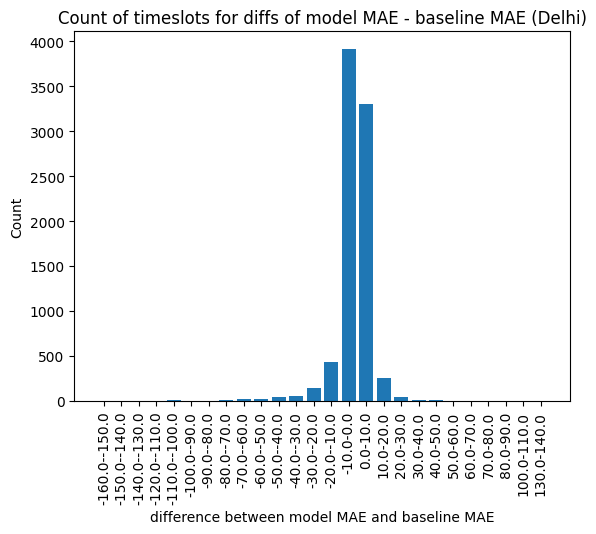

In [93]:
def count_ranges(numbers, range_size):
    range_counts = {}
    for num in numbers:
        range_start = num // range_size * range_size
        range_end = range_start + range_size
        range_label = f"{range_start}-{range_end}"
        if range_label not in range_counts:
            range_counts[range_label] = 0
        range_counts[range_label] += 1
    return range_counts


range_counts = count_ranges(diffs, 10)
for label, count in range_counts.items():
    print(f"{label}: {count}")
labels = list(range_counts.keys())
values = list(range_counts.values())

# Creating the bar chart
plt.bar(labels, values)

# Adding a title and axis labels
plt.title("Count of timeslots for diffs of model MAE - baseline MAE (Delhi)")
plt.xlabel("difference between model MAE and baseline MAE")
plt.ylabel("Count")
plt.xticks(rotation=90)
# Displaying the chart
plt.show()

-150.0--140.0: 1
-120.0--110.0: 1
-110.0--100.0: 3
-100.0--90.0: 1
-90.0--80.0: 4
-80.0--70.0: 5
-70.0--60.0: 15
-60.0--50.0: 14
-50.0--40.0: 25
-40.0--30.0: 29
-30.0--20.0: 85
-20.0--10.0: 201
-10.0-0.0: 759
0.0-10.0: 301
10.0-20.0: 41
20.0-30.0: 19
30.0-40.0: 6
40.0-50.0: 1
50.0-60.0: 1
60.0-70.0: 1
70.0-80.0: 1
80.0-90.0: 1
130.0-140.0: 1


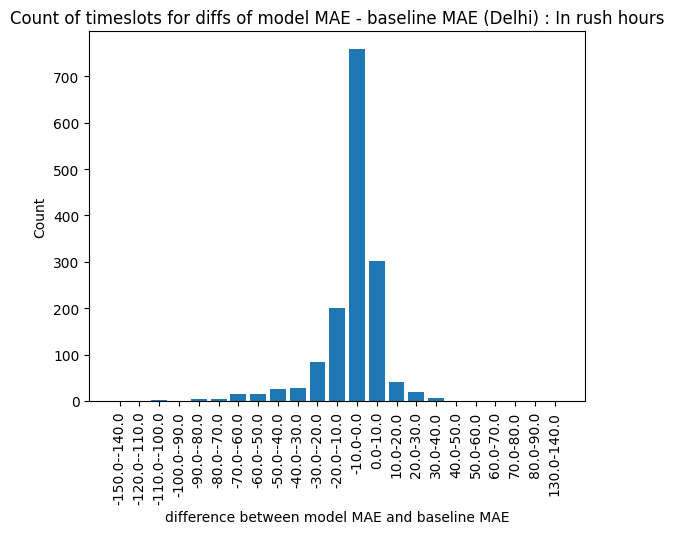

In [92]:
def count_ranges(numbers, range_size):
    range_counts = {}
    for num in numbers:
        range_start = num // range_size * range_size
        range_end = range_start + range_size
        range_label = f"{range_start}-{range_end}"
        if range_label not in range_counts:
            range_counts[range_label] = 0
        range_counts[range_label] += 1
    return range_counts


range_counts = count_ranges(diffsFestival, 10)
for label, count in range_counts.items():
    print(f"{label}: {count}")
labels = list(range_counts.keys())
values = list(range_counts.values())

# Creating the bar chart
plt.bar(labels, values)

# Adding a title and axis labels
plt.title("Count of timeslots for diffs of model MAE - baseline MAE (Delhi) : In rush hours")
plt.xlabel("difference between model MAE and baseline MAE")
plt.ylabel("Count")
plt.xticks(rotation=90)
# maxValue = sorted(values)[len(values)-1]
# plt.yticks([10*i for i in range(0, 1+(maxValue//10))])
# Displaying the chart
plt.show()

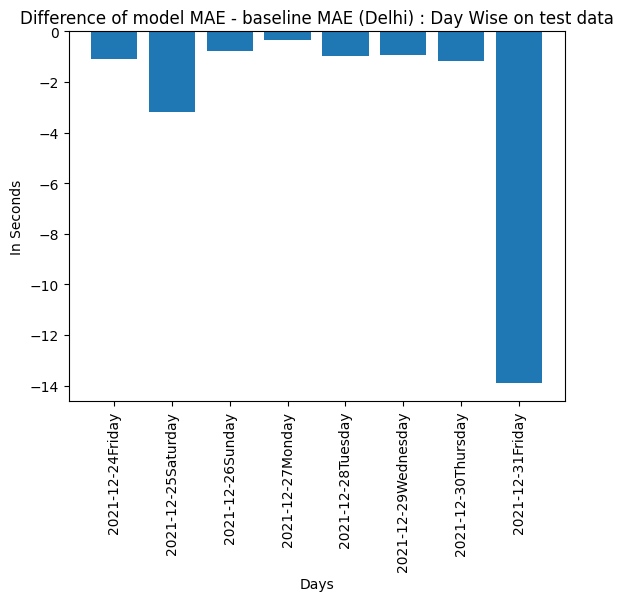

In [104]:
x = []
for day in allDays[len(allDays)-8:]:
    dd = getDayOfTheWeek(datetime.strptime(day, "%Y-%m-%d").weekday()+1)
    x.append(day + str(dd))
dayWiseDiffs = []
rmseDayWise = []
maeDayWise = []
for day in allDays:
    df2 = overallDF.loc[overallDF['Order_Date'] == day]
    if(df2.size == 0):
        continue
    maeModel = getMAE(df2.prep_time.values.tolist(), df2.predicted_prep_time_central.values.tolist())
    maeBaseline = getMAE(df2.prep_time.values.tolist(), df2.hour_wise_avg_kpt_of_the_day.values.tolist())
    dayWiseDiffs.append(maeModel-maeBaseline)
    maeDayWise.append(maeModel)
    rmseDayWise.append(getRMSE(df2.prep_time.values.tolist(), df2.predicted_prep_time_central.values.tolist()))
y = dayWiseDiffs[len(allDays)-8:]

# Creating the bar chart
plt.bar(x, y)

# Adding a title and axis labels
plt.title("Difference of model MAE - baseline MAE (Delhi) : Day Wise on test data")
plt.xlabel("Days")
plt.ylabel("In Seconds")
plt.xticks(rotation=90)
# maxValue = sorted(values)[len(values)-1]
# plt.yticks([10*i for i in range(0, 1+(maxValue//10))])
# Displaying the chart
plt.show()

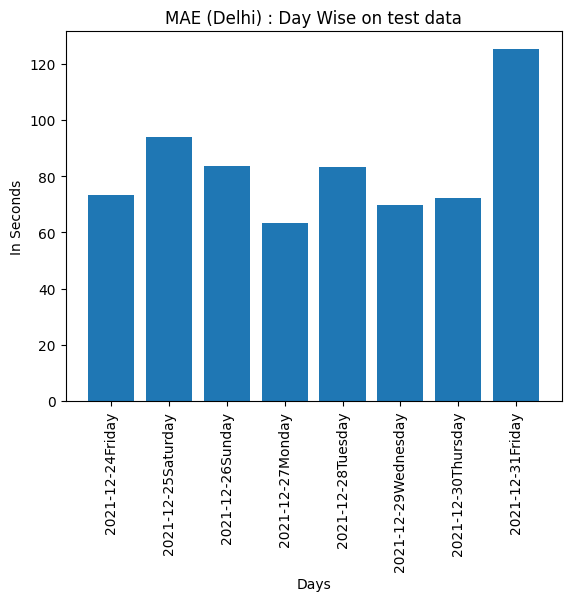

In [108]:
y = maeDayWise[len(allDays)-8:]

# Creating the bar chart
plt.bar(x, y)

# Adding a title and axis labels
plt.title("MAE (Delhi) : Day Wise on test data")
plt.xlabel("Days")
plt.ylabel("In Seconds")
plt.xticks(rotation=90)
# maxValue = sorted(values)[len(values)-1]
# plt.yticks([10*i for i in range(0, 1+(maxValue//10))])
# Displaying the chart
plt.show()

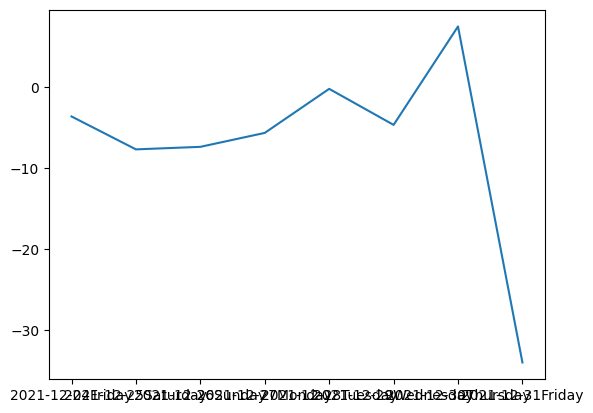

In [99]:
plt.plot(x, y)

In [212]:
for storeId in allStoreIds:
# for i in range(0, 1):
    df = overallDF.loc[overallDF['Location_Code'] == storeId]
    diffs = []
#     for day in allDays:
    for ts in allTimeslots:
        day = allDays[26]
        df2 = df.loc[(df['Order_Date'] == day) & (df['feature_3'] == ts)]
        if(df2.size == 0):
            continue
        rmseModel = getRMSE(df2.prep_time.values.tolist(), df2.predicted_prep_time_central.values.tolist())
        rmseBaseline = getRMSE(df2.prep_time.values.tolist(), df2.avg_kpt_in_last_one_hour.values.tolist())
        weekday = datetime.strptime(day, "%Y-%m-%d %H:%M:%S").weekday()
        print(f"Day : {day}, Week: {weekday}, timeslot: {ts}, Model RMSE: {rmseModel}, Baseline RMSE : {rmseBaseline}")    

Day : 2022-07-27 00:00:00, Week: 2, timeslot: 12.0, Model RMSE: 38.71929537172789, Baseline RMSE : 33.56447185074673
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 13.0, Model RMSE: 45.02856316840642, Baseline RMSE : 47.21386577939607
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 14.0, Model RMSE: 59.40477608850966, Baseline RMSE : 73.11086865665474
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 15.0, Model RMSE: 67.88246709951804, Baseline RMSE : 66.9939476028299
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 16.0, Model RMSE: 33.07842101902586, Baseline RMSE : 46.350228538940065
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 17.0, Model RMSE: 196.30736784236922, Baseline RMSE : 203.7129211528454
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 18.0, Model RMSE: 93.05375601228607, Baseline RMSE : 92.31384320295317
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 19.0, Model RMSE: 102.61300312308741, Baseline RMSE : 92.63588547227084
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 20.0, Model RMSE

Day : 2022-07-27 00:00:00, Week: 2, timeslot: 16.0, Model RMSE: 249.01770994611056, Baseline RMSE : 235.09958136841604
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 17.0, Model RMSE: 169.8044944230333, Baseline RMSE : 221.08366040769852
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 18.0, Model RMSE: 120.08443320087714, Baseline RMSE : 150.0856642030031
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 19.0, Model RMSE: 22.822809251239256, Baseline RMSE : 24.73499697724607
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 20.0, Model RMSE: 55.043140899304476, Baseline RMSE : 62.20706625481537
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 21.0, Model RMSE: 20.277607114360446, Baseline RMSE : 27.394911756924294
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 22.0, Model RMSE: 16.93295838133628, Baseline RMSE : 21.347949549528956
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 23.0, Model RMSE: 40.65216801827357, Baseline RMSE : 29.173474445387626
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 24.0, Mo

In [198]:
a = Counter(overallDF.prep_time.values.tolist())
a = {}
for day in allDays:
    d = datetime.strptime(day, "%Y-%m-%d %H:%M:%S").weekday()
    avgPrepTime = mean(overallDF.loc[overallDF['feature_2'] == d+1].prep_time.values.tolist())
    a[d+1] = avgPrepTime

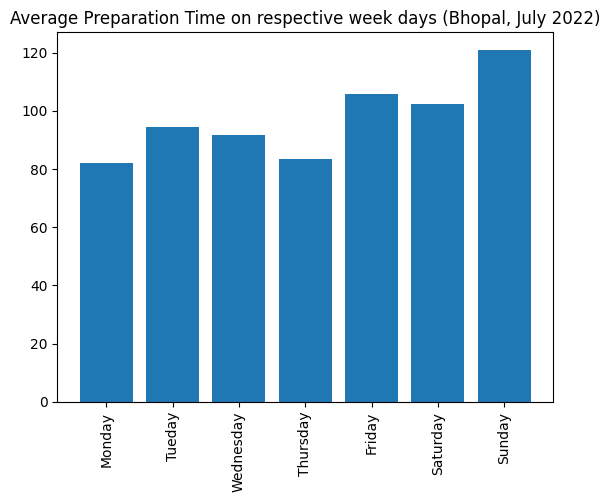

In [200]:
from matplotlib import pyplot
x = ['Monday', 'Tueday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y = [a[1], a[2], a[3], a[4], a[5], a[6], a[7]]
pyplot.bar(x, y)
pyplot.xticks(rotation=90)
pyplot.title("Average Preparation Time on respective week days (Bhopal, July 2022)")
pyplot.show()

In [202]:
a = {}
for ts in allTimeslots:
    print(ts)
    avgPrepTime = mean(overallDF.loc[overallDF['feature_3'] == ts].prep_time.values.tolist())
    a[ts] = avgPrepTime

1.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0


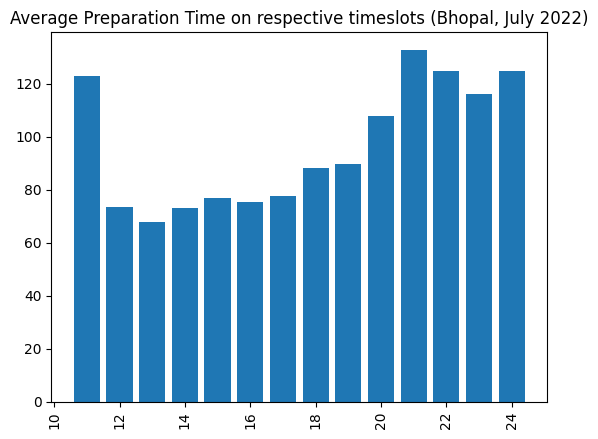

In [205]:
from matplotlib import pyplot
x = [i for i in range(11, 25)]
y = [a[i] for i in range(11, 25)]
pyplot.bar(x, y)
pyplot.xticks(rotation=90)
pyplot.title("Average Preparation Time on respective timeslots (Bhopal, July 2022)")
pyplot.show()

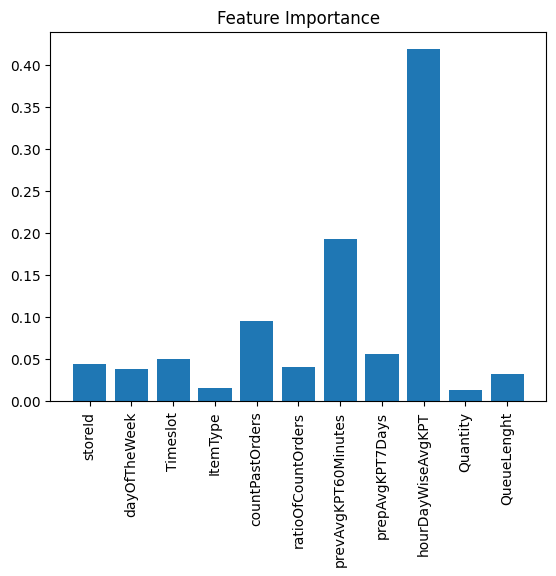

0.9999999087303877


In [226]:
from matplotlib import pyplot
f = ['storeId', 'dayOfTheWeek', 'Timeslot', 'ItemType', 'countPastOrders', 'ratioOfCountOrders', 'prevAvgKPT60Minutes', 'prepAvgKPT7Days', 'hourDayWiseAvgKPT', 'Quantity', 'QueueLenght']
pyplot.bar(f, best_regressor.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.title("Feature Importance")
pyplot.show()
print(sum(best_regressor.feature_importances_))

In [ ]:
# Experiment 1
# remove feature with feature value less than 0.05
# Remaining Features : 1,2,3,5,7,8,9
totalFeatures = (1 +  # store ID (categorical)
                 1 +  # day of the week (categorical)
                 1 +  #timeslot of the day (categorical)
                 1 +  #count past orders in last 30 minutes
                 1 +  # average previous preparation time in last 1 hour
                 1 +  # average previous preparation time in last 7 days
                 1  # average kpt time, hour wise according to the day of the week
                 )  # length of the current queue

feature_cols = []
for i in range(0, totalFeatures):
    feature_cols.append('feature_' + str(i + 1))
# TIME CONSUMING (3m 21s for Bhopal)
for storeId in restWiseDFs:
    X = []
    df = restWiseDFs[storeId]
    for index, item in df.iterrows():
        features = getStoreId(item, False)
        features += dayOfTheWeek(item['Kitchen_Display_Time'], isOneHotEncodingRequired)
        features += getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired)
        # features += getItemType(item, clubItemsCategoryWise, isOneHotEncodingRequired)
        features += [countPastOrders(item, slotTimeForPastOrders)]
        # features += [getLiftInOrders(item, slotTimeForPastOrders)]
        features += [getPreviousPrepTime(item, timeslot=60)]
        features += [getPreviousPrepTime(item, timeslot=7 * 24 * 60)]
        features += [getHourWiseAverage(item)]
        # features += [getQuantity(item)]
        # features += [lengthQueue(item)]
        X.append(features)
    Xnp = np.array(X)
    updateFeatures(storeId, Xnp)
    print(Xnp.shape)
# categorical data
if not isOneHotEncodingRequired:
    for i in range(0, 4):
        for storeId in allStoreIds:
            restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
restWiseScalers = {}

# normalize feature values
if isNormalizationRequired:
    for storeId in allStoreIds:
        firstTime = datetime(2022, 7, 1)
        lastTime = datetime(2022, 7, 14)
        trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
                                                (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)].loc[:,
                       feature_cols]
        scaler = StandardScaler()
        scaler.fit(trainingData)
        if isNormalizationRequired:
            X = restWiseDFs[storeId].loc[:, feature_cols]
            X_scaled = scaler.transform(X)
            X_scalednp = np.array(X_scaled)
            updateFeatures(storeId, X_scalednp)
    save_object(restWiseDFs, f'restWiseDFsWithNormalizedFeatures{city}.pkl')


if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 14)
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                                 (overallDF['Kitchen_Display_Time'] <= lastTime)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 15)
    lastTime = datetime(2022, 7, 21)
    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                                   (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 22)
    lastTime = datetime(2022, 7, 31)
    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                             (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()

    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10, 12, 14],
        'learning_rate': [0.2, 0.1, 0.01],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    for storeId in allStoreIds:
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = best_regressor.predict(X)
        restWiseDFs[storeId]['predicted_prep_time_central'] = predictions

        a = getRMSE(y, predictions)
        print("RMSE score overall for store central model (30 days) " + storeId + " :  ", a)

In [ ]:

rmse1 = ((trainingData.prep_time - trainingData.predicted_prep_time_central) ** 2).mean() ** .5
rmse2 = ((trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day) ** 2).mean() ** .5
# hour_wise_avg_kpt_of_the_day
# rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
#
absError = (abs(trainingData.prep_time - trainingData.predicted_prep_time_central)).values.tolist()
absError2 = (abs(trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day)).values.tolist()
meanAbsError = statistics.mean(absError)
medianAbsError = statistics.median(absError)

meanAbsError2 = statistics.mean(absError2)
medianAbsError2 = statistics.median(absError2)
# stdAbsError = statistics.stdev(absError)
#
# error = (df.prep_time - df.predicted_prep_time).values.tolist()
# meanError = statistics.mean(error)
# medianError = statistics.median(error)
# stdError = statistics.stdev(error)
#
# accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()

In [ ]:
rmse1, rmse2, meanAbsError, meanAbsError2, medianAbsError, medianAbsError21

In [ ]:
if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 21)
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 24)
    lastTime = datetime(2022, 7, 22)
    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 25)
    lastTime = datetime(2022, 7, 31)
    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, 10, 13],
        'learning_rate': [0.2, 0.1, 0.01],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    for storeId in allStoreIds:
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = best_regressor.predict(X)
        restWiseDFs[storeId]['predicted_prep_time_central'] = predictions

        a = getRMSE(y, predictions)
        print("RMSE score overall for store central model (30 days) "+storeId+" :  ", a)

In [ ]:

rmse1 = ((testingData.prep_time - testingData.predicted_prep_time_central) ** 2).mean() ** .5
rmse2 = ((testingData.prep_time - testingData.hour_wise_avg_kpt_of_the_day) ** 2).mean() ** .5
# hour_wise_avg_kpt_of_the_day
# rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
#
absError = (abs(trainingData.prep_time - trainingData.predicted_prep_time_central)).values.tolist()
absError2 = (abs(trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day)).values.tolist()
meanAbsError = statistics.mean(absError)
medianAbsError = statistics.median(absError)

meanAbsError2 = statistics.mean(absError2)
medianAbsError2 = statistics.median(absError2)
# stdAbsError = statistics.stdev(absError)
#
# error = (df.prep_time - df.predicted_prep_time).values.tolist()
# meanError = statistics.mean(error)
# medianError = statistics.median(error)
# stdError = statistics.stdev(error)
#
# accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()

In [ ]:
# Time Consuming (training on first 14 days of July)
restWiseModelsXGB = {}

for storeId in allStoreIds:
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 14)
    trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]
    
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 15)
    lastTime = datetime(2022, 7, 21)
    validationData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 22)
    lastTime = datetime(2022, 7, 31)
    testData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    regressor = XGBRegressor()
    # define the parameter grid to search
    param_grid = {
        'tree_method': ['approx', 'hist', 'auto'],
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, 10, 13],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    restWiseModelsXGB[storeId] = best_regressor
    
    
    X = restWiseDFs[storeId].loc[:, feature_cols]
    y = restWiseDFs[storeId].prep_time.values.tolist()
    predictions = best_regressor.predict(X)
    restWiseDFs[storeId]['predicted_prep_time'] = predictions
    
    a = getRMSE(y, predictions)
    print("RMSE score overall for store (30 days) "+storeId+" :  ", a)

In [ ]:
save_object(restWiseDFs, f'restWiseDFsWithPredictions{city}.pkl')

In [ ]:
save_object(restWiseModelsXGB, f'restWiseModels{city}.pkl')

In [ ]:
def getPredictionHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime) & \
                                       (restWiseDFs[storeId]['prep_time'] != timedelta(0))]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.predicted_prep_time)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.predicted_prep_time).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()
    for i in range(0, len(accuracy)):
        if accuracy[i] < 0:
            accuracy[i] = -1*accuracy[i]
        accuracy[i] = 1-accuracy[i]
    meanAccuracy = statistics.mean(accuracy)
    if not(meanAccuracy > 0 and meanAccuracy < 1):
        print("Mean accuracy is zero: ")
        print(meanAccuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

In [ ]:
rmseList = []
meanAbsErrorList = []
medianAbsErrorList = []
stdAbsErrorList = []
meanErrorList = []
medianErrorList = []
stdErrorList = []
meanAccuracyList = []
medianAccuracyList = []
stdAccuracyList = []

x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

for i in x:
    (rmse, (meanAbsError, medianAbsError, stdAbsError), 
    (meanError, medianError, stdError), 
    (meanAccuracy, medianAccuracy, stdAccuracy)) = getPredictionHyperparameters(i,i)
    rmseList.append(rmse)
    meanAbsErrorList.append(meanAbsError)
    medianAbsErrorList.append(medianAbsError)
    stdAbsErrorList.append(stdAbsError)
    meanErrorList.append(meanError)
    medianErrorList.append(medianError)
    stdErrorList.append(stdError)
    meanAccuracyList.append(meanAccuracy)
    medianAccuracyList.append(medianAccuracy)
    stdAccuracyList.append(stdAccuracy)

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, rmseList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE value on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_1.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianAbsErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Absolute Value of error (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_3.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanErrorList, stdErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (mean, std dev of the day) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_4.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_5.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanAccuracyList, stdAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (mean, std dev of the day) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_6.png')



In [ ]:
overallDf = pd.DataFrame()
for storeId in allStoreIds:
        overallDf = pd.concat([overallDf, restWiseDFs[storeId]], ignore_index = True)

In [ ]:
a = overallDf.loc[(overallDf['Oven_Time'] - overallDf['Kitchen_Display_Time'] < timedelta(seconds=1))]

In [ ]:
a

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.ylim(0.8, 1)
plt.bar(x, medianAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_7.png')


In [ ]:
# baseline approach
# Hourwise avg 

weekdayHourWiseAvg = {}
weekendHourWiseAvg = {}
for store in allStoreIds:
    weekdayHourWiseAvg[store] = {}
    weekendHourWiseAvg[store] = {}
for i in range(1, 15):
    dt = datetime(2022, 7, i)
    for storeId in allStoreIds:
        df = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= dt) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < dt+timedelta(days=1))]
        for index, item in df.iterrows():
            ts = getTimeslot(item['Kitchen_Display_Time'])
            if(dayOfTheWeek(item['Kitchen_Display_Time']) >= 5):
                if ts not in weekendHourWiseAvg[storeId]:
                    weekendHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekendHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekendHourWiseAvg[storeId][ts]['cnt'] += 1
            else:
                if ts not in weekdayHourWiseAvg[storeId]:
                    weekdayHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekdayHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekdayHourWiseAvg[storeId][ts]['cnt'] += 1

for storeId in allStoreIds:
    for ts in weekdayHourWiseAvg[storeId].keys():
        weekdayHourWiseAvg[storeId][ts]['val'] = weekdayHourWiseAvg[storeId][ts]['val']/weekdayHourWiseAvg[storeId][ts]['cnt']
    for ts in weekendHourWiseAvg[storeId].keys():
        weekendHourWiseAvg[storeId][ts]['val'] = weekendHourWiseAvg[storeId][ts]['val']/weekendHourWiseAvg[storeId][ts]['cnt']
        

        
        

In [ ]:
overallDF = pd.DataFrame()
for storeId in allStoreIds:
    overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index = True)

In [ ]:
avgs = []
for index, item in overallDF.iterrows():
    ts = getTimeslot(item['Kitchen_Display_Time'])
    storeId = item['Location_Code']
    if(dayOfTheWeek(item['Kitchen_Display_Time']) >= 5):
        if(ts not in weekendHourWiseAvg[storeId]):
            avgs.append(0)
        else:
            avgs.append(weekendHourWiseAvg[storeId][ts]['val'] )
    else:
        if(ts not in weekdayHourWiseAvg[storeId]):
            avgs.append(0)
        else:
            avgs.append(weekdayHourWiseAvg[storeId][ts]['val'] )


In [ ]:
overallDF['hourwise_avg'] = avgs

In [ ]:
restWiseDFs = {}
for storeId in allStoreIds:
    restWiseDFs[storeId] = overallDF.loc[overallDF['Location_Code'] == storeId]

In [ ]:
def getBaselineHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime)]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.hourwise_avg) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.hourwise_avg)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.hourwise_avg).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = ((df.prep_time - abs(df.prep_time - df.hourwise_avg))/df.prep_time).values.tolist()
    meanAccuracy = statistics.mean(accuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

In [ ]:
rmseListBL = []
meanAbsErrorListBL = []
medianAbsErrorListBL = []
stdAbsErrorListBL = []
meanErrorListBL = []
medianErrorListBL = []
stdErrorListBL = []
meanAccuracyListBL = []
medianAccuracyListBL = []
stdAccuracyListBL = []

x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

for i in x:
    (rmse, (meanAbsError, medianAbsError, stdAbsError), 
    (meanError, medianError, stdError), 
    (meanAccuracy, medianAccuracy, stdAccuracy)) = getBaselineHyperparameters(i,i)
    rmseListBL.append(rmse)
    meanAbsErrorListBL.append(meanAbsError)
    medianAbsErrorListBL.append(medianAbsError)
    stdAbsErrorListBL.append(stdAbsError)
    meanErrorListBL.append(meanError)
    medianErrorListBL.append(medianError)
    stdErrorListBL.append(stdError)
    meanAccuracyListBL.append(meanAccuracy)
    medianAccuracyListBL.append(medianAccuracy)
    stdAccuracyListBL.append(stdAccuracy)

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, rmseListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE value on the respective day")
plt.title("Baseline prediction")
plt.savefig(f'BL_{city}_1.png')

In [ ]:
rmseListBL

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianAbsErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Absolute Value of error (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_3.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanErrorListBL, stdErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (mean, std dev of the day) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_4.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_5.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanAccuracyListBL, stdAccuracyListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (mean, std dev of the day) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_6.png')



In [ ]:
# plot for 15, 20, 25, 30 july 
plt.ylim(0.7, 1)
plt.bar(x, medianAccuracyListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_7.png')


In [ ]:
(rmseTr, (meanAbsErrorTr, medianAbsErrorTr, stdAbsErrorTr), 
    (meanErrorTr, medianErrorTr, stdErrorTr), 
    (meanAccuracyTr, medianAccuracyTr, stdAccuracyTr)) = getPredictionHyperparameters(1, 14)

In [ ]:
(rmseTe, (meanAbsErrorTe, medianAbsErrorTe, stdAbsErrorTe), 
    (meanErrorTe, medianErrorTe, stdErrorTe), 
    (meanAccuracyTe, medianAccuracyTe, stdAccuracyTe)) = getPredictionHyperparameters(15, 31)

In [ ]:
(rmseTr, (meanAbsErrorTr, medianAbsErrorTr, stdAbsErrorTr), 
    (meanErrorTr, medianErrorTr, stdErrorTr), 
    (meanAccuracyTr, medianAccuracyTr, stdAccuracyTr))

In [ ]:
(rmseTe, (meanAbsErrorTe, medianAbsErrorTe, stdAbsErrorTe), 
    (meanErrorTe, medianErrorTe, stdErrorTe), 
    (meanAccuracyTe, medianAccuracyTe, stdAccuracyTe))

In [ ]:
x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
plt.plot(x, rmseList, label="xgboost model")
plt.plot(x, rmseListBL, label='baseline')
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE Comparison on the respective day")
plt.title("Model vs Baseline in RMSE values")
plt.legend()
plt.savefig(f'BL_{city}_7.png')


In [ ]:
x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
plt.plot(x, medianAbsErrorList, label="xgboost model")
plt.plot(x, medianAbsErrorListBL, label='baseline')
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Median Abs Error Comparison on the respective day")
plt.title("Model vs Baseline in Median Abs Error")
plt.legend()
plt.savefig(f'BL_{city}_8.png')

In [ ]:
def getErrorSlot(error):
    return (error//5)*5

cnt = {}
for index, item in overallDF.iterrows():
    error = (item['prep_time'] - item['predicted_prep_time'])/60
    lts = getErrorSlot(error)
    if(lts not in cnt):
        cnt[lts]=1
    else:
        cnt[lts]+=1

In [ ]:
ranges = sorted(cnt.keys())

In [ ]:
cnt[-10]

In [ ]:
cnt[-5]

In [ ]:
cnt[0]

In [ ]:
for i in range(-)